# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


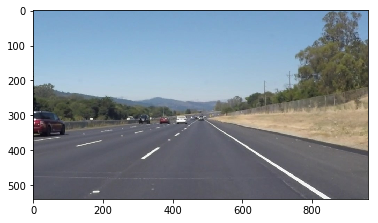

In [17]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [178]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_lines_solid(img, lines, color=[255, 0, 0], thickness=10):
    # Maintain slopes of left and right lane lines, to average later.
    slopes_left = []
    slopes_right = []
    # Filter slopes that have abs value less than 0.5
    slope_thres=0.4
    # Filter points which are almost alighed with axis
    dist_thres = 10
    # To average the lines, lets save the centers of the lines and average them later and extend them to the boundaries.
    center_x_left = []
    center_y_left = []
    center_x_right = []
    center_y_right = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1)/(x2 - x1)
            if abs(x2-x1) < dist_thres or abs(y2-y1) < dist_thres:
                continue
            print(x1,y1,x2,y2,slope)
            if abs(slope) > slope_thres:
                if slope < 0:
                    center_x_left.append((x1 + x2)/2)
                    center_y_left.append((y1 + y2)/2)
                    slopes_left.append(slope)
                else:
                    center_x_right.append((x1 + x2)/2)
                    center_y_right.append((y1 + y2)/2)
                    slopes_right.append(slope)

    slopes_left_mean = np.sum(slopes_left)/len(slopes_left)
    center_x_left_mean = np.sum(center_x_left)/len(center_x_left)
    center_y_left_mean = np.sum(center_y_left)/len(center_y_left)
    
    slopes_right_mean = np.sum(slopes_right)/len(slopes_right)
    center_x_right_mean = np.sum(center_x_right)/len(center_x_right)
    center_y_right_mean = np.sum(center_y_right)/len(center_y_right)
    
    print(slopes_left_mean, slopes_right_mean)
    
    ybottom = img.shape[0]
    ytop = 330
    
    # Let's find (m, b) in x = my + b because we know ytop and ybottom, so we just need to
    # find xtop, xbottom for left and right lane.
    m_left =  1/slopes_left_mean
    b_left = center_x_left_mean - (m_left * center_y_left_mean)
    m_right = 1/slopes_right_mean
    b_right = center_x_right_mean - (m_right * center_y_right_mean)

    mean_left_line = np.poly1d([m_left, b_left])
    mean_right_line = np.poly1d([m_right, b_right])

    cv2.line(img, (int(mean_left_line(ybottom)), ybottom),  (int(mean_left_line(ytop)), ytop), color, 10)
    cv2.line(img, (int(mean_right_line(ybottom)), ybottom),  (int(mean_right_line(ytop)), ytop), color, 10)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_solid(line_img, lines, 10)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [179]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [180]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def line_finder(image):
    #print('This image is: ',type(image), 'with dimensions:', image.shape)
    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]

    # Note: always make a copy rather than simply using "="
    image_output= np.copy(image)
    # Read in and grayscale the image
    gray = cv2.cvtColor(image_output,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array(
        [[(140, ysize),(430, 330), (580, 330), (950, ysize)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 # minimum number of pixels making up a line
    max_line_gap = 12    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the edge image
    image_output = weighted_img(line_image, image, α=0.9, β=10., λ=0.)
    return image_output

for filename in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + filename)
    image_output = line_finder(image)
    # plt.figure()
    # plt.imshow(image_output)
    cv2.imwrite("test_images_output/" + filename, cv2.cvtColor(image_output, cv2.COLOR_RGB2BGR))
    


517 331 877 538 0.575
521 330 897 538 0.553191489362
280 460 346 410 -0.757575757576
295 461 352 411 -0.877192982456
327 423 344 410 -0.764705882353
281 460 305 442 -0.75
338 425 353 412 -0.866666666667
437 344 449 334 -0.833333333333
438 344 458 330 -0.7
435 342 451 331 -0.6875
520 330 656 405 0.551470588235
538 342 834 513 0.577702702703
514 330 532 340 0.555555555556
631 390 898 538 0.554307116105
293 462 311 446 -0.888888888889
321 428 341 413 -0.75
439 344 457 330 -0.777777777778
847 522 876 539 0.586206896552
436 344 453 330 -0.823529411765
-0.789764225068 0.564776335502
521 331 853 539 0.626506024096
514 330 790 510 0.652173913043
721 466 832 538 0.648648648649
310 423 356 392 -0.673913043478
515 330 653 420 0.652173913043
319 425 363 394 -0.704545454545
317 419 357 392 -0.675
318 425 362 394 -0.704545454545
163 526 178 516 -0.666666666667
435 341 449 331 -0.714285714286
310 422 355 392 -0.666666666667
521 330 854 538 0.624624624625
639 412 831 537 0.651041666667
165 526 179 516

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [181]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [182]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = line_finder(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [183]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

525 331 869 538 0.601744186047
518 330 700 444 0.626373626374
187 513 300 431 -0.725663716814
205 513 310 431 -0.780952380952
695 442 848 538 0.627450980392
752 479 847 539 0.631578947368
390 370 443 332 -0.716981132075
202 514 232 491 -0.766666666667
388 369 441 330 -0.735849056604
525 330 714 444 0.603174603175
420 349 446 331 -0.692307692308
278 458 310 432 -0.8125
631 401 742 471 0.630630630631
391 370 406 360 -0.666666666667
417 349 442 330 -0.76
187 512 297 432 -0.727272727273
521 331 641 406 0.625
203 514 256 473 -0.77358490566
196 507 215 493 -0.736842105263
275 460 297 442 -0.818181818182
-0.747189912959 0.620850424855
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  2%|▏         | 4/222 [00:00<00:05, 39.83it/s]

525 331 869 538 0.601744186047
518 330 700 444 0.626373626374
187 513 300 431 -0.725663716814
205 513 310 431 -0.780952380952
695 442 848 538 0.627450980392
752 479 847 539 0.631578947368
390 370 443 332 -0.716981132075
202 514 232 491 -0.766666666667
388 369 441 330 -0.735849056604
525 330 714 444 0.603174603175
420 349 446 331 -0.692307692308
278 458 310 432 -0.8125
631 401 742 471 0.630630630631
391 370 406 360 -0.666666666667
417 349 442 330 -0.76
187 512 297 432 -0.727272727273
521 331 641 406 0.625
203 514 256 473 -0.77358490566
196 507 215 493 -0.736842105263
275 460 297 442 -0.818181818182
-0.747189912959 0.620850424855
523 330 807 501 0.602112676056
418 351 445 331 -0.740740740741
151 538 277 447 -0.722222222222
517 330 734 466 0.626728110599
170 538 289 449 -0.747899159664
747 476 846 538 0.626262626263
752 469 867 538 0.6
707 450 845 537 0.630434782609
383 371 399 360 -0.6875
803 512 843 537 0.625
520 331 653 414 0.624060150376
258 471 287 449 -0.758620689655
413 350 426 340


525 330 544 341 0.578947368421
548 345 718 447 0.6
425 344 442 332 -0.705882352941
-0.718333474804 0.612623340502
525 330 871 538 0.601156069364
518 330 796 504 0.625899280576
550 346 755 469 0.6
339 402 375 378 -0.666666666667
346 403 377 381 -0.709677419355
797 506 849 538 0.615384615385
339 401 372 378 -0.69696969697
398 363 424 345 -0.692307692308
397 


  5%|▌         | 12/222 [00:00<00:05, 38.40it/s]

363 421 344 -0.791666666667
570 363 824 522 0.625984251969
825 524 848 538 0.608695652174
526 334 563 357 0.621621621622
396 362 411 350 -0.8
413 352 441 332 -0.714285714286
353 392 373 378 -0.7
-0.721446732031 0.614105927298
517 330 851 538 0.622754491018
524 330 811 502 0.599303135889
326 410 364 384 -0.684210526316
772 478 873 538 0.594059405941
334 412 370 385 -0.75
391 365 419 346 -0.678571428571
558 351 661 413 0.601941747573
331 408 366 383 -0.714285714286
335 412 370 386 -0.742857142857
520 331 574 364 0.611111111111
393 366 420 346 -0.740740740741
525 330 580 363 0.6
702 446 795 504 0.623655913978
643 401 871 538 0.600877192982
-0.718444258795 0.606712874811
523 330 871 539 0.600574712644
712 453 848 538 0.625
557 355 849 538 0.626712328767
580 365 685 428 0.6
518 330 598 380 0.625
319 424 361 392 -0.761904761905
310 423 357 390 -0.702127659574
309 422 353 391 -0.704545454545
315 425 359 393 -0.727272727273
556 350 864 535 0.600649350649
525 330 568 356 0.604651162791
162 528 

538 0.621621621622
587 371 811 511 0.625
375 374 395 362 -0.6
379 377 398 364 -0.684210526316
411 351 441 330 -0.7
375 375 396 362 -0.619047619048
173 529 216 498 -0.720930232558
524 330 664 418 0.628571428571
518 330 633 405 0.652173913043
413 353 430 342 -0.647058823529
238 482 255 469 -0.764705882353
398 362 444 330 -0.695652173913
208 503 234 485 -0.692307692308
411 352 440 331 -0.724137931034
412 350 426 340 -0.714285714286
424 345 444 331 -0.7
415 350 443 330 -0.714285714286
-0.697275239788 0.638426549997
543 344 738 475 0.671794871795
585 368 854 536 0.624535315985
525 330 542 341


  9%|▉         | 21/222 [00:00<00:05, 39.12it/s]

 0.647058823529
526 330 719 451 0.626943005181
158 538 221 492 -0.730158730159
577 366 790 509 0.671361502347
412 352 439 332 -0.740740740741
376 379 395 366 -0.684210526316
157 538 221 491 -0.734375
795 512 837 538 0.619047619048
407 352 439 330 -0.6875
372 380 390 369 -0.611111111111
368 378 388 364 -0.7
525 333 550 350 0.68
820 514 859 539 0.641025641026
411 353 443 331 -0.6875
520 330 536 341 0.6875
780 502 803 516 0.608695652174
541 343 564 359 0.695652173913
372 376 390 364 -0.666666666667
-0.693584752777 0.652146782273
527 330 808 506 0.626334519573
520 330 697 445 0.649717514124
527 331 859 539 0.626506024096
689 441 837 538 0.655405405405
367 385 390 369 -0.695652173913
735 472 836 538 0.653465346535
360 385 383 367 -0.782608695652
534 338 614 390 0.65
366 385 387 370 -0.714285714286
404 353 422 340 -0.722222222222
595 379 733 469 0.652173913043
360 383 377 371 -0.705882352941
404 355 438 332 -0.676470588235
406 355 427 341 -0.666666666667
404 354 437 330 -0.727272727273
405 3


 12%|█▏        | 26/222 [00:00<00:04, 41.56it/s]

853 537 0.625377643505
414 350 442 330 -0.714285714286
517 330 687 441 0.652941176471
384 371 398 361 -0.714285714286
748 483 833 539 0.658823529412
141 539 214 488 -0.698630136986
163 539 289 447 -0.730158730159
387 374 433 342 -0.695652173913
253 463 278 445 -0.72
384 372 441 332 -0.701754385965
402 361 425 344 -0.739130434783
534 338 854 538 0.625
418 352 445 331 -0.777777777778
525 336 572 367 0.659574468085
403 361 445 330 -0.738095238095
245 468 277 445 -0.71875
735 474 777 501 0.642857142857
389 374 404 363 -0.733333333333
416 352 433 340 -0.705882352941
-0.720703875984 0.64369309007



 16%|█▌        | 35/222 [00:00<00:04, 41.62it/s]

523 331 854 538 0.625377643505
516 330 760 489 0.651639344262
635 408 814 525 0.653631284916
377 377 390 367 -0.769230769231
164 538 261 467 -0.731958762887
142 538 251 465 -0.669724770642
384 378 399 367 -0.733333333333
753 486 833 538 0.65
569 364 669 429 0.65
206 496 235 476 -0.689655172414
143 538 171 520 -0.642857142857
413 355 444 332 -0.741935483871
229 492 261 468 -0.75
379 376 396 364 -0.705882352941
412 353 444 330 -0.71875
578 365 855 538 0.624548736462
380 379 395 369 -0.666666666667
166 537 222 497 -0.714285714286
423 346 444 331 -0.714285714286
414 355 431 343 -0.705882352941
399 364 443 330 -0.772727272727
522 330 543 343 0.619047619048
-0.715145033939 0.639177804028
522 330 856 538 0.622754491018
662 426 834 538 0.651162790698
525 336 810 522 0.652631578947
535 339 855 539 0.625
516 330 713 458 0.649746192893
165 538 226 494 -0.72131147541
370 381 389 368 -0.684210526316
142 539 213 491 -0.676056338028
373 384 395 370 -0.636363636364
188 507 210 492 -0.681818181818
370 


 18%|█▊        | 40/222 [00:00<00:04, 42.54it/s]

248 478 328 418 -0.75
515 330 587 377 0.652777777778
399 367 447 331 -0.75
394 365 443 330 -0.714285714286
253 475 328 419 -0.746666666667
517 330 540 345 0.652173913043
740 467 855 538 0.617391304348
535 339 567 359 0.625
395 365 443 331 -0.708333333333
410 357 447 330 -0.72972972973
521 330 543 343 0.590909090909
246 469 321 417 -0.693333333333
603 389 832 538 0.650655021834
574 365 731 463 0.624203821656
410 356 443 332 -0.727272727273
-0.724268520594 0.632221835319
592 382 833 539 0.651452282158
557 354 807 510 0.624
536 344 704 454 0.654761904762
699 442 855 539 0.621794871795
191 506 304 430 -0.672566371681
516 330 554 355 0.657894736842
228 494 285 450 -0.771929824561
240 472 302 430 -0.677419354839
816 514 855 538 0.615384615385
390 369 443 330 -0.735849056604
213 505 261 468 -0.770833333333
192 506 260 460 -0.676470588235
521 330 553 350 0.625
393 371 446 331 -0.754716981132
271 462 311 430 -0.8
553 351 590 374 0.621621621622
207 509 223 496 -0.8125
290 448 311 431 -0.80952380


 23%|██▎       | 50/222 [00:01<00:04, 41.67it/s]

 331 569 357 0.619047619048
392 364 419 344 -0.740740740741
329 409 367 381 -0.736842105263
534 339 785 508 0.673306772908
351 398 372 383 -0.714285714286
409 353 438 331 -0.758620689655
812 524 833 539 0.714285714286
338 409 356 396 -0.722222222222
-0.719875280926 0.656295758013
522 331 831 539 0.673139158576
671 423 794 502 0.642276422764
527 330 740 468 0.647887323944
525 330 683 432 0.645569620253
763 481 853 539 0.644444444444
314 419 356 388 -0.738095238095
336 411 364 388 -0.821428571429
324 420 363 388 -0.820512820513
737 475 831 538 0.670212765957
389 369 416 347 -0.814814814815
317 417 357 388 -0.725
319 421 339 407 -0.7
838 528 854 538 0.625
519 330 733 474 0.672897196262
391 366 413 348 -0.818181818182
332 414 364 389 -0.78125
744 469 788 498 0.659090909091
-0.777410407879 0.653390871255
557 351 855 538 0.627516778523
608 384 854 538 0.626016260163
522 331 793 513 0.671586715867
525 330 598 376 0.630136986301
676 434 832 539 0.673076923077
295 431 350 394 -0.672727272727
30


 27%|██▋       | 59/222 [00:01<00:04, 36.20it/s]

-0.684210526316
405 356 425 343 -0.65
716 461 831 538 0.669565217391
359 386 381 368 -0.818181818182
520 331 539 344 0.684210526316
769 485 816 516 0.659574468085
402 356 422 341 -0.75
416 347 440 330 -0.708333333333
542 345 596 382 0.685185185185
828 522 853 538 0.64
404 356 441 331 -0.675675675676
-0.729934736919 0.660078810716
539 343 820 532 0.672597864769
522 330 750 473 0.627192982456
726 459 852 538 0.626984126984
518 330 581 372 0.666666666667
523 330 694 437 0.625730994152
348 390 376 372 -0.642857142857
348 391 377 372 -0.655172413793
356 392 380 374 -0.75
362 388 380 375 -0.722222222222
619 396 831 539 0.674528301887
398 358 421 342 -0.695652173913
399 359 423 344 -0.625
517 330 532 340 0.666666666667
401 359 423 345 -0.636363636364
398 359 439 331 -0.682926829268
679 429 853 538 0.626436781609
397 358 419 342 -0.727272727273
354 393 380 372 -0.807692307692
422 342 437 331 -0.733333333333
352 389 367 379 -0.666666666667
-0.695429954449 0.648350548149
522 330 796 502 0.627737


 31%|███       | 68/222 [00:01<00:04, 38.49it/s]

-0.674418604651
731 466 769 491 0.657894736842
201 503 264 458 -0.714285714286
251 459 295 429 -0.681818181818
817 520 844 538 0.666666666667
769 490 788 503 0.684210526316
758 483 777 496 0.684210526316
283 445 303 429 -0.8
-0.709275999787 0.66304171308
513 330 823 539 0.674193548387
630 400 844 539 0.64953271028
151 538 281 447 -0.7
560 356 783 500 0.645739910314
558 359 824 538 0.672932330827
517 330 556 355 0.641025641026
385 373 443 332 -0.706896551724
522 332 626 399 0.644230769231
151 539 267 457 -0.706896551724
379 371 394 361 -0.666666666667
379 373 397 360 -0.722222222222
383 373 441 330 -0.741379310345
787 501 844 538 0.649122807018
514 331 542 350 0.678571428571
520 331 561 358 0.658536585366
249 468 279 447 -0.7
416 350 443 331 -0.703703703704
398 360 411 350 -0.769230769231
-0.712999530624 0.657098414558
624 397 844 539 0.645454545455
543 350 823 538 0.671428571429
151 538 252 467 -0.70297029703
518 330 633 404 0.64347826087
513 330 623 404 0.672727272727
378 378 395 366 


 35%|███▍      | 77/222 [00:01<00:03, 39.14it/s]

476 775 495 0.678571428571
-0.694514723452 0.668049435974
520 330 798 510 0.647482014388
514 330 821 537 0.674267100977
664 432 822 539 0.677215189873
272 449 335 405 -0.698412698413
757 482 825 527 0.661764705882
810 516 844 539 0.676470588235
429 340 444 330 -0.666666666667
513 330 547 353 0.676470588235
524 333 595 380 0.661971830986
305 427 335 406 -0.7
271 449 317 417 -0.695652173913
733 467 789 504 0.660714285714
428 341 446 330 -0.611111111111
696 443 752 480 0.660714285714
519 330 549 350 0.666666666667
426 340 441 330 -0.666666666667
-0.673084886128 0.666373725667
514 330 822 538 0.675324675325
657 427 821 538 0.676829268293
520 330 795 508 0.647272727273
246 467 321 415 -0.693333333333
637 405 843 538 0.645631067961
241 470 322 413 -0.703703703704
389 362 427 337 -0.657894736842
392 365 444 330 -0.673076923077
389 363 430 336 -0.658536585366
821 523 844 538 0.652173913043
404 354 440 331 -0.638888888889
519 330 560 357 0.658536585366
604 390 693 450 0.674157303371
714 466 819


 39%|███▉      | 87/222 [00:02<00:03, 39.67it/s]


743 490 766 505 0.652173913043
774 512 812 538 0.684210526316
328 408 343 397 -0.733333333333
532 344 580 376 0.666666666667
-0.740172735761 0.667462686162
541 346 757 487 0.652777777778
514 330 810 537 0.699324324324
592 380 835 538 0.650205761317
310 419 355 389 -0.666666666667
313 418 355 390 -0.666666666667
711 467 813 538 0.696078431373
519 330 536 341 0.647058823529
527 336 553 353 0.653846153846
517 333 565 367 0.708333333333
543 347 643 412 0.65
-0.666666666667 0.669703075688
514 330 812 539 0.701342281879
291 432 344 396 -0.679245283019
661 424 792 512 0.671755725191
591 378 745 481 0.668831168831
519 330 657 423 0.673913043478
779 502 833 539 0.685185185185
557 360 812 538 0.698039215686
799 515 831 537 0.6875
292 432 344 397 -0.673076923077
638 418 744 492 0.698113207547
521 336 624 408 0.699029126214
771 497 803 519 0.6875
531 339 575 369 0.681818181818
-0.676161103048 0.68663883053
514 330 811 538 0.700336700337
644 413 801 518 0.668789808917
592 379 740 478 0.66891891891


 43%|████▎     | 96/222 [00:02<00:03, 38.28it/s]

 0.678571428571
399 358 437 331 -0.710526315789
399 357 416 345 -0.705882352941
401 358 440 331 -0.692307692308
355 385 382 369 -0.592592592593
400 358 440 333 -0.625
663 427 812 527 0.671140939597
-0.653471390125 0.687405815593
535 345 808 537 0.703296703297
618 397 815 529 0.670050761421
351 393 374 377 -0.695652173913
521 330 624 402 0.699029126214
572 372 809 538 0.700421940928
701 452 830 539 0.674418604651
344 393 375 373 -0.645161290323
515 330 570 369 0.709090909091
351 387 373 373 -0.636363636364
355 391 378 375 -0.695652173913
396 359 418 344 -0.681818181818
756 502 809 539 0.698113207547
396 360 419 344 -0.695652173913
545 348 720 466 0.674285714286
398 361 420 344 -0.772727272727
345 391 376 373 -0.58064516129
421 344 439 332 -0.666666666667
422 347 437 331 -1.06666666667
417 350 436 331 -1.0
-0.739727763418 0.691088370929
629 405 799 519 0.670588235294
581 379 808 538 0.700440528634
550 352 740 480 0.673684210526
536 346 672 442 0.705882352941
341 401 372 381 -0.6451612903


 47%|████▋     | 105/222 [00:02<00:03, 38.71it/s]

538 0.67680608365
626 404 812 539 0.725806451613
522 330 714 469 0.723958333333
186 506 259 455 -0.698630136986
543 341 671 428 0.6796875
410 350 430 337 -0.65
375 372 395 360 -0.6
413 351 444 330 -0.677419354839
378 375 398 362 -0.65
398 360 441 330 -0.697674418605
527 330 546 342 0.631578947368
412 348 428 337 -0.6875
523 330 550 349 0.703703703704
221 482 259 456 -0.684210526316
780 504 830 537 0.66
375 373 396 360 -0.619047619048
526 332 806 535 0.725
423 343 441 331 -0.666666666667
-0.663114872246 0.690817627459
524 330 813 539 0.723183391003
618 393 833 538 0.674418604651
559 352 705 451 0.678082191781
523 330 720 473 0.725888324873
368 377 389 363 -0.666666666667
528 330 578 364 0.68
408 353 441 331 -0.666666666667
374 378 392 367 -0.611111111111
368 378 390 363 -0.681818181818
411 353 427 342 -0.6875
407 352 425 338 -0.777777777778
372 379 393 366 -0.619047619048
781 515 812 538 0.741935483871
408 352 440 330 -0.6875
369 379 394 365 -0.56
-0.662009780343 0.703917999363
561 354 


 51%|█████▏    | 114/222 [00:02<00:02, 37.66it/s]

 370 645 409 0.661016949153
676 430 730 467 0.685185185185
307 429 328 412 -0.809523809524
-0.707820661634 0.683471917123
689 440 839 538 0.653333333333
521 330 818 538 0.700336700337
212 495 312 425 -0.7
618 392 709 452 0.659340659341
251 459 306 423 -0.654545454545
526 330 604 381 0.653846153846
393 367 408 357 -0.666666666667
740 474 838 538 0.65306122449
269 446 303 424 -0.647058823529
627 405 818 539 0.701570680628
389 365 433 336 -0.659090909091
540 342 607 389 0.701492537313
407 356 449 330 -0.619047619048
216 492 257 463 -0.707317073171
390 367 407 357 -0.588235294118
609 386 630 399 0.619047619048
593 380 611 392 0.666666666667
533 334 575 361 0.642857142857
209 496 228 483 -0.684210526316
694 443 736 470 0.642857142857
291 441 309 428 -0.722222222222
418 348 444 330 -0.692307692308
-0.667336571001 0.663128169156
613 395 817 538 0.700980392157
526 330 800 514 0.671532846715
154 534 292 441 -0.673913043478
652 414 838 539 0.672043010753
522 331 590 377 0.676470588235
568 363 62


 55%|█████▍    | 122/222 [00:03<00:02, 37.86it/s]

 846 539 0.684210526316
316 413 356 386 -0.675
521 330 551 351 0.7
565 354 627 395 0.661290322581
610 383 629 396 0.684210526316
811 528 825 538 0.714285714286
624 392 647 408 0.695652173913
322 416 349 397 -0.703703703704
788 512 824 538 0.722222222222
544 345 570 363 0.692307692308
633 398 685 433 0.673076923077
-0.690163817664 0.685842175794
692 447 826 538 0.679104477612
544 345 680 437 0.676470588235
527 330 796 505 0.650557620818
306 428 354 393 -0.729166666667
659 424 780 506 0.677685950413
737 467 846 538 0.651376146789
301 423 350 391 -0.65306122449
769 500 825 538 0.678571428571
618 396 671 431 0.660377358491
521 330 560 357 0.692307692308
526 330 567 357 0.658536585366
296 427 311 417 -0.666666666667
305 428 354 392 -0.734693877551
327 405 344 394 -0.647058823529
667 429 690 444 0.652173913043
579 363 739 467 0.65
-0.686129451781 0.666105614695
569 357 848 538 0.648745519713
520 330 766 496 0.674796747967
704 455 827 538 0.674796747967
284 443 343 402 -0.694915254237
526 330


 59%|█████▉    | 131/222 [00:03<00:02, 38.54it/s]

489 0.652380952381
519 330 680 435 0.652173913043
404 361 440 333 -0.777777777778
406 361 445 334 -0.692307692308
738 475 788 507 0.64
357 390 384 372 -0.666666666667
404 360 424 344 -0.8
754 486 806 519 0.634615384615
365 391 388 374 -0.739130434783
798 515 834 538 0.638888888889
806 508 855 539 0.632653061224
406 358 443 332 -0.702702702703
783 505 815 525 0.625
428 344 444 333 -0.6875
374 385 388 375 -0.714285714286
358 390 385 372 -0.666666666667
529 333 571 359 0.619047619048
768 484 825 519 0.614035087719
-0.716337517243 0.633493472455
526 331 857 538 0.625377643505
599 383 821 528 0.653153153153
519 330 714 457 0.651282051282
525 330 557 350 0.625
347 397 377 377 -0.666666666667
353 399 383 378 -0.7
777 500 827 532 0.64
400 363 444 333 -0.681818181818
400 362 424 345 -0.708333333333
354 399 383 379 -0.689655172414
402 363 426 348 -0.625
552 347 829 520 0.624548736462
351 395 380 376 -0.655172413793
425 345 442 333 -0.705882352941
814 525 835 538 0.619047619048
520 330 551 350 0.


 65%|██████▍   | 144/222 [00:03<00:02, 38.01it/s]

 0.64
376 377 395 363 -0.736842105263
717 447 803 502 0.639534883721
412 352 429 339 -0.764705882353
412 353 433 341 -0.571428571429
805 502 863 539 0.637931034483
384 377 400 365 -0.75
576 360 623 389 0.617021276596
424 345 443 332 -0.684210526316
414 354 448 330 -0.705882352941
776 496 803 513 0.62962962963
654 408 709 443 0.636363636364
376 376 394 363 -0.722222222222
381 378 399 365 -0.722222222222
-0.717630765041 0.631548238768
543 343 842 538 0.652173913043
680 424 864 538 0.619565217391
552 345 775 484 0.62331838565
161 538 208 504 -0.723404255319
146 535 196 501 -0.68
524 330 613 388 0.651685393258
369 381 394 366 -0.6
373 383 395 368 -0.681818181818
548 342 600 374 0.615384615385
606 385 840 537 0.649572649573
414 355 431 343 -0.705882352941
533 332 570 355 0.621621621622
412 356 444 332 -0.75
377 382 395 369 -0.722222222222
409 355 428 340 -0.789473684211
789 491 863 537 0.621621621622
160 538 209 502 -0.734693877551
168 519 193 502 -0.68
413 353 442 332 -0.724137931034
161 5


 67%|██████▋   | 148/222 [00:03<00:01, 37.89it/s]

638 400 859 538 0.62443438914
525 330 859 539 0.625748502994
577 368 838 538 0.651340996169
239 489 325 424 -0.755813953488
258 464 320 422 -0.677419354839
518 330 585 372 0.626865671642
224 489 257 466 -0.69696969697
556 354 600 382 0.636363636364
396 368 410 358 -0.714285714286
287 443 317 423 -0.666666666667
432 342 448 330 -0.75
433 344 451 331 -0.722222222222
434 344 451 332 -0.705882352941
247 472 281 449 -0.676470588235
662 423 720 460 0.637931034483
564 355 713 448 0.624161073826
432 344 450 331 -0.722222222222
588 375 659 420 0.633802816901
241 487 279 458 -0.763157894737
436 340 450 330 -0.714285714286
648 414 685 437 0.621621621622
301 443 325 425 -0.75
223 488 248 472 -0.64
531 337 555 352 0.625
-0.711099741492 0.630726974314
524 332 841 538 0.649842271293
638 399 862 538 0.620535714286
175 524 296 436 -0.727272727273
526 330 814 509 0.621527777778
188 525 284 455 -0.729166666667
579 368 840 538 0.651340996169
254 476 300 443 -0.717391304348
393 373 451 331 -0.724137931034



 70%|███████   | 156/222 [00:03<00:01, 37.74it/s]

401 0.628318584071
638 405 744 472 0.632075471698
348 408 382 384 -0.705882352941
341 408 373 383 -0.78125
623 395 660 418 0.621621621622
743 462 778 484 0.628571428571
538 340 599 378 0.622950819672
527 330 558 349 0.612903225806
401 366 444 334 -0.744186046512
344 405 358 394 -0.785714285714
347 408 380 384 -0.727272727273
824 512 866 536 0.571428571429
401 365 423 348 -0.772727272727
429 347 453 330 -0.708333333333
756 471 803 498 0.574468085106
687 437 739 469 0.615384615385
725 451 753 469 0.642857142857
350 408 370 393 -0.75
402 366 446 334 -0.727272727273
-0.744737638419 0.613891620202
543 339 775 483 0.620689655172
549 346 847 539 0.647651006711
535 338 804 512 0.646840148699
564 351 828 515 0.621212121212
342 405 369 387 -0.666666666667
337 417 373 389 -0.777777777778
761 473 868 539 0.616822429907
786 499 847 538 0.639344262295
328 415 370 387 -0.666666666667
352 406 374 389 -0.772727272727
520 330 538 341 0.611111111111
335 418 374 387 -0.794871794872
397 369 425 348 -0.75
8


 74%|███████▍  | 165/222 [00:04<00:01, 37.47it/s]

 537 0.621951219512
571 354 812 498 0.597510373444
606 374 873 534 0.59925093633
418 356 436 344 -0.666666666667
529 330 600 372 0.591549295775
179 539 222 505 -0.790697674419
550 346 607 381 0.614035087719
160 538 209 503 -0.714285714286
523 330 565 356 0.619047619048
639 393 882 539 0.600823045267
414 356 447 331 -0.757575757576
382 384 403 369 -0.714285714286
596 373 761 476 0.624242424242
415 354 444 332 -0.758620689655
378 381 400 367 -0.636363636364
417 356 450 333 -0.69696969697
186 518 206 504 -0.7
385 383 404 369 -0.736842105263
428 348 450 331 -0.772727272727
428 347 449 331 -0.761904761905
418 353 434 341 -0.75
528 330 565 352 0.594594594595
194 528 222 506 -0.785714285714
161 537 174 527 -0.769230769231
-0.734125649671 0.608462621755
527 330 733 449 0.577669902913
577 362 861 539 0.62323943662
744 457 883 538 0.58273381295
648 400 773 473 0.584
374 391 397 374 -0.739130434783
529 330 573 357 0.613636363636
523 330 588 370 0.615384615385
370 389 393 372 -0.739130434783
624 3


 78%|███████▊  | 174/222 [00:04<00:01, 37.44it/s]

342 -0.769230769231
401 372 428 352 -0.740740740741
519 330 538 341 0.578947368421
422 350 435 340 -0.769230769231
196 521 252 479 -0.75
536 337 564 353 0.571428571429
525 330 543 340 0.555555555556
286 455 312 435 -0.769230769231
212 523 287 464 -0.786666666667
398 369 451 331 -0.716981132075
436 345 451 333 -0.8
413 360 434 345 -0.714285714286
-0.756540440627 0.583143283954
683 430 863 538 0.6
541 340 884 538 0.577259475219
538 342 864 538 0.601226993865
194 537 300 454 -0.783018867925
175 538 288 453 -0.752212389381
175 539 290 452 -0.75652173913
421 352 449 331 -0.75
758 465 885 538 0.574803149606
421 353 451 331 -0.733333333333
396 376 451 333 -0.781818181818
392 374 406 363 -0.785714285714
557 350 867 529 0.577419354839
398 376 412 365 -0.785714285714
520 330 540 342 0.6
520 331 564 357 0.590909090909
193 538 230 510 -0.756756756757
392 376 407 363 -0.866666666667
411 363 450 333 -0.769230769231
286 464 300 453 -0.785714285714
430 344 447 331 -0.764705882353
528 332 553 346 0.56



 82%|████████▏ | 182/222 [00:04<00:01, 37.44it/s]

371 849 518 0.576470588235
558 353 715 448 0.605095541401
333 428 375 396 -0.761904761905
347 417 374 395 -0.814814814815
442 340 455 330 -0.769230769231
527 330 554 345 0.555555555556
520 330 578 364 0.586206896552
540 338 580 361 0.575
855 520 886 538 0.58064516129
-0.791836212568 0.584673378909
556 347 624 387 0.588235294118
570 360 865 538 0.603389830508
617 384 863 526 0.577235772358
521 330 611 384 0.6
307 440 356 402 -0.775510204082
317 442 366 403 -0.795918367347
825 503 886 539 0.590163934426
527 330 571 355 0.568181818182
626 395 864 538 0.600840336134
315 443 366 402 -0.803921568627
310 439 359 401 -0.775510204082
412 359 441 336 -0.793103448276
415 361 455 330 -0.775
855 520 886 538 0.58064516129
749 459 832 508 0.590361445783
412 358 453 330 -0.682926829268
523 330 566 356 0.604651162791
667 412 735 452 0.588235294118
412 361 431 346 -0.789473684211
413 361 445 336 -0.78125
529 330 555 345 0.576923076923
567 358 619 389 0.596153846154
735 451 775 475 0.6
-0.774734922877 0.


 86%|████████▌ | 190/222 [00:04<00:00, 35.91it/s]

401 366 -0.777777777778
559 347 608 375 0.571428571429
199 538 223 518 -0.833333333333
387 383 405 369 -0.777777777778
384 379 397 368 -0.846153846154
417 353 432 341 -0.8
524 330 549 345 0.6
417 354 431 342 -0.857142857143
658 404 693 426 0.628571428571
531 330 572 353 0.560975609756
420 353 450 330 -0.766666666667
593 367 653 401 0.566666666667
620 387 802 500 0.620879120879
-0.796858745128 0.594200829758
623 389 831 518 0.620192307692
529 330 779 475 0.58
743 455 887 539 0.583333333333
700 436 866 539 0.620481927711
523 330 602 376 0.582278481013
379 389 398 373 -0.842105263158
531 330 608 375 0.584415584416
373 387 395 370 -0.772727272727
416 358 435 344 -0.736842105263
433 342 448 330 -0.8
414 356 447 330 -0.787878787879
595 372 641 401 0.630434782609
850 528 866 538 0.625
414 358 447 333 -0.757575757576
418 356 449 332 -0.774193548387
609 377 887 538 0.579136690647
574 360 624 391 0.62
382 387 400 373 -0.777777777778
375 386 389 375 -0.785714285714
-0.78164608872 0.602527310742
6


 89%|████████▉ | 198/222 [00:05<00:00, 35.50it/s]

 0.585365853659
205 517 315 434 -0.754545454545
555 350 584 368 0.620689655172
402 372 441 342 -0.769230769231
399 370 450 331 -0.764705882353
404 371 429 352 -0.76
416 359 451 332 -0.771428571429
399 371 439 340 -0.775
207 517 247 487 -0.75
543 343 567 358 0.625
857 518 890 537 0.575757575758
428 349 451 331 -0.782608695652
433 343 448 331 -0.8
639 400 819 508 0.6
-0.773413392962 0.592772572598
551 344 889 539 0.576923076923
555 350 869 538 0.59872611465
617 381 889 538 0.577205882353
178 539 283 457 -0.780952380952
201 537 304 451 -0.834951456311
204 519 292 451 -0.772727272727
525 330 618 383 0.569892473118
761 474 869 539 0.601851851852
397 375 414 364 -0.647058823529
393 374 405 364 -0.833333333333
245 501 304 452 -0.830508474576
413 362 451 333 -0.763157894737
605 379 813 504 0.600961538462
518 330 549 348 0.58064516129
523 330 543 341 0.55
393 375 446 332 -0.811320754717
531 337 570 360 0.589743589744
198 539 212 526 -0.928571428571
548 346 599 377 0.607843137255
178 538 198 522


 95%|█████████▍| 210/222 [00:05<00:00, 37.46it/s]

394 -0.780487804878
858 518 885 532 0.518518518519
398 371 421 348 -1.0
708 441 794 491 0.581395348837
181 538 195 527 -0.785714285714
-0.810353043656 0.562011155243
693 425 896 538 0.556650246305
617 385 874 539 0.599221789883
551 347 757 470 0.597087378641
534 335 602 372 0.544117647059
317 441 364 402 -0.829787234043
579 360 729 444 0.56
306 438 356 400 -0.76
305 440 360 399 -0.745454545455
520 330 549 347 0.586206896552
795 491 874 538 0.594936708861
318 440 355 409 -0.837837837838
526 330 578 358 0.538461538462
352 413 366 401 -0.857142857143
305 439 358 399 -0.754716981132
535 338 567 357 0.59375
582 366 615 384 0.545454545455
653 402 854 514 0.557213930348
423 350 439 335 -0.9375
-0.817491350801 0.570281880142
641 394 900 538 0.555984555985
715 444 878 539 0.58282208589
527 330 698 425 0.555555555556
522 330 686 425 0.579268292683
314 432 347 408 -0.727272727273
281 458 349 407 -0.75
294 460 355 409 -0.83606557377
667 415 830 510 0.58282208589
529 330 590 364 0.55737704918
713 4


 99%|█████████▊| 219/222 [00:05<00:00, 40.10it/s]

528 330 906 539 0.55291005291
537 338 884 538 0.576368876081
525 332 884 539 0.576601671309
752 453 906 538 0.551948051948
371 395 394 374 -0.913043478261
408 359 429 343 -0.761904761905
409 358 424 346 -0.8
410 361 444 332 -0.852941176471
413 358 447 334 -0.705882352941
527 330 577 358 0.56
601 374 646 400 0.577777777778
364 393 388 374 -0.791666666667
431 344 449 330 -0.777777777778
370 395 394 375 -0.833333333333
365 392 387 374 -0.818181818182
412 361 432 346 -0.75
-0.800473136554 0.565934405004
527 330 905 539 0.55291005291
526 333 883 539 0.577030812325
525 330 815 490 0.551724137931
592 370 682 422 0.577777777778
812 487 905 538 0.548387096774
661 411 862 527 0.577114427861
354 402 383 379 -0.793103448276
360 404 386 382 -0.846153846154
411 364 429 349 -0.833333333333
361 404 389 381 -0.821428571429
522 331 575 362 0.584905660377
408 364 454 330 -0.739130434783
405 364 449 330 -0.772727272727
404 364 426 346 -0.818181818182
356 400 380 380 -0.833333333333
407 364 450 330 -0.7906


100%|█████████▉| 221/222 [00:05<00:00, 38.69it/s]

581 363 896 538 0.555555555556
572 362 872 536 0.58
175 538 264 471 -0.752808988764
523 330 624 386 0.554455445545
199 535 275 473 -0.815789473684
676 423 875 538 0.577889447236
517 330 711 442 0.577319587629
203 516 262 471 -0.762711864407
196 539 269 479 -0.821917808219
392 379 450 330 -0.844827586207
385 378 403 364 -0.777777777778
176 538 225 501 -0.755102040816
431 348 446 332 -1.06666666667
536 340 581 366 0.577777777778
422 355 448 335 -0.769230769231
389 380 451 330 -0.806451612903
418 353 431 343 -0.769230769231
385 379 404 364 -0.789473684211
405 365 434 342 -0.793103448276
574 359 629 389 0.545454545455
837 517 872 537 0.571428571429
385 377 398 367 -0.769230769231
-0.806737375687 0.567485116328
522 330 894 536 0.55376344086
596 376 876 538 0.578571428571
516 330 747 463 0.575757575758
431 344 450 330 -0.736842105263
382 385 403 370 -0.714285714286
611 380 896 538 0.554385964912
191 525 225 500 -0.735294117647
753 468 875 539 0.581967213115
195 539 239 501 -0.863636363636
53

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [184]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [185]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

269 446 444 336 -0.628571428571
327 404 446 330 -0.621848739496
667 425 774 497 0.672897196262
524 332 577 369 0.698113207547
658 428 739 483 0.679012345679
681 444 759 497 0.679487179487
671 427 775 497 0.673076923077
523 331 581 367 0.620689655172
347 392 442 333 -0.621052631579
257 455 315 418 -0.637931034483
658 427 679 441 0.666666666667
527 331 576 368 0.755102040816
528 330 564 357 0.75
430 344 452 330 -0.636363636364
536 340 551 350 0.666666666667
527 332 553 348 0.615384615385
-0.629153494099 0.67973604516
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  1%|          | 6/682 [00:00<00:12, 53.30it/s]

269 446 444 336 -0.628571428571
327 404 446 330 -0.621848739496
667 425 774 497 0.672897196262
524 332 577 369 0.698113207547
658 428 739 483 0.679012345679
681 444 759 497 0.679487179487
671 427 775 497 0.673076923077
523 331 581 367 0.620689655172
347 392 442 333 -0.621052631579
257 455 315 418 -0.637931034483
658 427 679 441 0.666666666667
527 331 576 368 0.755102040816
528 330 564 357 0.75
430 344 452 330 -0.636363636364
536 340 551 350 0.666666666667
527 332 553 348 0.615384615385
-0.629153494099 0.67973604516
296 431 355 392 -0.661016949153
688 440 831 533 0.65034965035
678 441 812 535 0.701492537313
322 408 444 332 -0.622950819672
686 439 827 531 0.652482269504
526 330 584 370 0.689655172414
375 381 446 335 -0.647887323944
323 407 376 374 -0.622641509434
523 332 567 360 0.636363636364
359 391 400 364 -0.658536585366
537 342 584 373 0.659574468085
764 500 813 535 0.714285714286
754 482 771 493 0.647058823529
365 382 434 339 -0.623188405797
814 521 832 532 0.611111111111
567 363 5

 347 -0.654088050314
605 382 643 405 0.605263157895
535 334 563 354 0.714285714286
401 365 446 335 -0.666666666667
289 433 333 404 -0.659090909091
146 535 181 512 -0.657142857143
281 438 317 414 -0.666666666667
173 516 223 484 -0.64
608 383 629 396 0.619047619048
529 335 551 349 0.636363636364


  2%|▏         | 14/682 [00:00<00:15, 43.10it/s]


163 523 185 509 -0.636363636364
601 382 626 400 0.72
530 335 560 352 0.566666666667
431 346 450 331 -0.789473684211
399 362 425 345 -0.653846153846
-0.667103615517 0.652989992308
228 481 446 334 -0.674311926606
294 430 434 339 -0.65
610 389 649 416 0.692307692308
301 433 439 340 -0.673913043478
276 441 349 394 -0.643835616438
141 539 297 434 -0.673076923077
614 387 658 414 0.613636363636
531 336 566 357 0.6
534 333 560 356 0.884615384615
531 333 566 355 0.628571428571
334 405 394 366 -0.65
428 342 443 332 -0.666666666667
615 387 659 414 0.613636363636
407 356 429 342 -0.636363636364
542 343 564 357 0.636363636364
609 389 630 404 0.714285714286
150 532 171 517 -0.714285714286
533 333 554 348 0.714285714286
-0.664717058546 0.677522477522
392 371 446 334 -0.685185185185
334 405 441 333 -0.672897196262
811 525 829 537 0.666666666667
239 473 390 374 -0.655629139073
146 535 270 454 -0.653225806452
627 394 678 427 0.647058823529
619 394 669 428 0.68
307 422 360 387 -0.660377358491
297 428 33


  3%|▎         | 23/682 [00:00<00:15, 43.37it/s]


153 539 438 339 -0.701754385965
218 484 427 343 -0.674641148325
530 332 567 355 0.621621621622
789 494 860 537 0.605633802817
775 497 836 535 0.622950819672
787 494 861 538 0.594594594595
152 538 191 511 -0.692307692308
542 343 562 357 0.7
585 368 610 383 0.6
204 493 255 458 -0.686274509804
197 509 431 345 -0.700854700855
581 370 604 384 0.608695652174
420 347 447 331 -0.592592592593
587 368 610 382 0.608695652174
525 330 567 357 0.642857142857
581 369 605 384 0.625
775 494 838 538 0.698412698413
259 456 287 437 -0.678571428571
588 369 608 381 0.6
-0.675285208346 0.627371832027
156 538 435 342 -0.702508960573
218 485 421 348 -0.674876847291
156 539 421 353 -0.701886792453
193 501 430 341 -0.675105485232
592 372 619 389 0.62962962963
586 372 613 390 0.666666666667
526 330 570 359 0.659090909091
591 372 618 390 0.666666666667
155 538 185 517 -0.7
587 374 611 390 0.666666666667
548 343 571 359 0.695652173913
332 414 437 340 -0.704761904762
547 343 566 357 0.736842105263
-0.693189998385 0


  5%|▍         | 32/682 [00:00<00:15, 41.70it/s]

 872 538 0.597014925373
274 458 402 365 -0.7265625
164 522 376 379 -0.674528301887
294 433 400 361 -0.679245283019
410 357 435 338 -0.76
401 359 421 345 -0.7
577 361 599 374 0.590909090909
741 459 801 495 0.6
576 364 592 375 0.6875
540 336 563 351 0.652173913043
418 346 444 330 -0.615384615385
159 538 200 510 -0.682926829268
577 364 595 376 0.666666666667
539 339 560 352 0.619047619048
758 480 851 538 0.623655913978
754 468 870 538 0.603448275862
541 336 562 349 0.619047619048
393 365 412 352 -0.684210526316
539 338 561 352 0.636363636364
581 362 599 373 0.611111111111
159 539 175 528 -0.6875
194 513 222 494 -0.678571428571
539 337 562 351 0.608695652174
-0.691046271315 0.624619048689
168 519 386 371 -0.678899082569
190 518 402 364 -0.72641509434
586 364 608 377 0.590909090909
150 532 326 413 -0.676136363636
766 482 855 538 0.629213483146
580 366 605 380 0.56
161 538 319 424 -0.721518987342
584 364 606 377 0.590909090909
776 480 871 535 0.578947368421
767 484 854 538 0.620689655172
362

639 396 670 414 0.58064516129
263 468 310 432 -0.765957446809
617 387 638 400 0.619047619048
416 352 441 330 -0.88
200 501 235 476 -0.714285714286
378 376 406 355 -0.75
642 404 659 414 0.588235294118
384 380 400 364 -1.0
301 430 328 412 -0.666666666667
-0.76251271465 0.591020265347
166 538 336 414 -0.729411764706
146 538 390 367 -0.700819672131
215 491 342 402 -0.700787401575
630 395 680 427 0.64
382 379 441 330 -0.830508474576
406 355 416 345 -1.0
631 391 690 425 0.576271186441
531 330 571 353 0.575
413 349 434 330 -0.904761904762
626 393 641 403 0.666666666667
340 411 374 383 -0.823529411765
384 377 440 330 -0.839285714286
651 403 690 426 0.589743589744
632 391 665 410 0.575757575758
316 428 342 409 -0.730769230769
166 539 273 461 -0.728971962617
401 364 439 332 -0.842105263158
538 333 570 352 0.59375
418 345 435 330 -0.882352941176
145 538 175 517 -0.7
373 378 387 368 -0.714285714286
538 330 571 352 0.666666666667
343 408 355 398 -0.833333333333
634 398 672 423 0.657894736842
-0.797


  6%|▌         | 40/682 [00:00<00:16, 38.29it/s]

0.613027515182
166 538 314 430 -0.72972972973
147 539 327 412 -0.705555555556
652 409 734 460 0.621951219512
661 408 745 458 0.595238095238
146 538 381 373 -0.702127659574
352 401 440 330 -0.806818181818
319 426 346 404 -0.814814814815
402 357 432 331 -0.866666666667
167 538 269 464 -0.725490196078
658 407 745 459 0.597701149425
535 330 579 358 0.636363636364
536 330 580 358 0.636363636364
541 335 576 360 0.714285714286
340 401 385 370 -0.688888888889
340 410 355 397 -0.866666666667
311 432 333 414 -0.818181818182
533 332 573 359 0.675
304 437 320 424 -0.8125
361 386 401 357 -0.725
685 429 728 456 0.627906976744
358 396 375 382 -0.823529411765
401 363 436 334 -0.828571428571
391 364 406 353 -0.733333333333
280 454 300 440 -0.7
-0.771742146978 0.638101303492
170 537 398 365 -0.754385964912
668 418 773 484 0.628571428571
147 538 318 418 -0.701754385965
678 418 786 483 0.601851851852
382 376 426 342 -0.772727272727
288 438 387 368 -0.707070707071
668 420 770 483 0.617647058824
535 331 585

791 494 861 539 0.642857142857
416 347 438 330 -0.772727272727
415 343 429 333 -0.714285714286
587 362 612 377 0.6
540 337 564 351 0.583333333333
390 368 418 347 -0.75
540 335 565 351 0.64
582 362 597 373 0.733333333333
368 379 407 351 -0.717948717949
-0.735495012124 0.627200681891
164 538 295 440 -0.748091603053
143 538 364 383 -0.701357466063
237 485 380 377 -0.755244755245
142 538 231 476 -0.696629213483
403 354 422 337 -0.894736842105
587 367 616 385 0.620689655172
591 365 621 383 0.6
368 386 438 330 -0.8
543 339 568 353 0.56
590 365 621 384 0.612903225806
376 374 397 357 


  7%|▋         | 48/682 [00:01<00:18, 35.19it/s]

-0.809523809524
352 398 437 330 -0.8
215 501 257 469 -0.761904761905
387 366 432 330 -0.8
358 387 370 377 -0.833333333333
544 336 570 353 0.653846153846
403 359 436 332 -0.818181818182
348 401 369 384 -0.809523809524
587 368 613 384 0.615384615385
399 357 431 331 -0.8125
177 515 334 405 -0.700636942675
-0.782777623673 0.610470608368
258 459 412 347 -0.727272727273
186 523 389 370 -0.753694581281
346 402 422 344 -0.763157894737
410 347 433 330 -0.739130434783
594 372 622 391 0.678571428571
365 381 427 335 -0.741935483871
597 370 632 390 0.571428571429
191 506 229 478 -0.736842105263
383 373 439 330 -0.767857142857
143 539 196 501 -0.716981132075
231 478 277 444 -0.739130434783
178 515 202 497 -0.75
596 370 630 390 0.588235294118
207 495 232 476 -0.76
163 538 238 485 -0.706666666667
594 373 609 383 0.666666666667
295 433 390 364 -0.726315789474
145 537 167 521 -0.727272727273
425 340 438 330 -0.769230769231
224 483 246 466 -0.772727272727
255 461 293 433 -0.736842105263
239 484 352 399 -

 538 441 330 -0.753623188406
144 539 247 465 -0.718446601942
673 423 794 499 0.628099173554
682 423 791 486 0.577981651376
170 521 306 423 -0.720588235294
702 435 808 497 0.584905660377
369 384 440 330 -0.760563380282
534 332 578 365 0.75
144 538 165 523 -0.714285714286
534 336 551 346 0.588235294118
537 333 584 365 0.68085106383
304 426 410 349 -0.72641509434
533 335 564 353 0.58064516129
684 423 718 443 0.588235294118
412 346 434 330 -0.727272727273
-0.733296662512 0.622182550426
165 538 441 330 -0.753623188406
165 539 434 336 -0.754646840149
224 483 435 330 -0.725118483412
707 437 834 513 0.59842519685
150 535 282 440 -0.719696969697
693 437 854 537 0.621118012422
770 474 873 535 0.592233009709
695 437 855 537 0.625
320 415 408 351 -0.727272727273
706 437 808 498 0.598039215686
144 539 182 511 -0.736842105263
571 356 590 368 0.631578947368
534 


  8%|▊         | 56/682 [00:01<00:18, 34.70it/s]

336 553 348 0.631578947368
537 334 584 369 0.744680851064
534 334 579 366 0.711111111111
569 356 590 369 0.619047619048
829 520 857 537 0.607142857143
201 499 316 416 -0.721739130435
694 438 768 484 0.621621621622
145 538 161 526 -0.75
399 361 440 330 -0.756097560976
839 514 873 534 0.588235294118
-0.738337445068 0.629985591039
164 539 441 330 -0.754512635379
722 455 856 539 0.626865671642
142 538 403 355 -0.701149425287
734 455 878 538 0.576388888889
179 528 438 333 -0.752895752896
164 538 298 437 -0.753731343284
369 378 432 333 -0.714285714286
773 486 857 538 0.619047619048
538 336 559 349 0.619047619048
579 362 596 372 0.588235294118
735 455 806 496 0.577464788732
572 362 593 374 0.571428571429
536 338 558 350 0.545454545455
409 349 436 330 -0.703703703704
792 489 876 538 0.583333333333
143 539 359 387 -0.703703703704
575 359 597 372 0.590909090909
536 336 559 350 0.608695652174
-0.726283182648 0.59153373407
143 539 358 388 -0.702325581395
169 535 442 330 -0.750915750916
758 479 855

431 334 -0.703422053232
162 538 246 475 -0.75
615 385 654 409 0.615384615385
610 388 655 415 0.6
526 333 562 352 0.527777777778
364 389 441 331 -0.753246753247
528 330 561 351 0.636363636364
408 350 436 330 -0.714285714286
530 332 555 348 0.64
628 392 661 413 0.636363636364
164 537 317 422 -0.751633986928
-0.734773270928 0.609314944315
150 532 422 341 -0.702205882353
163 537 318 421 -0.748387096774
294 440 441 330 -0.748299319728
624 392 680 424 0.571428571429
618 392 663 422 0.666666666667
626 392 659 411 0.575757575758
364 389 442 330 -0.75641025641
526 330 565 355 0.641025641026
820 519 836 529 0.625
619 392 671 426 0.653846153846
404 353 430 335 -0.692307692308
526 333 550 347 0.583333333333
528 330 565 354 0.648648648649
227 490 368 384 -0.751773049645
419 342 436 330 -0.705882352941
526 331 555 349 0.620689655172


 10%|▉         | 66/682 [00:01<00:15, 38.78it/s]


312 419 336 401 -0.75
526 332 560 355 0.676470588235
160 538 212 501 -0.711538461538
-0.7296449013 0.626286683411
150 532 433 333 -0.703180212014
159 538 375 381 -0.726851851852
230 486 431 339 -0.731343283582
637 399 704 439 0.597014925373
630 400 692 440 0.645161290323
160 539 258 467 -0.734693877551
422 345 442 330 -0.75
262 454 412 349 -0.7
632 402 653 416 0.666666666667
635 399 705 441 0.6
527 334 569 358 0.571428571429
529 331 564 359 0.8
527 332 569 357 0.595238095238
358 392 440 332 -0.731707317073
529 336 567 359 0.605263157895
-0.725396648867 0.635096588365
157 538 437 334 -0.728571428571
227 477 428 336 -0.701492537313
644 410 721 458 0.623376623377
653 408 719 449 0.621212121212
297 429 407 352 -0.7
211 488 305 422 -0.702127659574
531 332 573 361 0.690476190476
644 409 723 458 0.620253164557
672 419 732 456 0.616666666667
649 407 689 431 0.6
528 334 570 362 0.666666666667
158 538 193 513 -0.714285714286
372 381 441 330 -0.739130434783
420 341 436 330 -0.6875
163 534 418 34


 11%|█         | 74/682 [00:01<00:16, 36.77it/s]

385 0.615384615385
414 347 434 333 -0.7
539 342 559 354 0.6
182 509 224 479 -0.714285714286
526 332 563 356 0.648648648649
549 346 564 356 0.666666666667
-0.712160806673 0.611079917928
183 521 428 343 -0.726530612245
253 459 399 360 -0.678082191781
158 538 357 394 -0.723618090452
193 501 361 387 -0.678571428571
588 376 614 393 0.653846153846
590 373 624 393 0.588235294118
591 377 617 394 0.653846153846
540 343 565 359 0.64
407 353 423 342 -0.6875
182 509 241 469 -0.677966101695
592 373 624 392 0.59375
409 356 437 336 -0.714285714286
416 346 436 332 -0.7
551 349 567 359 0.625
380 372 415 348 -0.685714285714
-0.69691871386 0.625779600302
191 503 325 410 -0.694029850746
158 538 445 330 -0.724738675958
333 406 438 330 -0.72380952381
175 514 285 437 -0.7
594 378 628 401 0.676470588235
597 377 635 400 0.605263157895
291 443 411 356 -0.725
526 330 572 362 0.695652173913
594 379 619 396 0.68
292 434 340 400 -0.708333333333
523 330 550 351 0.777777777778
361 387 427 339 -0.727272727273
528 332 

645 414 730 467 0.623529411765
157 538 192 513 -0.714285714286
423 341 439 330 -0.6875
666 421 708 445 0.571428571429
175 514 234 473 -0.694915254237
158 538 240 479 -0.719512195122
714 450 743 467 0.586206896552
529 335 573 363 0.636363636364
-0.709095620595 0.612290977973
329 410 440 330 -0.720720720721
212 501 420 350 -0.725961538462
689 434 784 493 0.621052631579
699 448 765 492 0.666666666667
172 529 446 330 -0.726277372263
158 539 181 521 -0.782608695652
232 476 277 444 -0.711111111111
270 450 318 416 -0.708333333333
521 330 559 356 0.684210526316
533 336 579 368 0.695652173913
558 358 574 368 0.625
186 507 227 478 -0.707317073171
292 435 341 400 -0.714285714286
661 424 713 459 0.673076923077
673 424 722 455 0.632653061224
743 476 767 493 0.708333333333
519 330 576 368 0.666666666667
174 515 196 499 -0.727272727273
671 424 690 436 0.631578947368
216 487 246 465 -0.733333333333
766 480 784 491 0.611111111111
680 436 731 470 0.666666666667
176 526 194 512 -0.777777777778
423 346 44


 12%|█▏        | 82/682 [00:02<00:17, 35.20it/s]

823 527 0.625
164 522 202 495 -0.710526315789
-0.704221336587 0.654012528052
158 539 443 332 -0.726315789474
718 453 861 539 0.601398601399
268 451 418 346 -0.7
707 453 836 536 0.643410852713
168 519 260 455 -0.695652173913
721 453 817 511 0.604166666667
158 538 273 455 -0.721739130435
568 360 590 373 0.590909090909
706 454 750 482 0.636363636364
405 354 438 331 -0.69696969697
520 330 550 351 0.7
215 487 256 458 -0.707317073171
256 459 297 430 -0.707317073171
402 361 445 330 -0.720930232558
565 362 588 375 0.565217391304
572 361 591 373 0.631578947368
816 522 841 538 0.64
407 353 422 343 -0.666666666667
808 517 841 539 0.666666666667
714 458 754 484 0.65
535 337 555 351 0.7
233 475 263 453 -0.733333333333
549 349 583 373 0.705882352941
349 402 386 373 -0.783783783784
812 507 861 538 0.632653061224
522 331 567 361 0.666666666667
-0.714547723043 0.642327595615
403 360 439 335 -0.694444444444
366 383 432 334 -0.742424242424
242 477 355 397 -0.70796460177
739 474 840 539 0.643564356436
211


 13%|█▎        | 86/682 [00:02<00:16, 35.77it/s]

250 460 306 423 -0.660714285714
208 501 444 330 -0.724576271186
155 539 443 330 -0.725694444444
592 379 628 403 0.666666666667
282 438 404 355 -0.680327868852
596 377 615 389 0.631578947368
406 352 438 330 -0.6875
599 378 638 402 0.615384615385
155 538 219 492 -0.71875
596 381 631 404 0.657142857143
244 476 445 330 -0.726368159204
522 332 552 351 0.633333333333
525 330 553 349 0.678571428571
398 358 432 335 -0.676470588235
620 392 636 402 0.625
526 330 554 349 0.678571428571
222 480 246 463 -0.708333333333
524 330 545 347 0.809523809524
269 447 380 372 -0.675675675676
-0.698441062665 0.666197009618
167 530 443 330 -0.724637681159
228 476 437 330 -0.698564593301
599 382 635 408 0.722222222222
603 382 651 410 0.583333333333
324 410 434 333 -0.7
204 504 444 330 -0.725
154 539 219 492 -0.723076923077
229 475 316 414 -0.701149425287
527 331 556 351 0.689655172414
525 334 555 353 0.633333333333
524 331 557 353 0.666666666667
616 394 642 412 0.692307692308
605 382 629 396 0.583333333333
600 3

153 537 329 413 -0.704545454545
628 402 669 430 0.682926829268
286 435 437 330 -0.695364238411
345 400 444 330 -0.707070707071
636 402 716 450 0.6
313 423 441 333 -0.703125
669 429 704 453 0.685714285714
332 404 438 330 -0.698113207547
306 428 361 390 -0.690909090909
528 336 562 360 0.705882352941
665 420 716 451 0.607843137255
267 448 305 421 -0.710526315789
529 334 566 360 0.702702702703
152 538 180 519 -0.678571428571
530 334 545 344 0.666666666667
299 433 326 415 -0.666666666667
638 402 676 425 0.605263157895
544 342 565 357 0.714285714286
680 436 703 452 0.695652173913
628 403 659 424 0.677419354839
630 402 688 443 0.706896551724
262 459 306 429 -0.681818181818
-0.693671029133 0.670937743934
530 335 572 361 0.619047619048
641 412 737 474 0.645833333333
702 443 750 472 0.604166666667
276 441 429 337 -0.679738562092
151 537 437 336 -0.702797202797
650 411 750 471 0.6
329 411 444 330 -0.704347826087
641 411 739 474 0.642857142857
529 337 556 353 0.592592592593
150 538 198 505 -0.6875


 13%|█▎        | 91/682 [00:02<00:15, 37.62it/s]


152 538 360 392 -0.701923076923
571 362 589 374 0.666666666667
721 455 756 477 0.628571428571
789 496 857 538 0.617647058824
524 331 581 374 0.754385964912
523 332 566 361 0.674418604651
536 339 567 361 0.709677419355
-0.692263856122 0.6615393447
152 538 448 330 -0.702702702703
364 383 442 330 -0.679487179487
229 475 436 335 -0.676328502415
570 367 591 380 0.619047619048
735 473 833 539 0.673469387755
523 331 558 355 0.685714285714
153 538 380 379 -0.700440528634
538 346 554 356 0.625
793 511 834 538 0.658536585366
828 521 855 538 0.62962962963
788 498 815 513 0.555555555556
754 477 811 510 0.578947368421
734 474 764 494 0.666666666667
240 467 437 334 -0.675126903553
575 365 595 377 0.6
739 476 795 515 0.696428571429
520 333 557 356 0.621621621622
572 365 595 379 0.608695652174
803 507 849 535 0.608695652174
520 331 544 347 0.666666666667
751 477 786 496 0.542857142857
404 362 434 341 -0.7
574 365 595 380 0.714285714286
776 501 796 515 0.7
307 423 362 386 -0.672727272727
-0.6866875842


 15%|█▍        | 99/682 [00:02<00:15, 36.90it/s]

375 437 340 -0.686274509804
514 330 549 352 0.628571428571
550 352 565 362 0.666666666667
-0.685288061071 0.629247195816
193 501 433 339 -0.675
156 538 438 340 -0.702127659574
587 380 616 399 0.655172413793
312 428 444 335 -0.704545454545
156 539 348 404 -0.703125
590 378 622 396 0.5625
543 347 569 365 0.692307692308
593 379 621 395 0.571428571429
516 330 568 365 0.673076923077
436 340 450 330 -0.714285714286
240 470 415 352 -0.674285714286
586 380 607 394 0.666666666667
-0.695561590449 0.636858711212
157 538 348 404 -0.701570680628
272 448 437 336 -0.678787878788
156 538 225 490 -0.695652173913
200 496 296 433 -0.65625
357 396 399 368 -0.666666666667
594 385 626 406 0.65625
599 382 634 404 0.628571428571
328 417 345 406 -0.647058823529
378 381 438 340 -0.683333333333
594 384 627 406 0.666666666667
182 509 254 461 -0.666666666667
597 382 633 405 0.638888888889
311 429 362 394 -0.686274509804
415 357 449 330 -0.794117647059
548 350 572 367 0.708333333333
427 342 444 330 -0.705882352941


219 495 388 373 -0.721893491124
203 494 420 347 -0.677419354839
637 405 709 448 0.597222222222
632 406 698 451 0.681818181818
346 404 448 330 -0.725490196078
157 538 239 479 -0.719512195122
529 339 569 364 0.625
215 485 429 340 -0.677570093458
632 407 662 428 0.7
529 338 555 354 0.615384615385
653 415 708 448 0.6
415 349 442 330 -0.703703703704
640 406 682 431 0.595238095238
536 341 555 353 0.631578947368
185 519 344 404 -0.723270440252
544 348 564 363 0.75
531 336 568 361 0.675675675676
431 342 447 330 -0.75
665 430 697 451 0.65625
157 539 259 465 -0.725490196078
-0.713816630073 0.648015248882
206 492 409 355 -0.674876847291
246 474 429 345 -0.704918032787
517 330 572 367 0.672727272727
215 485 429 340 -0.677570093458
156 538 308 431 -0.703947368421
645 417 728 470 0.638554216867
654 415 740 468 0.616279069767
306 431 439 337 -0.706766917293
530 340 570 366 0.65
531 337 575 364 0.613636363636
646 418 726 470 0.65
653 415 741 470 0.625
157 538 251 472 -0.702127659574
426 341 442 330 -0


 15%|█▌        | 103/682 [00:02<00:15, 37.20it/s]

353 448 330 -0.71875
419 346 435 335 -0.6875
156 539 205 504 -0.714285714286
523 333 543 345 0.6
-0.697605635904 0.616418106262
158 535 434 341 -0.702898550725
720 456 790 498 0.6
708 458 746 483 0.657894736842
734 465 853 537 0.605042016807
222 480 427 341 -0.678048780488
155 538 393 371 -0.701680672269
750 484 832 539 0.670731707317
239 469 418 348 -0.675977653631
524 330 585 376 0.754098360656
520 331 558 354 0.605263157895
573 363 591 374 0.611111111111
736 475 771 499 0.685714285714
535 343 554 354 0.578947368421
807 510 854 539 0.617021276596
420 350 448 330 -0.714285714286
262 452 286 436 -0.666666666667
419 346 438 333 -0.684210526316
571 363 591 376 0.65
524 331 558 352 0.617647058824
798 515 830 537 0.6875
535 341 552 352 0.647058823529
708 457 730 472 0.681818181818
568 365 589 377 0.571428571429
725 468 748 484 0.695652173913
-0.689109794912 0.643348754757
153 538 420 351 -0.700374531835
229 475 424 343 -0.676923076923
753 476 856 538 0.601941747573
573 368 591 380 0.666666


 16%|█▋        | 111/682 [00:02<00:15, 37.07it/s]

 -0.686274509804
182 537 215 512 -0.757575757576
803 506 855 538 0.615384615385
586 376 602 386 0.625
407 359 434 340 -0.703703703704
233 472 257 455 -0.708333333333
-0.704584987873 0.624732427254
153 539 374 384 -0.701357466063
153 538 428 345 -0.701818181818
316 416 398 362 -0.658536585366
240 467 336 404 -0.65625
583 374 612 392 0.620689655172
588 373 616 390 0.607142857143
393 364 416 349 -0.652173913043
540 346 565 361 0.6
419 350 447 330 -0.714285714286
409 353 432 337 -0.695652173913
522 333 567 361 0.622222222222
583 375 610 392 0.62962962963
330 407 364 385 -0.647058823529
381 372 408 355 -0.62962962963
418 351 438 337 -0.7
418 346 441 330 -0.695652173913
275 443 319 415 -0.636363636364
232 473 273 446 -0.658536585366
590 373 616 389 0.615384615385
-0.672870375638 0.615844829925
154 538 415 355 -0.701149425287
299 429 406 357 -0.672897196262
215 485 426 342 -0.677725118483
249 471 431 343 -0.703296703297
589 379 617 398 0.678571428571
592 377 627 397 0.571428571429
233 472 294

206 493 403 360 -0.675126903553
157 538 397 370 -0.7
186 506 428 342 -0.677685950413
156 538 403 365 -0.7004048583
520 331 569 361 0.612244897959
625 403 684 441 0.64406779661
630 401 694 439 0.59375
409 354 444 330 -0.685714285714
667 431 683 441 0.625
625 404 656 424 0.645161290323
400 366 449 331 -0.714285714286
634 402 672 425 0.605263157895
413 356 450 330 -0.702702702703
157 539 260 467 -0.699029126214
516 330 554 354 0.631578947368
661 420 687 436 0.615384615385
349 402 397 369 -0.6875
521 331 566 359 0.622222222222
-0.693605504576 0.621630325307
236 484 365 391 -0.720930232558
182 509 411 354 -0.676855895197
158 539 249 473 -0.725274725275
643 409 695 439 0.576923076923
638 411 710 458 0.652777777778
346 406 429 344 -0.746987951807
370 389 449 330 -0.746835443038
538 343 557 355 0.631578947368
695 440 722 455 0.555555555556
402 359 444 330 -0.690476190476
544 346 575 364 0.58064516129
517 330 568 366 0.705882352941
209 503 263 463 -0.740740740741
645 409 671 424 0.576923076923



 17%|█▋        | 116/682 [00:03<00:14, 38.81it/s]

380 376 -0.684210526316
730 469 837 538 0.644859813084
703 445 748 471 0.577777777778
375 384 405 363 -0.7
694 447 712 459 0.666666666667
522 330 536 340 0.714285714286
699 449 716 460 0.647058823529
521 330 555 353 0.676470588235
569 365 586 376 0.647058823529
-0.694915724864 0.659986414411
157 539 360 396 -0.704433497537
309 424 442 331 -0.699248120301
734 463 812 511 0.615384615385
724 466 836 539 0.651785714286
156 538 387 376 -0.701298701299
204 493 306 426 -0.656862745098
381 379 447 332 -0.712121212121
744 468 856 537 0.616071428571
775 498 837 538 0.645161290323
577 365 598 379 0.666666666667
520 331 544 343 0.5
573 367 594 380 0.619047619048
298 431 350 395 -0.692307692308
539 341 560 354 0.619047619048
723 466 743 479 0.65
193 501 255 460 -0.661290322581
362 393 395 370 -0.69696969697
401 359 443 330 -0.690476190476
349 397 416 350 -0.701492537313
519 330 559 355 0.625
522 333 558 355 0.611111111111
578 365 598 378 0.65
538 344 557 356 0.631578947368
275 447 307 424 -0.71875



 18%|█▊        | 120/682 [00:03<00:15, 37.31it/s]


812 521 839 539 0.666666666667
588 372 615 388 0.592592592593
583 373 611 391 0.642857142857
408 359 449 330 -0.707317073171
235 474 319 416 -0.690476190476
162 536 239 482 -0.701298701299
541 344 566 360 0.64
525 331 565 357 0.65
830 520 860 538 0.6
583 374 607 390 0.666666666667
393 370 435 341 -0.690476190476
182 509 203 494 -0.714285714286
543 346 562 357 0.578947368421
524 333 566 359 0.619047619048
241 479 373 386 -0.704545454545
825 519 848 532 0.565217391304
596 377 615 389 0.631578947368
812 522 828 533 0.6875
194 501 212 488 -0.722222222222
-0.702390513888 0.626702692383
158 538 349 404 -0.701570680628
299 431 444 330 -0.696551724138
198 499 282 441 -0.690476190476
524 330 569 363 0.733333333333
230 487 386 377 -0.705128205128
360 394 446 333 -0.709302325581
592 376 626 395 0.558823529412
590 378 619 397 0.655172413793
272 449 330 409 -0.689655172414
408 359 449 330 -0.707317073171
594 376 623 393 0.586206896552
177 513 218 484 -0.707317073171
589 378 616 396 0.666666666667



 18%|█▊        | 124/682 [00:03<00:15, 37.13it/s]

539 212 502 -0.725490196078
413 352 443 332 -0.666666666667
524 330 545 344 0.666666666667
521 331 554 352 0.636363636364
304 428 334 407 -0.7
341 403 371 382 -0.7
-0.702281621061 0.640766110254
209 494 444 330 -0.697872340426
202 511 452 330 -0.724
163 538 450 330 -0.724738675958
312 423 445 330 -0.699248120301
636 408 664 427 0.678571428571
178 515 333 407 -0.696774193548
524 331 573 362 0.632653061224
531 339 557 355 0.615384615385
668 422 718 451 0.58
642 406 667 420 0.56
524 332 557 354 0.666666666667
142 538 180 512 -0.684210526316
636 409 707 453 0.619718309859
665 420 709 445 0.568181818182
641 407 685 430 0.522727272727
519 330 547 348 0.642857142857
176 516 210 492 -0.705882352941
689 443 705 453 0.625
525 330 539 340 0.714285714286
547 345 573 364 0.730769230769
-0.704675172784 0.627447327733
164 538 451 330 -0.724738675958
143 539 314 420 -0.695906432749
258 460 444 330 -0.698924731183
674 426 750 472 0.605263157895
672 431 737 474 0.661538461538
658 416 750 471 0.597826086


 19%|█▉        | 129/682 [00:03<00:14, 38.56it/s]

0.714285714286
364 387 412 355 -0.666666666667
536 343 554 354 0.611111111111
688 442 710 456 0.636363636364
700 442 737 463 0.567567567568
778 501 839 538 0.606557377049
523 334 568 362 0.622222222222
571 362 588 372 0.588235294118
567 365 584 375 0.588235294118
729 468 764 492 0.685714285714
415 358 454 330 -0.717948717949
524 334 556 352 0.5625
-0.699744297145 0.620459548686
164 539 446 334 -0.72695035461
142 538 417 352 -0.676363636364
730 460 860 538 0.6
715 460 811 522 0.645833333333
715 459 838 539 0.650406504065
333 408 448 330 -0.678260869565
203 511 451 331 -0.725806451613
520 332 559 356 0.615384615385
538 344 558 356 0.6
571 367 591 379 0.6
524 332 559 354 0.628571428571
163 538 246 478 -0.722891566265
523 330 559 353 0.638888888889
143 538 331 411 -0.675531914894
538 345 556 356 0.611111111111
729 460 859 538 0.6
518 330 538 342 0.6
575 365 595 377 0.6
419 349 447 330 -0.678571428571
815 523 838 538 0.652173913043
415 358 454 330 -0.717948717949
731 460 748 470 0.588235294


 20%|██        | 138/682 [00:03<00:13, 40.31it/s]

 330 -0.677966101695
548 346 570 361 0.681818181818
587 376 615 394 0.642857142857
142 538 372 383 -0.673913043478
163 539 440 338 -0.725631768953
-0.694883765221 0.659076673371
150 532 419 350 -0.676579925651
163 539 404 364 -0.726141078838
243 482 451 331 -0.725961538462
142 538 388 372 -0.674796747967
598 379 631 399 0.606060606061
593 380 622 400 0.689655172414
420 348 447 330 -0.666666666667
600 379 631 398 0.612903225806
593 379 623 400 0.7
521 330 573 365 0.673076923077
396 365 430 342 -0.676470588235
-0.691102757637 0.656339185472
142 538 400 364 -0.674418604651
164 539 441 338 -0.725631768953
601 386 637 409 0.638888888889
605 384 644 407 0.589743589744
220 485 425 346 -0.678048780488
400 369 450 332 -0.74
416 351 448 330 -0.65625
164 538 291 446 -0.724409448819
607 384 644 406 0.594594594595
517 330 533 340 0.625
601 385 639 409 0.631578947368
268 464 433 344 -0.727272727273
-0.703718761455 0.615961204119
168 536 441 338 -0.725274725275
285 441 449 330 -0.676829268293
143 538

164 538 435 342 -0.723247232472
280 446 444 332 -0.69512195122
293 446 454 330 -0.72049689441
666 421 767 481 0.594059405941
659 424 751 483 0.641304347826
143 538 227 480 -0.690476190476
169 521 263 456 -0.691489361702
247 468 351 396 -0.692307692308
163 538 267 463 -0.721153846154
516 330 580 367 0.578125
658 422 753 483 0.642105263158
515 330 577 369 0.629032258065
330 412 448 330 -0.694915254237
226 494 444 336 -0.724770642202
523 331 543 345 0.7
715 451 762 479 0.595744680851
540 342 581 367 0.609756097561
538 340 563 358 0.72
234 477 282 443 -0.708333333333
669 422 695 437 0.576923076923
-0.706231239851 0.628705013032
163 539 434 342 -0.726937269373
142 538 380 377 -0.676470588235
524 331 567 360 0.674418604651
330 410 418 350 -0.681818181818
684 433 815 511 0.595419847328
677 434 801 514 0.645161290323
679 436 798 513 0.647058823529
689 434 760 477 0.605633802817
266 465 453 330 -0.72192513369
399 362 445 331 -0.673913043478
569 360 586 372 0.705882352941
516 330 565 360 0.61224


 21%|██        | 143/682 [00:03<00:14, 38.24it/s]

 366 598 378 0.545454545455
208 495 322 416 -0.69298245614
573 368 592 381 0.684210526316
143 539 226 481 -0.698795180723
575 369 593 381 0.666666666667
515 330 559 357 0.613636363636
436 343 453 330 -0.764705882353
524 334 562 357 0.605263157895
429 343 448 330 -0.684210526316
544 344 561 356 0.705882352941
556 355 573 366 0.647058823529
163 538 262 467 -0.717171717172
807 519 834 536 0.62962962963
521 330 548 348 0.666666666667
734 468 749 481 0.866666666667
330 412 437 337 -0.700934579439
577 366 598 379 0.619047619048
165 538 341 410 -0.727272727273
321 426 355 401 -0.735294117647
-0.712099228649 0.647776760603
166 537 437 341 -0.723247232472
212 492 326 413 -0.69298245614
277 448 441 334 -0.69512195122
518 331 562 359 0.636363636364
166 523 250 465 -0.690476190476
772 497 821 526 0.591836734694
578 371 601 385 0.608695652174
143 538 195 502 -0.692307692308
806 506 862 539 0.589285714286
583 369 606 383 0.608695652174
433 345 453 330 -0.75
163 538 248 477 -0.717647058824
786 493 86


 22%|██▏       | 147/682 [00:03<00:14, 37.13it/s]

 0.583333333333
163 538 266 464 -0.718446601942
597 384 628 404 0.645161290323
597 383 631 404 0.617647058824
604 382 636 401 0.59375
547 349 576 367 0.620689655172
430 347 454 330 -0.708333333333
517 330 533 340 0.625
513 330 532 340 0.526315789474
373 380 432 340 -0.677966101695
378 382 422 351 -0.704545454545
434 344 449 333 -0.733333333333
615 390 637 403 0.590909090909
606 389 630 404 0.625
514 331 531 341 0.588235294118
-0.699617895273 0.601604151215
162 539 422 351 -0.723076923077
320 416 447 330 -0.677165354331
142 539 282 444 -0.678571428571
190 505 395 366 -0.678048780488
611 386 651 411 0.625
604 387 644 413 0.65
424 351 453 330 -0.724137931034
514 330 532 341 0.611111111111
513 330 529 340 0.625
625 396 645 408 0.6
519 330 535 340 0.625
142 538 174 516 -0.6875
416 356 440 339 -0.708333333333
616 396 643 413 0.62962962963
214 489 270 452 -0.660714285714
426 345 445 332 -0.684210526316
206 508 262 468 -0.714285714286
268 463 321 425 -0.716981132075
-0.695729582657 0.623677248


 22%|██▏       | 152/682 [00:03<00:13, 38.56it/s]

162 538 243 481 -0.703703703704
643 406 716 449 0.58904109589
227 491 266 464 -0.692307692308
515 331 573 365 0.586206896552
143 538 224 483 -0.679012345679
243 479 333 416 -0.7
524 332 560 355 0.638888888889
383 378 454 330 -0.676056338028
550 347 574 363 0.666666666667
305 426 425 345 -0.675
163 539 196 515 -0.727272727273
687 433 714 449 0.592592592593
522 332 549 350 0.666666666667
686 439 704 451 0.666666666667
636 407 672 430 0.638888888889
659 422 694 445 0.657142857143
430 343 449 330 -0.684210526316
524 333 558 355 0.647058823529
-0.689735237973 0.635601008024
177 514 450 330 -0.673992673993
164 539 412 359 -0.725806451613
142 538 351 397 -0.674641148325
659 416 749 470 0.6
651 417 735 471 0.642857142857
511 330 538 346 0.592592592593
521 333 574 368 0.660377358491
427 346 446 333 -0.684210526316
522 332 580 366 0.586206896552
408 363 454 330 -0.717391304348
651 418 666 428 0.666666666667
163 538 269 461 -0.72641509434
429 349 456 330 -0.703703703704
688 434 749 471 0.60655737


 23%|██▎       | 156/682 [00:04<00:14, 35.16it/s]

820 524 0.636363636364
537 343 569 363 0.625
428 346 449 330 -0.761904761905
192 519 417 356 -0.724444444444
542 343 559 354 0.647058823529
-0.711959130047 0.606425212156
166 538 406 364 -0.725
728 457 864 538 0.595588235294
214 490 451 330 -0.675105485232
719 461 843 539 0.629032258065
718 460 843 538 0.624
273 461 417 357 -0.722222222222
144 538 351 398 -0.676328502415
578 366 598 377 0.55
574 368 594 379 0.55
514 332 550 348 0.444444444444
413 361 456 330 -0.720930232558
424 354 457 330 -0.727272727273
540 346 560 358 0.6
579 366 599 377 0.55
165 538 355 400 -0.726315789474
731 458 782 488 0.588235294118
375 380 435 342 -0.633333333333
831 517 865 538 0.617647058824
401 369 420 355 -0.736842105263
-0.704816710863 0.574894729074
147 537 450 332 -0.676567656766
168 538 405 366 -0.725738396624
769 491 843 539 0.648648648649
768 480 865 538 0.59793814433
261 459 452 330 -0.675392670157
753 482 808 517 0.636363636364
579 371 601 384 0.590909090909
544 346 566 359 0.590909090909
377 387 4


 23%|██▎       | 160/682 [00:04<00:14, 35.41it/s]

152 538 254 469 -0.676470588235
611 388 651 412 0.6
508 330 561 361 0.584905660377
606 389 641 412 0.657142857143
392 380 461 330 -0.724637681159
613 388 650 410 0.594594594595
513 330 563 361 0.62
534 341 565 361 0.645161290323
514 332 553 356 0.615384615385
546 347 565 360 0.684210526316
386 384 408 368 -0.727272727273
413 366 454 336 -0.731707317073
545 347 563 359 0.666666666667
507 330 531 344 0.583333333333
441 340 455 330 -0.714285714286
514 330 564 361 0.62
153 537 173 523 -0.7
626 401 642 412 0.6875
-0.707777002396 0.629908295345
172 538 381 387 -0.722488038278
166 530 340 409 -0.695402298851
369 391 456 330 -0.701149425287
615 395 658 422 0.627906976744
618 393 667 420 0.551020408163
535 342 568 363 0.636363636364
317 426 391 375 -0.689189189189
507 330 567 364 0.566666666667
320 432 416 363 -0.71875
402 374 461 330 -0.745762711864
615 394 660 422 0.622222222222
414 366 459 332 -0.755555555556
153 539 196 508 -0.720930232558
519 334 568 361 0.551020408163
622 394 666 419 0.56


 24%|██▍       | 164/682 [00:04<00:14, 36.66it/s]

 469 -0.676470588235
-0.702658279536 0.593990232242
175 538 461 330 -0.727272727273
203 504 420 357 -0.677419354839
652 416 729 464 0.623376623377
174 538 368 397 -0.726804123711
660 415 742 462 0.573170731707
280 451 439 343 -0.679245283019
515 330 582 369 0.582089552239
154 538 278 454 -0.677419354839
510 331 580 370 0.557142857143
426 351 449 335 -0.695652173913
513 330 565 361 0.596153846154
656 414 742 464 0.581395348837
509 330 540 343 0.41935483871
355 408 446 342 -0.725274725275
652 417 676 432 0.625
441 340 455 330 -0.714285714286
544 348 578 367 0.558823529412
541 344 582 368 0.585365853659
-0.702921682144 0.570187318124
174 538 459 331 -0.726315789474
155 538 286 447 -0.69465648855
272 458 380 383 -0.694444444444
667 424 766 486 0.626262626263
675 424 780 484 0.571428571429
516 330 557 353 0.560975609756
357 400 454 330 -0.721649484536
315 437 447 341 -0.727272727273
219 505 346 413 -0.724409448819
379 385 452 332 -0.72602739726
568 363 586 373 0.555555555556
677 424 781 484


 25%|██▍       | 168/682 [00:04<00:14, 36.64it/s]

442 344 -0.727611940299
746 472 857 539 0.603603603604
224 492 441 340 -0.700460829493
584 368 607 381 0.565217391304
756 469 810 500 0.574074074074
757 469 823 506 0.560606060606
353 403 420 356 -0.701492537313
746 471 856 537 0.6
582 370 603 383 0.619047619048
823 507 878 538 0.563636363636
530 339 566 359 0.555555555556
587 369 607 380 0.55
422 358 452 336 -0.733333333333
545 346 567 359 0.590909090909
543 347 564 359 0.571428571429
426 350 446 336 -0.7
439 340 453 330 -0.714285714286
585 373 602 383 0.588235294118
439 345 459 330 -0.75
182 521 348 405 -0.698795180723
825 508 847 520 0.545454545455
848 522 877 538 0.551724137931
514 331 544 346 0.5
-0.713614584398 0.569299487178
157 539 355 401 -0.69696969697
176 538 432 352 -0.7265625
351 405 411 363 -0.7
802 495 877 538 0.573333333333
549 347 572 361 0.608695652174
587 372 611 388 0.666666666667
788 497 857 538 0.594202898551
394 379 452 336 -0.741379310345
345 409 451 332 -0.72641509434
512 330 531 340 0.526315789474
589 371 616 


 25%|██▌       | 172/682 [00:04<00:13, 36.71it/s]

428 350 -0.700374531835
600 381 629 399 0.620689655172
603 379 636 398 0.575757575758
438 346 457 332 -0.736842105263
158 538 266 463 -0.694444444444
393 380 447 340 -0.740740740741
513 330 533 341 0.55
606 379 636 396 0.566666666667
550 349 579 366 0.586206896552
552 349 580 366 0.607142857143
601 381 633 400 0.59375
425 351 441 340 -0.6875
307 436 407 366 -0.7
430 352 449 332 -1.05263157895
178 538 391 383 -0.727699530516
-0.750035481834 0.585744807327
160 538 424 353 -0.700757575758
179 538 387 386 -0.730769230769
607 385 644 407 0.594594594595
612 383 649 404 0.567567567568
349 413 432 352 -0.734939759036
273 460 397 373 -0.701612903226
512 330 534 342 0.545454545455
179 539 343 419 -0.731707317073
613 383 649 403 0.555555555556
405 371 445 341 -0.75
414 359 447 335 -0.727272727273
514 330 536 342 0.545454545455
552 350 582 368 0.6
427 354 459 330 -0.75
518 331 537 342 0.578947368421
608 385 625 395 0.588235294118
435 343 453 330 -0.722222222222
161 537 203 507 -0.714285714286
-0.7


 26%|██▌       | 177/682 [00:04<00:12, 38.89it/s]

 419 356 -0.725190839695
670 415 735 451 0.553846153846
163 539 194 516 -0.741935483871
516 330 543 344 0.518518518519
186 523 214 502 -0.75
688 431 723 453 0.628571428571
421 353 451 331 -0.733333333333
513 330 543 345 0.5
436 346 458 330 -0.727272727273
169 535 227 493 -0.724137931034
-0.737229000961 0.565582233689
191 521 436 343 -0.726530612245
293 458 458 330 -0.775757575758
165 539 287 451 -0.72131147541
667 419 731 458 0.609375
214 518 320 436 -0.77358490566
675 417 770 472 0.578947368421
264 469 410 363 -0.72602739726
185 539 232 503 -0.765957446809
712 445 756 473 0.636363636364
541 341 587 368 0.586956521739
430 346 452 330 -0.727272727273
514 330 569 359 0.527272727273
413 359 442 338 -0.724137931034
694 434 736 461 0.642857142857
523 333 546 346 0.565217391304
522 335 568 359 0.521739130435
700 430 739 453 0.589743589744
513 330 553 352 0.55
540 341 569 358 0.586206896552
202 527 250 489 -0.791666666667
-0.748027415346 0.581334491335
187 538 366 403 -0.754189944134
168 539 


 27%|██▋       | 185/682 [00:04<00:13, 36.68it/s]

381 438 342 -0.735849056604
514 330 540 343 0.5
366 402 434 350 -0.764705882353
435 343 452 330 -0.764705882353
518 331 549 347 0.516129032258
582 364 600 375 0.611111111111
436 347 458 330 -0.772727272727
581 364 598 374 0.588235294118
577 365 598 377 0.571428571429
519 330 546 345 0.555555555556
304 450 355 412 -0.745098039216
540 346 559 356 0.526315789474
421 354 444 337 -0.739130434783
540 345 562 356 0.5
718 442 752 461 0.558823529412
189 539 214 520 -0.76
417 362 439 346 -0.727272727273
827 513 860 533 0.606060606061
-0.748695283333 0.562535922067
213 522 459 330 -0.780487804878
749 460 890 538 0.553191489362
170 538 419 357 -0.726907630522
743 463 869 538 0.595238095238
514 331 564 358 0.54
581 369 604 381 0.521739130435
751 460 868 525 0.555555555556
586 367 608 379 0.545454545455
741 462 869 539 0.6015625
362 398 442 339 -0.7375
525 336 567 358 0.52380952381
196 533 215 520 -0.684210526316
519 332 567 356 0.5
435 343 453 330 -0.722222222222
542 347 562 358 0.55
411 367 458 33


 28%|██▊       | 190/682 [00:05<00:12, 38.13it/s]

457 423 353 -0.753623188406
192 525 331 421 -0.748201438849
651 406 727 446 0.526315789474
648 409 684 430 0.583333333333
173 539 254 478 -0.753086419753
540 346 578 365 0.5
510 330 578 364 0.5
508 330 575 367 0.55223880597
204 531 243 501 -0.769230769231
419 360 457 330 -0.789473684211
514 330 552 350 0.526315789474
215 522 329 433 -0.780701754386
173 538 187 527 -0.785714285714
-0.770155311518 0.536620702877
291 461 458 330 -0.784431137725
201 519 452 330 -0.752988047809
194 538 384 389 -0.784210526316
667 414 760 463 0.52688172043
661 415 745 465 0.595238095238
540 343 583 368 0.581395348837
387 385 457 330 -0.785714285714
508 330 564 360 0.535714285714
711 444 749 466 0.578947368421
174 539 222 502 -0.770833333333
515 330 551 350 0.555555555556
325 427 414 360 -0.752808988764
661 416 688 432 0.592592592593
712 439 758 463 0.521739130435
196 537 244 500 -0.770833333333
514 331 565 359 0.549019607843
177 536 199 519 -0.772727272727
419 354 451 330 -0.75
663 415 703 441 0.65
231 496 2


 28%|██▊       | 194/682 [00:05<00:13, 37.01it/s]


381 382 450 330 -0.753623188406
192 538 366 402 -0.781609195402
173 539 449 331 -0.753623188406
584 373 610 388 0.576923076923
244 497 399 375 -0.787096774194
808 502 874 538 0.545454545455
395 377 455 330 -0.783333333333
589 372 615 385 0.5
828 501 895 538 0.55223880597
807 500 875 538 0.558823529412
513 331 568 361 0.545454545455
822 499 890 536 0.544117647059
375 393 415 362 -0.775
541 348 565 361 0.541666666667
588 372 615 387 0.555555555556
243 487 401 368 -0.753164556962
546 347 569 361 0.608695652174
175 537 215 506 -0.775
589 377 607 387 0.555555555556
195 537 227 512 -0.78125
203 516 245 484 -0.761904761905
-0.770560499861 0.553135052748
192 538 335 426 -0.783216783217
172 539 354 402 -0.752747252747
257 486 398 375 -0.787234042553
348 408 449 330 -0.772277227723
510 330 527 340 0.588235294118
377 391 455 330 -0.782051282051
329 422 431 343 -0.774509803922
546 347 572 362 0.576923076923
593 375 620 389 0.518518518519
544 348 570 363 0.576923076923
590 376 621 393 0.5483870967


 29%|██▉       | 198/682 [00:05<00:13, 36.66it/s]

452 -0.805555555556
602 378 636 396 0.529411764706
606 386 633 399 0.481481481481
510 330 557 355 0.531914893617
328 431 453 330 -0.808
512 332 555 355 0.53488372093
601 378 629 394 0.571428571429
516 330 577 365 0.573770491803
398 367 448 330 -0.74
172 538 207 511 -0.771428571429
539 342 557 353 0.611111111111
194 536 216 518 -0.818181818182
276 461 390 375 -0.754385964912
-0.78424604036 0.54771457644
171 538 346 407 -0.748571428571
273 463 387 377 -0.754385964912
215 520 357 406 -0.802816901408
310 445 453 330 -0.804195804196
511 331 556 357 0.577777777778
610 383 650 405 0.55
516 331 560 357 0.590909090909
604 384 640 406 0.611111111111
394 370 449 330 -0.727272727273
354 401 401 366 -0.744680851064
192 538 285 463 -0.806451612903
519 332 562 357 0.581395348837
541 343 562 355 0.571428571429
515 332 558 357 0.581395348837
609 383 648 405 0.564102564103
172 537 208 510 -0.75
190 538 203 528 -0.769230769231
245 484 301 441 -0.767857142857
429 350 452 331 -0.826086956522
395 376 410 36


 30%|██▉       | 202/682 [00:05<00:13, 36.55it/s]

360 0.56862745098
416 361 434 345 -0.888888888889
538 347 578 370 0.575
254 486 314 440 -0.766666666667
726 448 748 462 0.636363636364
167 538 198 515 -0.741935483871
-0.762795083561 0.573444456044
193 520 417 352 -0.75
689 430 820 502 0.549618320611
186 538 453 330 -0.779026217228
511 330 584 373 0.58904109589
681 432 805 504 0.58064516129
416 354 448 330 -0.75
187 539 312 441 -0.784
568 361 587 372 0.578947368421
682 432 807 504 0.576
167 539 373 384 -0.752427184466
167 538 211 505 -0.75
327 427 415 358 -0.784090909091
691 430 727 449 0.527777777778
427 351 452 331 -0.8
510 331 551 355 0.585365853659
378 382 420 350 -0.761904761905
515 331 554 354 0.589743589744
405 362 447 330 -0.761904761905
801 491 821 502 0.55
256 484 308 444 -0.769230769231
-0.767507691257 0.56968212971
167 539 384 376 -0.751152073733
412 357 445 331 -0.787878787879
716 445 884 538 0.553571428571
706 447 860 536 0.577922077922
303 446 422 353 -0.781512605042
712 


 30%|███       | 206/682 [00:05<00:13, 36.40it/s]

444 861 526 0.55033557047
186 538 453 330 -0.779026217228
424 353 454 330 -0.766666666667
221 499 417 352 -0.75
573 364 593 375 0.55
707 448 863 538 0.576923076923
167 538 359 394 -0.75
512 330 588 377 0.618421052632
187 538 247 492 -0.766666666667
535 347 554 357 0.526315789474
540 345 557 355 0.588235294118
382 379 448 330 -0.742424242424
511 330 554 354 0.558139534884
717 445 737 456 0.55
508 332 553 355 0.511111111111
187 539 214 518 -0.777777777778
507 330 535 345 0.535714285714
571 364 593 376 0.545454545455
866 526 885 538 0.631578947368
430 344 447 331 -0.764705882353
-0.765255538161 0.562408765332
166 538 293 445 -0.732283464567
186 538 453 330 -0.779026217228
251 475 444 334 -0.730569948187
735 465 843 529 0.592592592593
745 463 881 538 0.551470588235
311 430 448 330 -0.729927007299
578 368 601 381 0.565217391304
188 538 295 454 -0.785046728972
573 370 594 381 0.52380952381
255 484 415 359 -0.78125
581 370 600 381 0.578947368421
580 368 601 379 0.52380952381
818 513 860 539 0


 31%|███       | 210/682 [00:05<00:12, 36.53it/s]


509 330 542 349 0.575757575758
181 538 203 522 -0.727272727273
266 473 317 435 -0.745098039216
242 491 275 467 -0.727272727273
528 340 564 361 0.583333333333
511 332 532 344 0.571428571429
-0.735537790761 0.560401534358
160 539 448 330 -0.725694444444
225 505 372 391 -0.775510204082
624 401 681 434 0.578947368421
512 333 567 363 0.545454545455
382 385 453 330 -0.774647887324
283 461 422 353 -0.776978417266
530 341 567 362 0.567567567568
631 399 660 416 0.586206896552
160 538 251 472 -0.725274725275
634 400 690 432 0.571428571429
503 330 564 365 0.573770491803
179 538 221 508 -0.714285714286
196 527 308 440 -0.776785714286
515 336 560 362 0.577777777778
391 373 446 330 


 31%|███▏      | 214/682 [00:05<00:12, 36.69it/s]

-0.781818181818
517 336 551 356 0.588235294118
625 401 653 417 0.571428571429
532 343 566 364 0.617647058824
263 465 442 335 -0.72625698324
-0.753028030225 0.577846414337
159 539 375 383 -0.722222222222
219 509 334 420 -0.773913043478
637 408 705 449 0.602941176471
311 430 446 332 -0.725925925926
657 415 715 446 0.534482758621
298 449 395 374 -0.773195876289
645 407 667 419 0.545454545455
393 377 453 330 -0.783333333333
502 330 572 366 0.514285714286
159 538 238 481 -0.721518987342
399 372 432 346 -0.787878787879
507 331 567 367 0.6
508 330 546 351 0.552631578947
182 537 280 461 -0.775510204082
640 406 687 430 0.510638297872
656 421 704 449 0.583333333333
377 389 398 372 -0.809523809524
251 485 372 391 -0.776859504132
377 383 413 357 -0.722222222222
678 427 715 447 0.540540540541
637 409 658 422 0.619047619048
179 539 192 528 -0.846153846154
-0.768188146882 0.560335556457
178 538 451 332 -0.754578754579
190 517 381 379 -0.722513089005
179 539 438 343 -0.756756756757
650 418 734 468 0.5


 32%|███▏      | 218/682 [00:05<00:12, 36.99it/s]


809 504 870 539 0.573770491803
396 371 412 359 -0.75
174 538 315 432 -0.751773049645
542 348 563 362 0.666666666667
822 510 869 537 0.574468085106
-0.736196529191 0.593229474281
431 345 451 330 -0.75
298 437 444 331 -0.72602739726
261 472 388 379 -0.732283464567
327 417 440 335 -0.725663716814
220 503 366 396 -0.732876712329
154 539 263 460 -0.724770642202
251 470 325 417 -0.716216216216
175 537 258 476 -0.734939759036
368 393 441 339 -0.739726027397
585 379 614 395 0.551724137931
503 330 522 341 0.578947368421
592 378 618 393 0.576923076923
590 377 616 392 0.576923076923
392 374 444 336 -0.730769230769
539 351 564 365 0.56
238 479 276 451 -0.736842105263
505 330 523 340 0.555555555556
175 538 217 507 -0.738095238095
584 379


 33%|███▎      | 223/682 [00:05<00:11, 38.25it/s]

 612 395 0.571428571429
589 377 618 394 0.586206896552
154 538 178 520 -0.75
507 330 524 340 0.588235294118
390 376 443 337 -0.735849056604
-0.733861397611 0.571771553095
152 538 426 346 -0.700729927007
174 539 451 330 -0.754512635379
173 538 287 453 -0.745614035088
508 331 526 341 0.555555555556
596 381 629 401 0.606060606061
257 466 377 382 -0.7
154 538 174 524 -0.7
503 330 522 341 0.578947368421
591 383 624 402 0.575757575758
291 452 446 335 -0.754838709677
402 362 445 331 -0.720930232558
599 382 630 400 0.58064516129
169 527 389 373 -0.7
387 373 423 348 -0.694444444444
-0.719007776017 0.579393253417
151 539 424 347 -0.703296703297
203 516 338 415 -0.748148148148
293 450 378 386 -0.752941176471
379 384 443 337 -0.734375
601 388 634 409 0.636363636364
604 385 638 405 0.588235294118
275 453 372 385 -0.701030927835
172 538 259 473 -0.747126436782
523 337 572 368 0.632653061224
511 331 538 348 0.62962962963
599 385 635 409 0.666666666667
397 365 449 330 -0.673076923077
510 330 557 358 0


 33%|███▎      | 227/682 [00:06<00:12, 37.85it/s]

0.545454545455
705 444 741 464 0.555555555556
737 463 767 480 0.566666666667
513 330 551 352 0.578947368421
668 422 699 439 0.548387096774
189 514 326 418 -0.700729927007
728 465 755 482 0.62962962963
322 429 371 390 -0.795918367347
429 344 445 330 -0.875
415 359 451 330 -0.805555555556
660 424 692 444 0.625
-0.749470008681 0.579691038861
263 462 445 330 -0.725274725275
208 513 447 333 -0.753138075314
680 434 802 510 0.622950819672
317 430 382 381 -0.753846153846
680 435 800 510 0.625
688 433 818 508 0.576923076923
514 330 586 372 0.583333333333
155 537 222 489 -0.716417910448
191 512 265 459 -0.716216216216
508 330 536 346 0.571428571429
367 388 436 338 -0.724637681159
689 433 764 476 0.573333333333
197 521 210 510 -0.846153846154
172 538 205 515 -0.69696969697
766 479 817 509 0.588235294118
260 464 318 421 -0.741379310345
173 538 257 475 -0.75
237 480 275 452 -0.736842105263
152 538 186 514 -0.705882352941
564 364 585 374 0.47619047619
206 514 236 491 -0.766666666667
518 332 538 343 


 34%|███▍      | 235/682 [00:06<00:11, 37.33it/s]

509 330 538 347 0.586206896552
714 448 741 463 0.555555555556
422 353 445 335 -0.782608695652
832 518 869 539 0.567567567568
572 364 592 376 0.6
754 480 848 538 0.617021276596
152 539 300 435 -0.702702702703
172 538 224 499 -0.75
573 364 592 375 0.578947368421
406 365 422 352 -0.8125
427 349 445 330 -1.05555555556
556 353 571 368 1.0
536 342 570 364 0.647058823529
428 344 444 330 -0.875
-0.789110219861 0.632327408298
172 539 387 377 -0.753488372093
263 459 439 335 -0.704545454545
746 467 870 538 0.572580645161
151 539 307 429 -0.705128205128
739 472 849 538 0.6
378 385 447 333 -0.753623188406
768 480 867 537 0.575757575758
510 330 540 348 0.6
736 469 782 497 0.608695652174
576 366 599 380 0.608695652174
574 368 594 381 0.65
750 468 817 507 0.582089552239
573 369 592 381 0.631578947368
371 390 418 354 -0.765957446809
579 367 600 379 0.571428571429
373 383 444 330 -0.746478873239
151 538 185 514 -0.705882352941
346 402 362 390 -0.75
183 529 249 482 -0.712121212121
513 331 542 348 0.58620


 35%|███▌      | 239/682 [00:06<00:11, 37.70it/s]

653 419 0.708333333333
435 341 450 330 -0.733333333333
-0.712860097632 0.602362745517
144 538 321 418 -0.677966101695
164 538 443 335 -0.727598566308
638 408 707 451 0.623188405797
165 539 244 481 -0.73417721519
209 493 374 381 -0.678787878788
643 406 719 449 0.565789473684
362 388 426 344 -0.6875
516 330 567 360 0.588235294118
645 406 673 421 0.535714285714
525 339 563 361 0.578947368421
639 408 710 452 0.619718309859
510 330 550 351 0.525
517 330 567 359 0.58
419 348 435 337 -0.6875
329 419 343 409 -0.714285714286
686 431 719 450 0.575757575758
425 348 448 331 -0.739130434783
429 340 444 330 -0.666666666667
657 413 694 434 0.567567567568
415 357 439 339 -0.75
514 330 542 346 0.571428571429
282 453 297 443 -0.666666666667
145 539 199 500 -0.722222222222
311 433 326 421 -0.8
424 344 440 333 -0.6875
355 400 375 386 -0.7
-0.709333431107 0.575576986577
164 538 447 332 -0.727915194346
655 417 738 471 0.650602409639
160 528 274 449 -0.69298245614
258 461 435 337 -0.700564971751
664 416 753 


 36%|███▌      | 243/682 [00:06<00:11, 37.67it/s]

557 356 0.619047619048
413 353 436 337 -0.695652173913
815 517 849 538 0.617647058824
143 539 302 431 -0.679245283019
575 370 596 382 0.571428571429
512 330 556 357 0.613636363636
523 334 557 354 0.588235294118
827 512 853 525 0.5
575 365 602 380 0.555555555556
535 346 555 357 0.55
-0.697025223036 0.574248399287
165 539 445 335 -0.728571428571
143 538 399 365 -0.67578125
165 538 376 385 -0.725118483412
281 444 415 353 -0.679104477612
577 371 604 387 0.592592592593
143 539 257 462 -0.675438596491
513 330 560 357 0.574468085106
578 369 610 385 0.5
412 354 435 338 -0.695652173913
509 330 559 359 0.58
578 372 603 387 0.6
425 349 451 330 -0.730769230769
579 369 610 387 0.58064516129
306 437 429 348 -0.723577235772
517 331 546 348 0.586206896552
520 335 538 345 0.555555555556
513 332 557 356 0.545454545455
539 349 560 359 0.47619047619
-0.704251609568 0.559111331274
165 539 452 330 -0.728222996516
144 538 401 364 -0.677042801556
189 522 434 344 -0.726530612245
165 538 310 433 -0.724137931034


 37%|███▋      | 251/682 [00:06<00:11, 38.63it/s]

346 451 330 -0.727272727273
600 382 619 392 0.526315789474
538 347 563 362 0.6
249 466 409 358 -0.675
585 376 614 394 0.620689655172
-0.701640166464 0.575200120844
145 538 396 368 -0.677290836653
166 538 330 419 -0.725609756098
166 539 444 337 -0.726618705036
200 500 404 362 -0.676470588235
591 377 630 399 0.564102564103
589 380 624 401 0.6
397 366 427 345 -0.7
503 330 552 353 0.469387755102
417 356 437 342 -0.7
406 359 442 334 -0.694444444444
167 538 386 379 -0.72602739726
426 349 451 331 -0.72
594 379 623 396 0.586206896552
515 332 547 350 0.5625
363 397 407 365 -0.727272727273
524 341 568 364 0.522727272727
428 343 444 332 -0.6875
145 539 211 494 -0.681818181818
-0.703587719735 0.550820748081
165 538 348 406 -0.72131147541
432 344 452 330 -0.7
423 351 441 339 -0.666666666667
143 538 405 361 -0.675572519084
208 508 442 338 -0.726495726496
598 382 643 406 0.533333333333
596 384 636 408 0.6
144 538 288 441 -0.673611111111
512 331 572 367 0.6
399 364 432 341 -0.69696969697
511 332 550 3


 37%|███▋      | 255/682 [00:06<00:12, 35.54it/s]

 360 430 342 -0.666666666667
508 330 537 347 0.586206896552
674 427 714 451 0.6
365 394 404 366 -0.717948717949
352 397 397 366 -0.688888888889
-0.701578505475 0.614446825066
146 538 349 401 -0.674876847291
508 330 550 356 0.619047619048
686 442 763 489 0.61038961039
168 538 391 376 -0.726457399103
411 361 451 330 -0.775
696 441 866 539 0.576470588235
714 460 844 538 0.6
520 335 552 355 0.625
740 467 856 534 0.577586206897
393 373 413 359 -0.7
366 387 421 349 -0.690909090909
535 343 553 354 0.611111111111
563 366 582 376 0.526315789474
394 367 436 338 -0.690476190476
148 538 309 429 -0.67701863354
697 441 768 482 0.577464788732
277 449 374 383 -0.680412371134
352 397 396 367 -0.681818181818
532 344 565 364 0.606060606061
352 404 395 373 -0.720930232558
686 441 718 461 0.625
519 335 566 364 0.617021276596
419 349 446 330 -0.703703703704
764 491 842 538 0.602564102564
420 353 452 330 -0.71875
168 539 358 401 -0.726315789474
384 380 401 368 -0.705882352941
788 504 836 533 0.604166666667
5


 38%|███▊      | 259/682 [00:06<00:12, 34.99it/s]

601 388 0.578947368421
200 518 223 500 -0.782608695652
236 480 258 464 -0.727272727273
220 503 235 491 -0.8
823 526 843 539 0.65
248 472 315 424 -0.716417910448
-0.743707164838 0.5943711418
151 539 362 391 -0.701421800948
232 495 452 330 -0.75
281 447 431 341 -0.706666666667
172 539 449 331 -0.750902527076
540 350 565 363 0.52
589 375 616 391 0.592592592593
378 378 446 330 -0.705882352941
172 538 219 503 -0.744680851064
587 375 615 392 0.607142857143
584 377 609 393 0.64
153 537 168 526 -0.733333333333
503 330 524 341 0.52380952381
543 347 567 362 0.625
508 330 525 340 0.588235294118
583 377 608 393 0.64
583 375 611 393 0.642857142857
-0.727555361718 0.597737490058
172 538 280 459 -0.731481481481
152 538 397 366 -0.702040816327
234 480 430 342 -0.704081632653
347 407 452 330 -0.733333333333
152 539 263 461 -0.702702702703
590 381 620 399 0.6
542 351 570 366 0.535714285714
283 455 373 389 -0.733333333333
595 379 627 398 0.59375
392 368 446 330 -0.703703703704
173 538 244 486 -0.73239436


 39%|███▊      | 263/682 [00:07<00:12, 34.34it/s]

 330 562 362 0.592592592593
527 339 565 361 0.578947368421
172 539 354 402 -0.752747252747
542 346 565 360 0.608695652174
635 408 665 427 0.633333333333
404 360 446 330 -0.714285714286
531 342 565 362 0.588235294118
419 356 453 330 -0.764705882353
515 333 541 349 0.615384615385
621 400 639 411 0.611111111111
507 330 554 358 0.595744680851
-0.726912806439 0.595081302329
151 538 425 346 -0.700729927007
172 539 346 408 -0.752873563218
249 482 450 331 -0.751243781095
627 404 684 439 0.614035087719
633 401 695 437 0.58064516129
647 410 695 438 0.583333333333
510 330 534 345 0.625
375 388 453 330 -0.74358974359
502 330 532 345 0.5
627 403 685 439 0.620689655172
529 340 557 356 0.571428571429
426 344 443 332 -0.705882352941
418 350 447 330 -0.689655172414
513 334 533 345 0.55
509 330 527 341 0.611111111111
176 535 218 503 -0.761904761905
528 340 553 355 0.6
151 539 409 358 -0.701550387597
394 367 445 332 -0.686274509804
-0.721522688841 0.585624292006
149 539 446 331 -0.700336700337
257 475 44


 39%|███▉      | 268/682 [00:07<00:11, 36.39it/s]

349 0.529411764706
700 447 846 538 0.623287671233
537 343 556 353 0.526315789474
511 330 557 355 0.54347826087
422 347 445 331 -0.695652173913
171 537 214 506 -0.720930232558
758 474 868 538 0.581818181818
569 366 587 376 0.555555555556
710 445 772 481 0.58064516129
509 330 538 348 0.620689655172
148 538 172 521 -0.708333333333
786 500 829 527 0.627906976744
-0.709738575215 0.571212062787
199 504 448 330 -0.698795180723
148 539 320 419 -0.697674418605
168 538 454 330 -0.727272727273
740 463 861 533 0.578512396694
729 465 829 527 0.62
513 333 544 351 0.58064516129
376 386 453 330 -0.727272727273
763 477 868 538 0.580952380952
729 466 784 500 0.618181818182
574 369 593 380 0.578947368421
511 330 560 358 0.571428571429
168 539 373 390 -0.726829268293
577 366 600 378 0.521739130435
576 366 599 379 0.565217391304
576 369 597 381 0.571428571429
826 526 847 538 0.571428571429
539 345 561 356 0.5
150 537 173 520 -0.739130434783
306 430 419 351 -0.699115044248
796 507 841 537 0.666666666667
743


 40%|███▉      | 272/682 [00:07<00:11, 36.63it/s]

 0.611111111111
296 438 416 354 -0.7
149 538 231 481 -0.69512195122
822 522 849 539 0.62962962963
327 423 455 330 -0.7265625
507 330 526 341 0.578947368421
586 375 613 391 0.592592592593
840 520 871 538 0.58064516129
544 347 569 362 0.6
590 373 608 384 0.611111111111
585 375 610 390 0.6
504 330 524 341 0.55
-0.710555868056 0.597254049992
170 538 453 332 -0.727915194346
228 485 450 330 -0.698198198198
170 539 406 367 -0.728813559322
162 530 336 409 -0.695402298851
308 437 455 330 -0.727891156463
592 379 622 397 0.6
596 377 628 395 0.5625
149 538 211 495 -0.693548387097
597 377 629 395 0.5625
546 348 574 364 0.571428571429
511 330 529 340 0.555555555556
507 331 528 342 0.52380952381
545 349 572 365 0.592592592593
504 330 526 342 0.545454545455
509 331 529 342 0.55
-0.711961465713 0.562648976538
171 525 450 330 -0.698924731183
170 538 238 489 -0.720588235294
171 538 414 361 -0.728395061728
150 538 202 502 -0.692307692308
618 389 642 402 0.541666666667
412 361 455 330 -0.720930232558
507 3


 40%|████      | 276/682 [00:07<00:10, 37.07it/s]

188 514 448 332 -0.7
171 538 398 373 -0.726872246696
208 511 452 333 -0.729508196721
511 330 560 357 0.551020408163
153 538 450 330 -0.700336700337
648 406 722 448 0.567567567568
644 409 702 446 0.637931034483
641 406 710 450 0.63768115942
173 538 277 462 -0.730769230769
512 330 547 349 0.542857142857
504 330 558 357 0.5
369 393 455 330 -0.732558139535
650 406 672 418 0.545454545455
684 433 711 450 0.62962962963
295 440 388 375 -0.698924731183
517 337 571 366 0.537037037037
671 418 719 446 0.583333333333
-0.716995606463 0.573251185795
221 501 450 334 -0.729257641921
151 539 449 330 -0.701342281879
171 538 381 385 -0.728571428571
657 416 743 469 0.616279069767
364 396 454 330 -0.733333333333
219 492 396 368 -0.700564971751
663 414 719 445 0.553571428571
720 447 756 467 0.555555555556
694 432 749 462 0.545454545455
512 330 551 350 0.512820512821
506 330 537 347 0.548387096774
509 330 576 368 0.567164179104
533 342 561 358 0.571428571429
667 415 691 428 0.541666666667
657 417 716 453 0.61


 41%|████      | 280/682 [00:07<00:10, 37.71it/s]

454 330 -0.782608695652
565 362 583 372 0.555555555556
763 482 784 495 0.619047619048
223 499 250 481 -0.666666666667
170 538 191 524 -0.666666666667
532 345 565 361 0.484848484848
505 330 533 343 0.464285714286
700 444 758 478 0.586206896552
429 345 443 335 -0.714285714286
687 427 777 479 0.577777777778
675 427 695 439 0.6
-0.711594405508 0.553705490328
421 351 444 335 -0.695652173913
152 538 449 330 -0.700336700337
303 441 454 331 -0.728476821192
751 466 863 529 0.5625
170 538 385 382 -0.725581395349
697 442 847 532 0.6
173 524 446 333 -0.699633699634
720 448 807 497 0.563218390805
569 366 588 376 0.526315789474
704 439 776 479 0.555555555556
512 331 570 364 0.568965517241
171 539 300 445 -0.728682170543
803 496 862 529 0.559322033898
503 330 554 357 0.529411764706
506 331 543 350 0.513513513514
574 364 591 375 0.647058823529
730 463 845 532 0.6
151 538 181 517 -0.7
709 441 729 452 0.55
697 441 761 480 0.609375
431 349 452 333 -0.761904761905
822 519 842 531 0.6
383 382 427 350 -0.72


 42%|████▏     | 284/682 [00:07<00:11, 35.90it/s]

 330 527 342 0.545454545455
351 407 444 341 -0.709677419355
540 350 566 363 0.5
365 396 448 337 -0.710843373494
811 512 853 539 0.642857142857
174 538 321 431 -0.727891156463
499 330 567 365 0.514705882353
837 516 874 539 0.621621621622
588 375 614 391 0.615384615385
416 356 445 335 -0.724137931034
401 366 446 334 -0.711111111111
826 511 864 533 0.578947368421
502 331 522 343 0.6
813 513 853 538 0.625
506 332 527 344 0.571428571429
587 375 614 390 0.555555555556
-0.714456956739 0.577209238219
387 376 444 336 -0.701754385965
217 508 396 374 -0.748603351955
158 537 239 479 -0.716049382716
194 512 268 459 -0.716216216216
501 331 526 345 0.56
589 381 617 398 0.607142857143
181 534 223 502 -0.761904761905
320 424 416 355 -0.71875
273 457 391 372 -0.720338983051
292 453 456 330 -0.75
398 374 451 334 -0.754716981132
592 379 623 396 0.548387096774
506 330 552 359 0.630434782609
285 448 301 436 -0.75
505 330 528 345 0.652173913043
497 330 524 345 0.555555555556
174 539 190 526 -0.8125
595 380 6


 42%|████▏     | 288/682 [00:07<00:11, 35.04it/s]

364 451 333 -0.720930232558
609 388 650 412 0.585365853659
-0.719861264929 0.568103173164
174 539 389 377 -0.753488372093
154 538 313 426 -0.704402515723
612 395 656 421 0.590909090909
273 465 416 358 -0.748251748252
153 538 446 332 -0.703071672355
616 392 666 419 0.54
612 394 659 422 0.595744680851
509 335 563 361 0.481481481481
418 358 453 330 -0.8
293 439 400 364 -0.700934579439
501 330 539 351 0.552631578947
508 330 562 362 0.592592592593
174 538 268 467 -0.755319148936
505 330 548 355 0.581395348837
640 406 666 420 0.538461538462
424 353 447 330 -1.0
-0.7706835046 0.55915203901
154 537 443 334 -0.702422145329
174 539 393 374 -0.753424657534
267 457 391 370 -0.701612903226
173 538 333 418 -0.75
153 539 286 445 -0.706766917293
623 401 665 426 0.595238095238
628 399 686 432 0.568965517241
314 434 413 360 -0.747474747475
437 344 453 330 -0.875
507 330 566 363 0.559322033898
638 411 677 434 0.589743589744
415 360 452 330 -0.810810810811
501 330 558 360 0.526315789474
398 372 416 358 -0


 43%|████▎     | 292/682 [00:07<00:11, 35.30it/s]

 339 586 380 0.611940298507
686 444 822 526 0.602941176471
156 537 232 485 -0.684210526316
330 425 452 333 -0.754098360656
176 539 252 483 -0.736842105263
404 366 450 330 -0.782608695652
709 450 760 478 0.549019607843
175 538 285 458 -0.727272727273
532 351 563 368 0.548387096774
255 479 301 446 -0.717391304348
694 442 740 466 0.521739130435
688 444 746 479 0.603448275862
309 440 325 427 -0.8125
197 508 282 450 -0.682352941176
790 497 838 524 0.5625
532 349 549 360 0.647058823529
563 370 581 380 0.555555555556
291 442 410 361 -0.680672268908
741 468 780 488 0.512820512821
499 332 535 352 0.555555555556
541 354 565 368 0.583333333333
747 472 781 490 0.529411764706
155 538 207 503 -0.673076923077
434 344 447 331 -1.0
304 442 339 418 -0.685714285714
379 389 444 340 -0.753846153846
688 445 754 484 0.590909090909
323 430 351 408 -0.785714285714
496 330 521 343 0.52
413 358 432 345 -0.684210526316
288 454 303 444 -0.666666666667
-0.735686173554 0.565884001989
153 539 371 387 -0.697247706422



 43%|████▎     | 296/682 [00:07<00:11, 33.46it/s]

 0.571428571429
220 504 273 466 -0.716981132075
432 349 446 330 -1.35714285714
438 342 451 332 -0.769230769231
175 538 249 484 -0.72972972973
571 374 596 387 0.52
581 374 600 385 0.578947368421
415 355 435 341 -0.7
536 350 558 363 0.590909090909
539 349 560 362 0.619047619048
762 478 780 488 0.555555555556
500 330 519 341 0.578947368421
848 529 865 539 0.588235294118
-0.790067599397 0.585845407702
173 538 338 418 -0.727272727273
245 475 425 349 -0.7
154 538 435 341 -0.701067615658
241 488 411 364 -0.729411764706
582 375 608 391 0.615384615385
577 377 603 391 0.538461538462
585 376 608 389 0.565217391304
427 352 453 330 -0.846153846154
174 538 306 442 -0.727272727273
793 505 845 539 0.653846153846
809 505 867 538 0.568965517241
170 526 256 466 -0.697674418605
538 351 563 365 0.56
793 507 832 531 0.615384615385
325 426 441 341 -0.73275862069
578 378 601 391 0.565217391304
541 350 564 365 0.652173913043
500 330 521 342 0.571428571429
832 519 866 538 0.558823529412
538 352 561 365 0.565217


 44%|████▍     | 300/682 [00:08<00:10, 35.15it/s]

406 656 416 0.625
390 372 426 347 -0.694444444444
174 538 270 466 -0.75
510 332 563 362 0.566037735849
-0.72649922101 0.590736519717
237 493 440 340 -0.753694581281
304 435 436 339 -0.727272727273
504 330 567 363 0.52380952381
174 538 240 489 -0.742424242424
265 462 335 412 -0.714285714286
154 539 225 488 -0.718309859155
227 488 287 445 -0.716666666667
511 330 559 358 0.583333333333
340 410 424 349 -0.72619047619
615 400 667 430 0.576923076923
619 397 676 428 0.543859649123
328 426 425 353 -0.752577319588
616 400 668 430 0.576923076923
211 499 238 479 -0.740740740741
175 539 296 448 -0.752066115702
505 331 551 357 0.565217391304
624 398 677 428 0.566037735849
822 524 838 534 0.625
427 345 443 333 -0.75
249 473 299 437 -0.72
156 537 172 525 -0.75
191 513 221 491 -0.733333333333
-0.735540126903 0.570137973408
155 539 421 352 -0.703007518797
222 505 442 339 -0.754545454545
271 469 437 344 -0.753012048193
626 407 689 445 0.603174603175
636 406 699 444 0.603174603175
175 539 263 473 -0.75
5


 45%|████▍     | 305/682 [00:08<00:10, 37.23it/s]


509 332 558 361 0.591836734694
510 330 559 360 0.612244897959
534 343 576 368 0.595238095238
520 335 548 352 0.607142857143
-0.711772362751 0.591240747558
430 347 452 330 -0.772727272727
212 512 436 343 -0.754464285714
506 330 576 373 0.614285714286
207 503 285 447 -0.717948717949
267 461 439 336 -0.726744186047
668 425 766 483 0.591836734694
709 457 751 484 0.642857142857
656 426 718 464 0.612903225806
195 511 259 465 -0.71875
713 451 764 481 0.588235294118
174 538 197 523 -0.652173913043
172 527 210 499 -0.736842105263
303 436 427 346 -0.725806451613
673 435 728 470 0.636363636364
534 343 581 372 0.617021276596
665 424 716 454 0.588235294118
284 459 373 392 -0.752808988764
155 539 184 517 -0.758620689655
178 535 213 511 -0.685714285714
516 335 577 373 0.622950819672
518 334 563 362 0.622222222222
741 467 766 482 0.6
207 514 230 498 -0.695652173913
199 508 219 493 -0.75
-0.726788697723 0.612446487339
344 405 424 348 -0.7125
155 538 382 379 -0.700440528634
175 539 439 340 -0.753787878

539 449 330 -0.754512635379
151 538 409 357 -0.701550387597
350 406 428 347 -0.75641025641
592 375 618 391 0.615384615385
172 538 240 487 -0.75
585 377 612 393 0.592592592593
540 348 567 363 0.555555555556
283 445 423 346 -0.707142857143
543 346 565 363 0.772727272727
589 374 619 392 0.6
842 529 859 539 0.588235294118
588 374 618 393 0.633333333333
420 347 434 337 -0.714285714286
542 346 565 360 0.608695652174
152 538 339 407 -0.700534759358
540 346 563 360 0.608695652174
-0.726348087168 0.61946888534
171 538 350 404 -0.748603351955
152 537 415 352 -0.703422053232
171 539 447 331 -0.753623188406
336 416 425 349 -0.752808988764
592 380 623 399 0.612903225806
598 379 629 397 0.58064516129
151 539 259 463 -0.703703703704
591 381 621 399 0.6
170 538 212 507 -0.738095238095
543 348 573 365 0.566666666667
608 386 629 398 0.571428571429
428 345 448 330 -0.75
428 340 442 330 -0.714285714286
417 349 440 332 -0.739130434783
509 330 526 340 0.588235294118
595 378 614 389 0.578947368421
542 348 57


 46%|████▌     | 313/682 [00:08<00:10, 34.81it/s]

642 406 0.6
431 342 447 330 -0.75
544 349 577 368 0.575757575758
606 383 641 404 0.6
357 399 404 364 -0.744680851064
-0.743841687635 0.606030852805
148 538 415 351 -0.700374531835
405 362 447 330 -0.761904761905
149 537 325 414 -0.698863636364
168 538 275 460 -0.728971962617
203 512 359 398 -0.730769230769
269 463 407 362 -0.731884057971
607 389 648 415 0.634146341463
611 387 657 412 0.54347826087
510 330 559 359 0.591836734694
169 539 220 501 -0.745098039216
515 331 562 356 0.531914893617
404 363 426 347 -0.727272727273
149 539 391 369 -0.702479338843
408 355 431 338 -0.739130434783
612 388 657 414 0.577777777778
373 386 419 353 -0.717391304348
393 366 416 350 -0.695652173913
515 330 560 358 0.622222222222
529 337 549 350 0.65
511 330 535 343 0.541666666667
-0.723316016653 0.586630362164
146 539 421 346 -0.701818181818
166 538 390 375 -0.727678571429
621 393 656 412 0.542857142857
384 379 443 332 -0.796610169492
617 395 663 426 0.673913043478
167 538 299 442 -0.727272727273
510 330 56

720 460 747 478 0.666666666667
508 330 545 352 0.594594594595
412 360 436 334 -1.08333333333
329 418 371 389 -0.690476190476
737 463 760 476 0.565217391304
414 351 442 330 -0.75
217 488 246 470 -0.620689655172
532 340 548 350 0.625
514 333 546 352 0.59375
384 378 427 346 -0.744186046512
418 352 448 330 -0.733333333333
184 525 242 482 -0.741379310345
364 387 381 376 -0.647058823529
676 432 715 457 0.641025641026
-0.746404058191 0.604006070912
165 538 415 356 -0.728
153 532 358 393 -0.678048780488
283 443 390 370 -0.682242990654
508 330 550 354 0.571428571429
684 431 807 505 0.60162601626
567 361 585 372 0.611111111111
692 434 783 489 0.604395604396
378 377 403 360 -0.68
166 538 401 367 -0.727659574468
675 433 794 507 0.621848739496
514 330 564 361 0.62
186 524 365 394 -0.72625698324
416 355 439 336 -0.826086956522
404 358 431 339 -0.703703703704
145 539 198 502 -0.698113207547
426 341 443 330 -0.647058823529
687 432 808 504 0.595041322314
418 352 449 330 -0.709677419355
198 503 232 479 


 47%|████▋     | 321/682 [00:08<00:10, 34.52it/s]

536 343 554 355 0.666666666667
507 330 552 357 0.6
570 367 587 378 0.647058823529
403 359 436 336 -0.69696969697
510 330 554 356 0.590909090909
714 448 861 536 0.598639455782
418 348 443 331 -0.68
425 347 449 330 -0.708333333333
515 331 534 343 0.631578947368
569 364 591 376 0.545454545455
354 401 422 351 -0.735294117647
147 538 166 524 -0.736842105263
569 367 584 377 0.666666666667
391 368 410 355 -0.684210526316
-0.711691467423 0.61191672387
153 535 413 353 -0.7
399 367 440 336 -0.756097560976
167 539 363 396 -0.729591836735
166 538 297 443 -0.725190839695
761 477 868 539 0.579439252336
147 539 274 450 -0.700787401575
580 369 598 380 0.611111111111
730 466 845 538 0.626086956522
729 467 844 539 0.626086956522
741 465 841 523 0.58
573 370 595 382 0.545454545455
743 465 777 485 0.588235294118
338 413 391 375 -0.716981132075
369 390 445 334 -0.736842105263
534 347 555 358 0.52380952381
519 334 557 357 0.605263157895
391 368 421 347 -0.7
404 358 443 331 -0.692307692308
576 367 599 382 0.


 48%|████▊     | 325/682 [00:08<00:09, 35.80it/s]

 529 341 0.611111111111
509 331 525 341 0.625
606 389 646 414 0.625
421 345 441 332 -0.65
429 345 449 330 -0.75
631 399 656 412 0.52
611 387 637 401 0.538461538462
513 330 530 341 0.647058823529
149 537 282 444 -0.699248120301
205 499 368 385 -0.699386503067
604 387 648 414 0.613636363636
397 362 442 331 -0.688888888889
336 415 369 390 -0.757575757576
166 538 206 511 -0.675
-0.71135843733 0.594901900645
165 538 362 395 -0.725888324873
146 539 438 334 -0.702054794521
613 393 665 424 0.596153846154
362 387 443 330 -0.703703703704
356 398 449 330 -0.731182795699
512 333 556 358 0.568181818182
513 330 563 359 0.58
623 393 673 423 0.6
146 538 174 518 -0.714285714286
382 378 448 330 -0.727272727273
221 487 368 384 -0.700680272109
508 330 547 352 0.564102564103
614 395 663 424 0.591836734694
310 432 363 394 -0.716981132075
620 392 673 424 0.603773584906
634 399 673 422 0.589743589744
168 537 207 509 -0.717948717949
348 404 371 388 -0.695652173913
175 518 216 489 -0.707317073171
516 333 562 36


 48%|████▊     | 329/682 [00:08<00:09, 36.32it/s]

146 539 445 330 -0.698996655518
664 419 759 476 0.6
301 439 449 331 -0.72972972973
166 538 346 407 -0.727777777778
659 423 745 476 0.616279069767
166 539 324 424 -0.727848101266
532 342 577 370 0.622222222222
348 404 450 330 -0.725490196078
508 331 544 353 0.611111111111
663 419 730 459 0.597014925373
238 476 375 380 -0.700729927007
515 333 559 359 0.590909090909
697 448 743 476 0.608695652174
702 441 757 474 0.6
656 422 678 436 0.636363636364
146 538 160 528 -0.714285714286
150 536 193 505 -0.720930232558
515 334 546 353 0.612903225806
505 330 533 347 0.607142857143
-0.718223541778 0.609331071897
151 536 445 330 -0.700680272109
166 538 357 399 -0.727748691099
685 432 805 504 0.6
673 432 791 505 0.618644067797
331 417 450 330 -0.731092436975
202 501 442 333 -0.7
167 539 312 433 -0.731034482759
565 362 582 373 0.647058823529
513 331 561 362 0.645833333333
520 338 579 374 0.610169491525
671 432 700 451 0.655172413793
504 330 547 355 0.581395348837
701 451 783 501 0.609756097561
772 483 8

602 384 0.576923076923
764 487 846 538 0.621951219512
510 330 558 360 0.625
521 335 559 360 0.657894736842
824 514 866 539 0.595238095238
535 347 556 360 0.619047619048
761 488 841 536 0.6
409 355 444 330 -0.714285714286
143 539 230 478 -0.701149425287
539 346 559 359 0.65
512 330 535 345 0.652173913043
430 345 446 333 -0.75
829 529 845 539 0.625
-0.715775703252 0.614966308484
179 513 441 330 -0.698473282443
161 538 446 331 -0.726315789474
233 485 412 355 -0.72625698324
141 539 366 382 -0.697777777778
584 372 611 388 0.592592592593
521 334 563 360 0.619047619048
163 538 238 483 -0.733333333333
506 330 544 352 0.578947368421
832 518 868 538 0.555555555556
579 374 607 390 0.571428571429
814 519 848 538 0.558823529412
507 330 560 361 0.584905660377
835 518 869 538 0.588235294118
512 331 561 361 0.612244897959
339 402 442 330 -0.699029126214
586 372 612 388 0.615384615385
512 330 562 360 0.6
585 378 604 389 0.578947368421
818 519 834 529 0.625
814 518 845 536 0.58064516129
-0.713531048747 


 49%|████▉     | 337/682 [00:09<00:09, 35.72it/s]

 401 0.567567567568
593 382 628 404 0.628571428571
164 522 271 449 -0.682242990654
512 330 552 356 0.65
593 383 625 403 0.625
387 375 446 332 -0.728813559322
506 330 551 356 0.577777777778
531 345 550 356 0.578947368421
522 336 570 366 0.625
421 345 441 332 -0.65
186 506 381 374 -0.676923076923
-0.695322404189 0.6047787495
182 509 436 337 -0.677165354331
299 437 445 334 -0.705479452055
247 474 442 337 -0.702564102564
158 538 259 467 -0.70297029703
513 331 557 357 0.590909090909
601 388 641 413 0.625
607 386 648 411 0.609756097561
243 477 301 437 -0.689655172414
505 330 554 359 0.591836734694
266 451 443 331 -0.677966101695
224 491 266 462 -0.690476190476
510 331 557 359 0.595744680851
160 538 180 524 -0.7
630 399 649 411 0.631578947368
527 338 556 356 0.620689655172
356 396 448 331 -0.70652173913
608 387 624 397 0.625
-0.694755378855 0.611314400819
175 514 448 330 -0.673992673993
186 506 443 332 -0.677042801556
263 463 446 334 -0.704918032787
616 393 667 423 0.588235294118
158 538 358 

0.6
502 330 556 359 0.537037037037
648 419 668 432 0.65
-0.686474082637 0.587539817854
156 538 442 337 -0.702797202797
204 493 366 384 -0.672839506173
666 430 776 499 0.627272727273
675 428 788 495 0.592920353982
224 480 439 335 -0.674418604651
508 330 546 354 0.631578947368
156 539 311 430 -0.703225806452
505 331 534 348 0.586206896552
516 334 579 371 0.587301587302
666 429 778 499 0.625
560 363 579 373 0.526315789474
679 429 792 497 0.601769911504
434 344 448 330 -1.0
533 343 548 354 0.733333333333
755 487 773 498 0.611111111111
296 439 423 350 -0.700787401575
-0.742344753608 0.61228106579
156 538 440 339 -0.700704225352
204 494 448 330 -0.672131147541
696 442 836 523 0.578571428571
565 367 581 377 0.625
193 501 361 388 -0.672619047619
734 472 835 537 0.643564356436
567 364 585 376 0.666666666667
688 443 730 471 0.666666666667
324 414 431 342 -0.672897196262
805 506 855 534 0.56
726 467 768 495 0.666666666667
701 443 742 467 0.585365853659
505 331 549 357 0.590909090909
688 444 721 4


 51%|█████     | 345/682 [00:09<00:09, 36.55it/s]

460 860 539 0.603053435115
724 467 773 498 0.632653061224
735 473 838 539 0.640776699029
769 494 836 537 0.641791044776
571 367 592 379 0.571428571429
514 332 554 358 0.65
338 405 427 345 -0.674157303371
193 501 334 406 -0.673758865248
716 462 759 490 0.651162790698
537 345 589 381 0.692307692308
732 461 861 538 0.596899224806
509 330 553 359 0.659090909091
568 369 591 381 0.521739130435
159 537 207 504 -0.6875
401 366 430 346 -0.689655172414
432 346 447 331 -1.0
575 368 592 378 0.588235294118
817 524 839 538 0.636363636364
-0.728422103685 0.62101408154
200 496 296 431 -0.677083333333
157 538 439 340 -0.702127659574
767 483 860 539 0.602150537634
186 506 448 330 -0.671755725191
772 485 861 538 0.595505617978
294 434 449 330 -0.670967741935
506 330 554 360 0.625
799 513 838 538 0.641025641026
539 346 559 359 0.65
778 500 816 526 0.684210526316
573 371 594 385 0.666666666667
577 370 599 383 0.590909090909
759 489 793 511 0.647058823529
520 336 558 360 0.631578947368
156 538 441 338 -0.70

 485 449 330 -0.673913043478
175 514 261 456 -0.674418604651
616 392 661 419 0.6
539 345 562 359 0.608695652174
608 394 652 421 0.613636363636
612 391 661 420 0.591836734694
510 332 559 361 0.591836734694
290 445 439 340 -0.704697986577
364 387 433 340 -0.68115942029
504 330 529 344 0.56
265 455 400 364 -0.674074074074
528 339 562 361 0.647058823529
514 332 561 361 0.617021276596
511 332 560 361 0.591836734694
532 341 557 357 0.64
168 519 342 402 -0.672413793103
619 400 648 418 0.620689655172
-0.683111990463 0.607510179563
181 511 446 333 -0.671698113208
158 538 433 345 -0.701818181818
164 522 448 330 -0.676056338028
625 398 681 431 0.589285714286
619 400 673 433 0.611111111111
512 332 564 363 0.596153846154
243 470 387 373 -0.673611111111
505 330 528 344 0.608695652174
618 400 652 422 0.647058823529
529 340 566 363 0.621621621622
357 398 437 341 -0.7125
543 347 566 362 0.652173913043
514 332 551 354 0.594594594595
623 398 681 432 0.586206896552
515 335 562 363 0.595744680851
159 538 3


 52%|█████▏    | 354/682 [00:09<00:08, 38.15it/s]

 -1.08
647 418 679 438 0.625
406 359 424 347 -0.666666666667
703 446 738 467 0.6
-0.78685856231 0.596624862695
150 532 424 347 -0.675182481752
159 538 424 352 -0.701886792453
512 331 575 368 0.587301587302
673 427 780 493 0.616822429907
164 522 293 435 -0.674418604651
663 428 763 493 0.65
215 489 412 356 -0.675126903553
321 423 431 346 -0.7
699 442 780 492 0.617283950617
509 330 577 372 0.617647058824
159 539 337 414 -0.702247191011
432 345 447 330 -1.0
681 439 764 493 0.650602409639
535 343 579 370 0.613636363636
670 426 724 459 0.611111111111
408 363 442 330 -0.970588235294
662 428 688 445 0.653846153846
438 340 448 330 -1.0
-0.788827800968 0.62425011832
157 527 425 346 -0.675373134328
159 538 397 371 -0.701680672269
693 439 837 526 0.604166666667
292 444 428 348 -0.705882352941
683 440 797 514 0.649122807018
754 485 817 527 0.666666666667
159 539 290 447 -0.702290076336
567 363 586 373 0.526315789474
507 330 534 346 0.592592592593
429 347 446 330 -1.0
566 363 585 373 0.526315789474


 -0.703125
531 341 563 360 0.59375
579 374 604 389 0.6
508 330 562 361 0.574074074074
583 372 608 388 0.64
276 447 412 355 -0.676470588235
182 509 320 416 -0.673913043478
589 375 607 386 0.611111111111
418 349 439 337 -0.571428571429
395 370 424 350 -0.689655172414
809 520 837 538 0.642857142857
426 348 440 330 -1.28571428571
403 360 422 347 -0.684210526316
159 539 206 506 -0.702127659574
-0.751171510668 0.600674891844
160 537 406 364 -0.70325203252
182 509 332 408 -0.673333333333
247 466 412 355 -0.672727272727
589 376 618 392 0.551724137931
413 359 445 331 -0.875
587 376 618 394 0.58064516129
584 377 613 395 0.620689655172
392 378 411 359 -1.0
417 351 440 330 -0.913043478261
329 417 419 353 -0.711111111111
533 342 567 364 0.647058823529
585 379 610 394 0.6
505 330 548 355 0.581395348837
159 538 197 512 -0.684210526316
508 330 565 364 0.59649122807
164 522 200 498 -0.666666666667
522 337 545 350 0.565217391304
245 467 409 356 -0.676829268293
506 330 540 350 0.588235294118
178 512 225 


 53%|█████▎    | 362/682 [00:09<00:08, 35.83it/s]

356 -0.702702702703
185 507 416 351 -0.675324675325
602 385 641 407 0.564102564103
598 386 634 409 0.638888888889
502 330 555 358 0.528301886792
604 385 641 406 0.567567567568
263 455 407 358 -0.673611111111
409 355 423 345 -0.714285714286
600 388 618 400 0.666666666667
509 331 556 357 0.553191489362
413 358 440 330 -1.03703703704
507 331 543 351 0.555555555556
193 501 297 431 -0.673076923077
619 395 641 408 0.590909090909
536 344 554 355 0.611111111111
422 351 445 330 -0.913043478261
420 348 430 338 -1.0
501 330 531 346 0.533333333333
418 354 435 334 -1.17647058824
159 537 214 499 -0.690909090909
158 538 177 525 -0.684210526316
-0.812788349751 0.580962815429
156 538 418 354 -0.702290076336
210 490 413 353 -0.674876847291
193 501 321 415 -0.671875
509 331 558 361 0.612244897959
157 538 397 370 -0.7
607 392 647 419 0.675
611 390 657 417 0.586956521739
421 350 435 340 -0.714285714286
281 443 400 363 -0.672268907563
502 330 556 361 0.574074074074
537 345 560 360 0.652173913043
510 331 534

158 538 383 380 -0.702222222222
168 519 393 367 -0.675555555556
659 426 755 488 0.645833333333
668 424 744 470 0.605263157895
346 405 406 362 -0.716666666667
704 447 771 488 0.611940298507
507 330 545 353 0.605263157895
394 365 414 351 -0.7
411 358 444 330 -0.848484848485
417 347 434 335 -0.705882352941
706 448 771 486 0.584615384615
659 425 757 488 0.642857142857
158 539 187 519 -0.689655172414
500 330 545 350 0.444444444444
499 330 526 342 0.444444444444
186 506 293 434 -0.672897196262
423 344 438 330 -0.933333333333
395 371 427 344 -0.84375
359 396 392 373 -0.69696969697
424 348 439 335 -0.866666666667
322 422 370 389 -0.6875
386 371 408 359 -0.545454545455
-0.734645589784 0.573082670499
146 535 384 374 -0.676470588235
182 522 382 381 -0.705
680 439 807 521 0.645669291339
157 527 396 365 -0.677824267782
686 436 825 519 0.597122302158
383 380 421 349 -0.815789473684
160 538 324 423 -0.701219512195
690 437 763 481 0.602739726027
418 353 444 330 -0.884615384615
561 365 580 375 0.526315


 54%|█████▎    | 366/682 [00:09<00:09, 33.29it/s]

 382 -0.674008810573
329 418 395 371 -0.712121212121
565 367 585 379 0.6
784 506 837 538 0.603773584906
518 336 553 356 0.571428571429
409 355 439 330 -0.833333333333
393 371 423 349 -0.733333333333
718 453 769 484 0.607843137255
566 367 586 379 0.6
311 431 366 393 -0.690909090909
568 365 589 375 0.47619047619
566 365 590 376 0.458333333333
161 538 209 505 -0.6875
529 346 553 357 0.458333333333
747 482 789 508 0.619047619048
390 368 420 351 -0.566666666667
778 502 813 523 0.6
185 521 242 482 -0.684210526316
706 455 723 465 0.588235294118
505 331 535 346 0.5
824 519 856 538 0.59375
370 390 396 369 -0.807692307692
-0.706416930123 0.566643968539
150 532 386 372 -0.677966101695
211 504 397 369 -0.725806451613
740 477 837 538 0.628865979381
749 473 858 538 0.596330275229
385 377 428 345 -0.744186046512
572 368 597 381 0.52
499 330 554 359 0.527272727273
400 365 436 338 -0.75
388 369 414 351 -0.692307692308
162 537 219 498 -0.684210526316
507 330 540 351 0.636363636364
266 465 383 380 -0.726


 54%|█████▍    | 370/682 [00:10<00:09, 32.03it/s]

 383 -0.679144385027
506 330 546 352 0.55
502 331 545 354 0.53488372093
164 539 384 379 -0.727272727273
535 348 564 362 0.48275862069
597 382 615 392 0.555555555556
362 388 382 375 -0.65
515 337 547 352 0.46875
397 369 441 334 -0.795454545455
415 350 439 330 -0.833333333333
499 330 517 340 0.555555555556
588 382 606 393 0.611111111111
-0.742556628682 0.540105610295
163 539 379 382 -0.726851851852
186 508 366 386 -0.677777777778
142 538 344 402 -0.673267326733
507 330 548 355 0.609756097561
368 389 422 349 -0.740740740741
379 375 408 355 -0.689655172414
587 381 620 400 0.575757575758
594 379 626 398 0.59375
499 330 550 354 0.470588235294
336 406 385 372 -0.69387755102
427 345 437 335 -1.0
503 331 547 356 0.568181818182
163 538 307 434 -0.722222222222
273 460 357 399 -0.72619047619
518 336 567 365 0.591836734694
406 355 422 344 -0.6875
399 360 414 350 -0.666666666667
592 379 625 399 0.606060606061
380 381 444 330 -0.796875
423 342 437 332 -0.714285714286
521 337 550 353 0.551724137931
52


 55%|█████▍    | 374/682 [00:10<00:09, 32.36it/s]

367 408 353 -0.823529411765
607 389 653 413 0.521739130435
312 432 324 422 -0.833333333333
164 537 189 520 -0.68
-0.740096187784 0.56695893634
146 535 338 405 -0.677083333333
173 532 330 418 -0.726114649682
362 397 393 369 -0.903225806452
359 390 439 330 -0.75
613 397 663 428 0.62
142 538 314 422 -0.674418604651
619 395 653 414 0.558823529412
332 415 419 351 -0.735632183908
336 406 390 366 -0.740740740741
525 341 545 353 0.6
616 395 672 426 0.553571428571
500 330 545 354 0.533333333333
170 534 228 491 -0.741379310345
508 331 560 360 0.557692307692
315 428 358 397 -0.720930232558
420 350 444 330 -0.833333333333
634 411 664 429 0.6
217 500 263 466 -0.739130434783
413 355 433 338 -0.85
519 341 560 362 0.512195121951
527 342 557 359 0.566666666667
816 521 827 531 0.909090909091
296 442 338 412 -0.714285714286
329 410 360 389 -0.677419354839
-0.748835264208 0.601137329672
163 539 363 393 -0.73
143 538 288 440 -0.675862068966
290 437 360 389 -0.685714285714
631 403 695 440 0.578125
365 390 4


 55%|█████▌    | 378/682 [00:10<00:09, 31.66it/s]

543 355 0.611111111111
504 330 546 354 0.571428571429
524 345 542 355 0.555555555556
686 436 813 512 0.59842519685
720 467 797 515 0.623376623377
344 405 397 367 -0.716981132075
506 330 574 374 0.647058823529
417 346 439 330 -0.727272727273
529 343 546 353 0.588235294118
310 430 373 385 -0.714285714286
266 454 386 370 -0.7
163 539 199 513 -0.722222222222
498 330 527 346 0.551724137931
145 537 164 523 -0.736842105263
562 362 580 372 0.555555555556
423 346 445 330 -0.727272727273
-0.719048720503 0.596071891224
740 469 832 523 0.586956521739
161 538 408 358 -0.728744939271
566 364 586 377 0.65
141 539 437 331 -0.702702702703
698 452 835 538 0.627737226277
500 330 546 356 0.565217391304
402 362 441 331 -0.794871794872
708 449 757 477 0.571428571429
561 366 581 377 0.55
210 491 420 344 -0.7
818 516 845 531 0.555555555556
530 343 549 355 0.631578947368
164 522 231 475 -0.701492537313
833 525 856 538 0.565217391304
721 457 745 471 0.583333333333
700 453 746 481 0.608695652174
376 380 426 344 


 56%|█████▌    | 382/682 [00:10<00:09, 31.88it/s]


578 370 601 383 0.565217391304
412 353 443 330 -0.741935483871
506 331 555 359 0.571428571429
-0.718177376921 0.594865986495
158 539 442 332 -0.728873239437
227 478 439 330 -0.698113207547
193 501 318 414 -0.696
503 330 542 353 0.589743589744
314 418 434 334 -0.7
508 330 558 362 0.64
584 374 610 389 0.576923076923
578 376 606 392 0.571428571429
583 374 610 391 0.62962962963
158 538 444 330 -0.727272727273
511 331 560 361 0.612244897959
577 376 602 391 0.6
507 330 534 346 0.592592592593
515 336 543 353 0.607142857143
-0.710051834851 0.60218946838
159 538 444 331 -0.726315789474
215 485 402 358 -0.679144385027
199 510 430 342 -0.727272727273
500 330 542 355 0.595238095238
158 538 252 470 -0.723404255319
258 455 307 422 -0.673469387755
507 330 547 353 0.575
504 330 544 355 0.625
584 381 616 399 0.5625
587 378 621 396 0.529411764706
186 506 256 458 -0.685714285714
404 355 437 332 -0.69696969697
332 405 410 352 -0.679487179487
589 378 609 389 0.55
407 353 428 339 -0.666666666667
584 380 61


 57%|█████▋    | 386/682 [00:10<00:09, 32.71it/s]

332 -0.688888888889
505 330 556 362 0.627450980392
523 339 557 360 0.617647058824
222 480 404 357 -0.675824175824
620 397 668 425 0.583333333333
422 343 441 330 -0.684210526316
506 330 536 349 0.633333333333
384 370 420 346 -0.666666666667
500 330 523 344 0.608695652174
627 407 657 427 0.666666666667
-0.695929158515 0.619029227447
157 539 314 425 -0.726114649682
200 508 446 330 -0.723577235772
259 456 353 391 -0.691489361702
626 401 690 438 0.578125
504 331 558 364 0.611111111111
621 403 679 440 0.637931034483
346 397 439 330 -0.720430107527
287 446 444 332 -0.726114649682
211 488 276 443 -0.692307692308
384 371 441 330 -0.719298245614
156 538 205 503 -0.714285714286
630 402 647 412 0.588235294118
504 330 558 359 0.537037037037
512 335 559 364 0.617021276596
250 462 295 430 -0.711111111111
659 421 689 438 0.566666666667
334 405 376 375 -0.714285714286
514 333 561 364 0.659574468085
501 330 523 343 0.590909090909
621 402 652 424 0.709677419355
620 403 641 417 0.666666666667
509 332 546 


 57%|█████▋    | 390/682 [00:10<00:08, 32.50it/s]

446 330 -0.723618090452
307 423 440 330 -0.699248120301
658 419 754 476 0.59375
510 330 554 359 0.659090909091
648 421 740 478 0.619565217391
178 523 420 348 -0.723140495868
156 538 232 483 -0.723684210526
215 485 303 424 -0.693181818182
503 330 568 369 0.6
540 349 573 369 0.606060606061
270 448 348 394 -0.692307692308
331 414 444 332 -0.725663716814
509 330 526 341 0.647058823529
659 420 721 458 0.612903225806
222 480 266 449 -0.704545454545
704 447 751 475 0.595744680851
341 400 434 335 -0.698924731183
511 333 553 359 0.619047619048
529 341 571 367 0.619047619048
659 428 737 477 0.628205128205
-0.709368258909 0.618224893548
193 512 444 330 -0.725099601594
296 430 440 330 -0.694444444444
155 539 289 442 -0.723880597015
667 432 787 507 0.625
674 430 774 488 0.58
280 450 444 331 -0.725609756098
235 471 319 413 -0.690476190476
503 330 558 361 0.563636363636
680 441 785 507 0.628571428571
510 330 578 372 0.617647058824
750 475 801 504 0.56862745098
155 538 238 478 -0.722891566265
530 341 

479 -0.722891566265
301 426 438 333 -0.678832116788
570 372 592 386 0.636363636364
573 370 598 384 0.56
759 493 827 537 0.647058823529
536 346 557 360 0.666666666667
575 370 598 383 0.565217391304
518 335 556 360 0.657894736842
234 483 314 425 -0.725
278 443 346 397 -0.676470588235
532 348 554 361 0.590909090909
758 492 810 525 0.634615384615
504 330 555 361 0.607843137255
508 330 543 352 0.628571428571
425 341 440 331 -0.666666666667
788 499 844 533 0.607142857143
153 538 197 509 -0.659090909091
214 496 236 486 -0.454545454545
811 526 826 536 0.666666666667
-0.670546817623 0.620500830421
356 390 390 365 -0.735294117647
153 538 367 388 -0.700934579439
365 388 447 330 -0.707317073171
229 475 434 336 -0.678048780488
576 376 600 391 0.625
503 330 559 363 0.589285714286
829 525 852 538 0.565217391304
580 373 607 390 0.62962962963
358 393 425 347 -0.686567164179
831 525 851 537 0.6
810 526 829 539 0.684210526316
579 373 607 391 0.642857142857
809 525 830 538 0.619047619048
399 359 438 333 -


 59%|█████▊    | 399/682 [00:10<00:08, 35.35it/s]

-0.69387755102
585 377 612 393 0.592592592593
507 330 522 340 0.666666666667
545 352 564 365 0.684210526316
428 343 446 330 -0.722222222222
154 538 193 511 -0.692307692308
389 372 434 340 -0.711111111111
-0.698371204428 0.635408135121
240 467 439 332 -0.678391959799
152 538 369 386 -0.700460829493
154 538 332 413 -0.702247191011
311 426 447 330 -0.705882352941
595 382 629 402 0.588235294118
590 384 624 405 0.617647058824
229 475 417 348 -0.675531914894
588 384 620 404 0.625
412 350 441 330 -0.689655172414
551 357 569 368 0.611111111111
593 382 628 401 0.542857142857
504 330 522 341 0.611111111111
589 384 622 405 0.636363636364
505 330 523 341 0.611111111111
594 382 629 403 0.6
508 330 525 340 0.588235294118
-0.692028236759 0.603167175961
218 494 376 380 -0.721518987342
229 475 433 337 -0.676470588235
598 391 636 414 0.605263157895
601 387 643 411 0.571428571429
154 538 188 515 -0.676470588235
375 382 447 330 -0.722222222222
247 462 442 330 -0.676923076923
504 330 524 342 0.6
290 443 40

669 430 784 501 0.617391304348
151 539 447 331 -0.702702702703
151 538 448 330 -0.700336700337
331 406 435 336 -0.673076923077
660 432 769 503 0.651376146789
296 429 443 330 -0.673469387755
261 452 307 420 -0.695652173913
503 330 573 373 0.614285714286
510 330 547 354 0.648648648649
509 330 558 362 0.65306122449
672 431 783 500 0.621621621622
530 342 577 373 0.659574468085
360 393 433 342 -0.698630136986
273 444 324 409 -0.686274509804
661 432 687 449 0.653846153846
507 331 535 348 0.607142857143
714 468 766 502 0.653846153846
534 348 557 362 0.608695652174
150 538 334 409 -0.701086956522
-0.691403686387 0.635408176843
151 538 448 330 -0.700336700337
359 388 443 330 -0.690476190476
682 446 777 510 0.673684210526
509 330 583 377 0.635135135135
690 444 776 495 0.593023255814
328 408 372 378 -0.681818181818
149 538 320 419 -0.695906432749
754 484 843 538 0.606741573034
773 506 820 539 0.702127659574
502 330 547 357 0.6
722 464 806 515 0.607142857143
395 369 445 333 -0.72
262 451 301 424 -


 59%|█████▉    | 403/682 [00:11<00:08, 32.50it/s]

820 538 0.692307692308
682 447 698 458 0.6875
-0.701329340082 0.635940047076
180 518 449 330 -0.698884758364
150 538 321 419 -0.695906432749
303 425 442 331 -0.676258992806
721 463 842 538 0.619834710744
709 465 801 525 0.652173913043
251 459 324 410 -0.671232876712
319 422 439 338 -0.7
758 498 820 539 0.661290322581
340 401 429 341 -0.674157303371
565 370 585 382 0.6
507 330 550 356 0.604651162791
503 330 552 359 0.591836734694
149 538 235 478 -0.697674418605
567 367 589 380 0.590909090909
503 331 549 359 0.608695652174
534 345 552 356 0.611111111111
571 368 589 379 0.611111111111
719 463 841 539 0.622950819672
766 503 821 538 0.636363636364
726 477 784 514 0.637931034483
262 451 299 426 -0.675675675676
505 330 539 351 0.617647058824
565 369 587 382 0.590909090909
502 330 550 359 0.604166666667
-0.686223807285 0.616348882255
149 538 252 468 -0.679611650485
311 420 437 335 -0.674603174603
164 527 345 404 -0.67955801105
349 401 448 330 -0.717171717172
756 486 841 539 0.623529411765
573 


 60%|█████▉    | 407/682 [00:11<00:08, 34.07it/s]

435 337 -0.67619047619
596 384 627 403 0.612903225806
172 523 189 510 -0.764705882353
588 383 620 405 0.6875
396 369 441 337 -0.711111111111
-0.709298446616 0.638282692517
169 526 449 330 -0.7
250 461 440 333 -0.673684210526
150 538 235 479 -0.694117647059
601 387 640 411 0.615384615385
427 341 443 330 -0.6875
503 330 523 343 0.65
596 388 630 413 0.735294117647
219 492 446 333 -0.700440528634
247 462 302 425 -0.672727272727
510 331 527 343 0.705882352941
619 404 634 414 0.666666666667
350 395 418 349 -0.676470588235
596 389 615 403 0.736842105263
507 332 525 343 0.611111111111
613 400 631 413 0.722222222222
-0.686420035312 0.680425398905
156 535 449 330 -0.699658703072
209 499 446 333 -0.700421940928
259 455 440 333 -0.674033149171
504 330 543 353 0.589743589744
508 330 554 358 0.608695652174
608 393 646 415 0.578947368421
630 406 656 422 0.615384615385
240 467 298 428 -0.672413793103
150 539 217 492 -0.701492537313
605 396 649 424 0.636363636364
610 393 629 404 0.578947368421
502 330 


 60%|██████    | 411/682 [00:11<00:07, 35.09it/s]


152 538 449 330 -0.700336700337
235 471 440 333 -0.673170731707
211 498 441 337 -0.7
649 416 733 471 0.654761904762
641 418 720 471 0.670886075949
510 330 572 367 0.596774193548
427 341 443 330 -0.6875
508 330 566 369 0.672413793103
652 417 733 469 0.641975308642
233 472 316 416 -0.674698795181
642 419 683 447 0.682926829268
305 425 425 344 -0.675
511 330 567 369 0.696428571429
555 358 572 369 0.647058823529
151 538 213 495 -0.693548387097
514 336 554 358 0.55
-0.68632208776 0.64591394447
151 538 448 330 -0.700336700337
659 428 761 497 0.676470588235
157 535 444 334 -0.700348432056
229 475 443 330 -0.677570093458
665 426 775 494 0.618181818182
528 341 577 370 0.591836734694
508 330 557 360 0.612244897959
295 431 424 344 -0.674418604651
668 427 712 454 0.613636363636
733 479 760 497 0.666666666667
695 444 731 466 0.611111111111
560 359 578 369 0.555555555556
517 332 545 352 0.714285714286
660 430 730 477 0.671428571429
507 330 542 352 0.628571428571
749 479 773 494 0.625
557 361 575 37


 61%|██████    | 415/682 [00:11<00:07, 34.93it/s]

0.583333333333
742 481 829 538 0.655172413793
572 367 596 380 0.541666666667
508 330 554 357 0.586956521739
533 343 555 357 0.636363636364
420 346 442 331 -0.681818181818
514 330 535 343 0.619047619048
510 330 551 357 0.658536585366
537 344 556 356 0.631578947368
-0.686638370476 0.61436624464
153 538 450 330 -0.700336700337
292 434 427 343 -0.674074074074
215 485 444 330 -0.676855895197
162 533 439 339 -0.70036101083
790 513 829 539 0.666666666667
804 509 850 537 0.608695652174
538 345 558 357 0.6
535 347 556 360 0.619047619048
576 373 599 388 0.652173913043
803 509 851 539 0.625
585 373 607 387 0.636363636364
575 371 601 388 0.653846153846
579 370 607 388 0.642857142857
807 523 829 538 0.681818181818
523 338 559 360 0.611111111111
536 345 559 359 0.608695652174
541 347 557 357 0.625
538 348 555 360 0.705882352941
233 472 285 437 -0.673076923077
434 341 449 330 -0.733333333333
-0.693006322808 0.638368434432
218 483 445 330 -0.674008810573
154 538 448 332 -0.700680272109
309 423 416 351


 61%|██████▏   | 419/682 [00:11<00:07, 34.72it/s]

312 420 -0.6875
592 379 629 400 0.567567567568
236 472 255 458 -0.736842105263
590 382 622 402 0.625
540 350 566 366 0.615384615385
508 330 527 340 0.526315789474
545 349 568 364 0.652173913043
542 348 567 365 0.68
213 487 243 466 -0.7
349 397 404 360 -0.672727272727
591 379 627 400 0.583333333333
242 468 270 448 -0.714285714286
514 331 563 363 0.65306122449
166 530 188 514 -0.727272727273
545 354 565 366 0.6
-0.699809647325 0.614799773362
155 539 443 337 -0.701388888889
199 497 445 331 -0.674796747967
596 388 632 411 0.638888888889
600 385 642 410 0.595238095238
291 436 432 341 -0.673758865248
509 331 528 342 0.578947368421
596 387 635 411 0.615384615385
601 385 642 409 0.585365853659
200 496 244 466 -0.681818181818
542 350 572 369 0.633333333333
398 368 452 330 -0.703703703704
543 351 570 369 0.666666666667
154 538 269 460 -0.678260869565
-0.685621209532 0.616260688799
156 539 446 335 -0.703448275862
283 440 402 362 -0.655462184874
215 485 371 383 -0.653846153846
605 393 647 421 0.66


 62%|██████▏   | 423/682 [00:11<00:07, 33.43it/s]

538 195 512 -0.65
200 496 241 468 -0.682926829268
313 428 339 411 -0.653846153846
296 433 328 411 -0.6875
367 391 401 366 -0.735294117647
205 504 266 462 -0.688524590164
814 528 831 539 0.647058823529
-0.706055967632 0.62400578731
155 538 442 337 -0.700348432056
204 493 314 419 -0.672727272727
659 427 687 446 0.678571428571
236 472 435 338 -0.673366834171
155 539 422 352 -0.700374531835
631 403 696 443 0.615384615385
369 388 451 330 -0.707317073171
626 406 677 440 0.666666666667
518 334 568 364 0.6
510 331 566 366 0.625
413 352 443 332 -0.666666666667
649 413 702 446 0.622641509434
516 331 543 347 0.592592592593
514 332 567 366 0.641509433962
318 418 411 355 -0.677419354839
-0.685460023638 0.630295780826
249 463 437 336 -0.675531914894
155 538 443 336 -0.701388888889
516 331 573 366 0.614035087719
645 412 733 465 0.602272727273
215 485 327 410 -0.669642857143
637 412 722 467 0.647058823529
636 413 718 466 0.646341463415
647 412 733 464 0.604651162791
511 331 571 368 0.616666666667
513 


 63%|██████▎   | 427/682 [00:11<00:08, 31.60it/s]

 772 500 0.623762376238
247 465 428 343 -0.674033149171
349 402 451 330 -0.705882352941
786 509 812 526 0.653846153846
211 488 270 448 -0.677966101695
509 330 577 368 0.558823529412
538 347 581 375 0.651162790698
560 363 580 375 0.6
792 502 828 523 0.583333333333
702 455 783 509 0.666666666667
518 332 548 351 0.633333333333
674 438 697 452 0.608695652174
508 330 537 347 0.586206896552
430 340 445 330 -0.666666666667
155 537 197 509 -0.666666666667
787 509 813 526 0.653846153846
539 344 562 360 0.695652173913
764 496 806 523 0.642857142857
687 437 704 447 0.588235294118
-0.681108467328 0.623004063518
156 538 434 343 -0.701438848921
189 504 432 340 -0.674897119342
711 452 814 514 0.601941747573
699 454 831 539 0.643939393939
710 452 853 538 0.601398601399
352 400 451 330 -0.707070707071
512 330 551 355 0.641025641026
744 473 853 539 0.605504587156
568 368 585 379 0.647058823529
536 344 591 377 0.6
508 330 550 355 0.595238095238
193 501 241 468 -0.6875
567 366 587 379 0.65
696 453 780 507


 63%|██████▎   | 431/682 [00:11<00:07, 32.61it/s]

 538 0.6875
514 330 545 351 0.677419354839
519 336 557 360 0.631578947368
-0.693694348757 0.636959590752
156 539 428 348 -0.702205882353
192 502 435 338 -0.674897119342
579 375 609 395 0.666666666667
273 456 446 334 -0.705202312139
582 373 615 393 0.606060606061
589 376 614 392 0.64
514 330 562 362 0.666666666667
193 501 362 387 -0.674556213018
540 346 563 361 0.652173913043
426 343 444 331 -0.666666666667
513 331 559 362 0.673913043478
431 344 451 330 -0.7
171 529 285 449 -0.701754385965
334 407 404 360 -0.671428571429
-0.687088893864 0.650913482653
200 496 442 332 -0.677685950413
156 538 428 347 -0.702205882353
196 499 423 346 -0.674008810573
248 473 451 330 -0.704433497537
156 539 368 390 -0.702830188679
589 376 622 397 0.636363636364
584 377 620 402 0.694444444444
539 349 565 364 0.576923076923
542 347 566 362 0.625
540 347 567 364 0.62962962963
509 330 526 340 0.588235294118
215 485 295 431 -0.675
601 384 626 400 0.64
429 345 450 330 -0.714285714286
585 379 602 390 0.647058823529



 64%|██████▍   | 435/682 [00:11<00:07, 31.84it/s]

0.632653061224
600 389 646 419 0.652173913043
304 426 417 350 -0.672566371681
606 386 643 409 0.621621621622
155 539 235 483 -0.7
356 396 450 330 -0.702127659574
602 389 622 402 0.65
634 405 653 417 0.631578947368
420 346 444 330 -0.666666666667
620 401 644 419 0.75
-0.690943143781 0.658501649507
215 485 328 409 -0.672566371681
190 513 450 330 -0.703846153846
241 468 432 339 -0.675392670157
155 538 423 350 -0.701492537313
635 405 673 429 0.631578947368
509 330 556 360 0.63829787234
607 392 663 431 0.696428571429
613 391 651 414 0.605263157895
420 346 444 330 -0.666666666667
306 425 410 355 -0.673076923077
512 330 560 358 0.583333333333
608 392 664 431 0.696428571429
527 337 560 360 0.69696969697
422 345 448 331 -0.538461538462
784 508 799 518 0.666666666667
515 333 547 352 0.59375
155 539 339 410 -0.701086956522
424 348 449 330 -0.72
637 406 660 420 0.608695652174
515 330 535 344 0.7
783 508 798 518 0.666666666667
608 394 645 419 0.675675675676
-0.672509979747 0.65075037015
378 375 442


 64%|██████▍   | 439/682 [00:12<00:07, 31.79it/s]

 447 729 474 0.710526315789
541 350 563 364 0.636363636364
-0.684284785285 0.630323507227
660 426 799 519 0.669064748201
153 539 411 358 -0.701550387597
222 480 427 342 -0.673170731707
209 499 449 330 -0.704166666667
737 468 815 517 0.628205128205
659 426 797 519 0.673913043478
515 333 558 359 0.604651162791
673 427 775 491 0.627450980392
515 332 578 368 0.571428571429
409 353 443 330 -0.676470588235
235 471 289 434 -0.685185185185
519 335 576 368 0.578947368421
689 436 705 446 0.625
168 527 204 504 -0.638888888889
785 499 814 517 0.620689655172
413 355 447 331 -0.705882352941
296 430 310 420 -0.714285714286
518 332 537 343 0.578947368421
229 475 259 454 -0.7
405 356 439 333 -0.676470588235
-0.687607110374 0.617829802651
154 538 408 360 -0.700787401575
715 452 849 539 0.649253731343
682 439 828 538 0.678082191781
193 510 449 330 -0.703125
222 480 443 330 -0.678733031674
681 440 828 539 0.673469387755
565 361 582 372 0.647058823529
288 436 408 355 -0.675
515 333 548 354 0.636363636364
4


 65%|██████▍   | 443/682 [00:12<00:07, 33.51it/s]

152 538 443 334 -0.701030927835
262 451 377 376 -0.652173913043
151 538 448 330 -0.700336700337
570 368 591 381 0.619047619048
777 501 834 538 0.649122807018
789 498 856 538 0.597014925373
509 330 557 357 0.5625
573 366 596 381 0.652173913043
378 375 442 330 -0.703125
537 343 556 355 0.631578947368
320 414 441 330 -0.694214876033
519 332 556 356 0.648648648649
570 369 589 381 0.631578947368
791 498 828 520 0.594594594595
793 514 833 539 0.625
576 367 593 378 0.647058823529
835 526 856 539 0.619047619048
534 345 554 357 0.6
518 333 544 349 0.615384615385
534 346 553 357 0.578947368421
376 382 393 370 -0.705882352941
247 462 317 416 -0.657142857143
-0.687700946762 0.618113255256
150 538 447 330 -0.700336700337
269 446 346 394 -0.675324675325
258 454 441 330 -0.677595628415
574 371 597 385 0.608695652174
519 332 560 357 0.609756097561
518 332 558 358 0.65
574 370 598 385 0.625
784 508 802 518 0.555555555556
150 539 425 346 -0.701818181818
580 369 603 383 0.608695652174
784 506 809 516 0.4

448 330 -0.694444444444
512 330 530 341 0.611111111111
800 520 819 533 0.684210526316
367 381 406 355 -0.666666666667
306 431 359 394 -0.698113207547
363 390 393 368 -0.733333333333
226 486 289 441 -0.714285714286
509 331 528 343 0.631578947368
247 462 334 405 -0.655172413793
-0.688209232397 0.619031626974
258 454 366 383 -0.657407407407
150 539 449 330 -0.698996655518
512 332 562 364 0.64
620 403 672 438 0.673076923077
337 403 442 330 -0.695238095238
632 403 690 439 0.620689655172
621 402 679 441 0.672413793103
629 402 690 440 0.622950819672
513 331 554 355 0.585365853659
270 456 367 388 -0.701030927835
352 392 386 368 -0.705882352941
150 538 278 449 -0.6953125
537 347 564 362 0.555555555556
149 538 208 497 -0.694915254237
263 451 313 419 -0.64
630 402 646 412 0.625
505 330 550 356 0.577777777778
413 354 448 330 -0.685714285714
532 341 565 362 0.636363636364
512 331 565 364 0.622641509434
-0.686055275432 0.62107595671
170 524 447 330 -0.70036101083
352 396 446 330 -0.702127659574
258 


 66%|██████▋   | 452/682 [00:12<00:06, 36.81it/s]

-0.652173913043
-0.676419485802 0.633757181033
148 539 446 330 -0.701342281879
269 446 440 330 -0.678362573099
147 538 209 495 -0.693548387097
661 419 749 473 0.613636363636
514 331 571 368 0.649122807018
655 423 703 455 0.666666666667
515 330 574 365 0.593220338983
545 347 573 367 0.714285714286
343 395 383 368 -0.675
705 455 736 476 0.677419354839
685 442 733 475 0.6875
648 419 672 435 0.666666666667
402 355 438 331 -0.666666666667
658 418 693 440 0.628571428571
712 459 740 477 0.642857142857
299 426 354 389 -0.672727272727
531 339 545 350 0.785714285714
672 426 721 457 0.632653061224
405 358 444 331 -0.692307692308
732 462 748 472 0.625
514 333 542 350 0.607142857143
-0.682850696254 0.656461191972
148 538 446 330 -0.697986577181
666 431 786 505 0.616666666667
294 428 439 330 -0.675862068966
279 439 418 345 -0.676258992806
168 525 335 408 -0.700598802395
518 330 579 368 0.622950819672
675 429 800 504 0.6
677 429 719 454 0.595238095238
723 468 784 505 0.606557377049
514 330 579 369 0.

0.615384615385
-0.687356563664 0.617843373414
146 538 432 338 -0.699300699301
360 384 438 330 -0.692307692308
585 375 614 394 0.655172413793
588 373 620 391 0.5625
336 399 400 355 -0.6875
200 499 314 419 -0.701754385965
408 356 445 330 -0.702702702703
541 343 567 360 0.653846153846
346 399 405 357 -0.71186440678
601 381 620 392 0.578947368421
316 412 350 389 -0.676470588235
395 365 415 350 -0.75
549 351 566 361 0.588235294118
585 376 611 393 0.653846153846
519 330 550 350 0.645161290323
416 350 439 330 -0.869565217391
589 373 610 385 0.571428571429
520 332 539 344 0.631578947368
145 538 160 527 -0.733333333333
349 391 427 337 -0.692307692308
-0.719736974393 0.615635132572
318 411 439 330 -0.669421487603
425 340 440 330 -0.666666666667
277 446 431 339 -0.694805194805
144 538 316 418 -0.697674418605
316 412 438 330 -0.672131147541
600 379 632 399 0.625
596 378 625 396 0.620689655172
594 381 621 400 0.703703703704
414 352 446 330 -0.6875
388 370 444 330 -0.714285714286
608 390 624


 68%|██████▊   | 461/682 [00:12<00:05, 37.63it/s]

 401 0.6875
592 380 606 390 0.714285714286
345 400 404 358 -0.71186440678
144 539 334 406 -0.7
-0.690483226254 0.670235814632
163 524 368 385 -0.678048780488
604 384 646 409 0.595238095238
333 408 446 331 -0.681415929204
298 425 431 336 -0.669172932331
600 387 637 411 0.648648648649
311 417 441 330 -0.669230769231
158 528 194 504 -0.666666666667
605 384 645 408 0.6
525 339 557 354 0.46875
600 385 638 411 0.684210526316
516 331 555 356 0.641025641026
361 388 447 330 -0.674418604651
145 537 171 520 -0.653846153846
512 331 537 343 0.48
415 348 439 332 -0.666666666667
180 513 228 481 -0.666666666667
516 330 534 341 0.611111111111
-0.669570352194 0.591123002792
189 507 443 335 -0.677165354331
144 539 346 402 -0.678217821782
515 330 559 359 0.659090909091
608 394 655 423 0.617021276596
306 422 443 330 -0.671532846715
280 438 379 372 -0.666666666667
616 392 662 420 0.608695652174
612 391 663 421 0.588235294118
407 358 449 330 -0.666666666667
538 343 560 357 0.636363636364
527 337 561 359 0.64

 832 538 0.65
151 538 400 364 -0.698795180723
781 494 854 538 0.602739726027
712 461 832 539 0.65
515 330 555 355 0.625
258 454 363 385 -0.657142857143
404 363 444 335 -0.7
722 458 766 485 0.613636363636
509 330 554 356 0.577777777778
571 364 592 377 0.619047619048
512 330 569 364 0.59649122807
568 367 589 379 0.571428571429
574 365 591 376 0.647058823529
365 382 443 331 -0.653846153846
570 364 592 378 0.636363636364
363 391 449 331 -0.697674418605
749 474 850 535 0.60396039604
568 366 588 379 0.65
533 345 552 356 0.578947368421
516 330 556 354 0.6
-0.680142960054 0.614018960137
150 538 351 398 -0.696517412935
151 539 414 355 -0.699619771863
258 454 409 355 -0.655629139073
293 430 441 333 -0.655405405405
791 499 855 538 0.609375
573 369 596 383 0.608695652174
749 484 823 533 0.662162162162
340 407 450 330 -0.7
763 482 810 512 0.63829787234
576 367 600 381 0.583333333333
575 367 599 383 0.666666666667
747 483 780 505 0.666666666667
515 330 


 69%|██████▉   | 469/682 [00:12<00:05, 37.95it/s]

559 358 0.636363636364
406 362 441 337 -0.714285714286
582 371 599 381 0.588235294118
508 330 554 358 0.608695652174
810 523 832 538 0.681818181818
802 506 821 518 0.631578947368
425 349 451 330 -0.730769230769
410 353 443 331 -0.666666666667
516 331 556 358 0.675
-0.689861667625 0.635145312707
150 538 318 421 -0.696428571429
151 539 408 359 -0.700389105058
268 447 436 337 -0.654761904762
261 462 450 330 -0.698412698413
582 371 608 386 0.576923076923
795 514 833 538 0.631578947368
813 512 839 528 0.615384615385
539 345 559 357 0.6
811 512 852 536 0.585365853659
577 373 603 388 0.576923076923
514 331 563 360 0.591836734694
809 512 855 538 0.565217391304
421 352 451 330 -0.733333333333
539 348 559 360 0.6
427 342 443 331 -0.6875
401 359 437 336 -0.638888888889
579 371 603 384 0.541666666667
250 460 265 449 -0.733333333333
796 515 832 539 0.666666666667
-0.692880979402 0.595596639054
150 539 382 376 -0.702586206897
325 410 444 330 -0.672268907563
251 459 364 383 -0.672566371681
541 346 56


 70%|██████▉   | 474/682 [00:12<00:05, 40.22it/s]

0.568181818182
509 331 556 359 0.595744680851
504 330 569 369 0.6
350 403 447 335 -0.701030927835
278 452 334 412 -0.714285714286
246 463 430 343 -0.652173913043
663 423 696 442 0.575757575758
505 330 555 360 0.6
705 449 732 465 0.592592592593
681 434 704 447 0.565217391304
512 330 545 350 0.606060606061
-0.69074003619 0.59257068875
153 539 372 386 -0.698630136986
229 475 407 359 -0.651685393258
658 427 757 491 0.646464646465
669 425 772 489 0.621359223301
389 376 453 330 -0.71875
240 467 424 347 -0.652173913043
357 398 450 331 -0.720430107527
521 335 549 352 0.607142857143
665 424 772 490 0.616822429907
506 330 577 369 0.549295774648
152 538 170 526 -0.666666666667
334 414 368 389 -0.735294117647
505 330 575 372 0.6
403 360 437 337 -0.676470588235
511 330 559 361 0.645833333333
276 454 325 419 -0.714285714286
661 428 711 460 0.64
426 344 443 333 -0.647058823529
306 433 380 381 -0.702702702703
-0.689468014898 0.6158647831



 70%|███████   | 479/682 [00:13<00:05, 39.43it/s]

694 449 807 525 0.672566371681
229 475 408 358 -0.653631284916
153 539 384 378 -0.69696969697
689 438 827 524 0.623188405797
424 350 445 336 -0.666666666667
562 365 579 375 0.588235294118
376 385 433 345 -0.701754385965
350 403 413 358 -0.714285714286
677 438 753 489 0.671052631579
535 345 583 374 0.604166666667
384 373 432 341 -0.666666666667
746 483 808 525 0.677419354839
721 457 827 523 0.622641509434
512 330 552 354 0.6
506 330 548 356 0.619047619048
153 538 245 474 -0.695652173913
435 342 453 330 -0.666666666667
327 419 380 381 -0.716981132075
790 512 806 523 0.6875
222 480 362 389 -0.65
429 342 451 331 -0.5
686 437 754 479 0.617647058824
334 406 412 355 -0.653846153846
510 330 563 363 0.622641509434
409 361 430 347 -0.666666666667
511 330 539 347 0.607142857143
568 364 583 375 0.733333333333
-0.665368246818 0.639041615135
154 539 396 370 -0.698347107438
215 485 400 364 -0.654054054054
511 332 551 358 0.65
202 506 452 331 -0.7
714 454 851 539 0.620437956204
573 367 589 377 0.625
1


 72%|███████▏  | 488/682 [00:13<00:04, 39.95it/s]

335 408 -0.685185185185
511 330 560 361 0.632653061224
603 391 646 419 0.651162790698
513 332 546 353 0.636363636364
528 339 559 359 0.645161290323
323 417 341 404 -0.722222222222
425 345 447 330 -0.681818181818
374 387 416 358 -0.690476190476
-0.69498508453 0.629961492877
159 538 205 506 -0.695652173913
159 539 411 362 -0.702380952381
170 519 415 354 -0.673469387755
614 400 660 430 0.652173913043
620 397 672 428 0.596153846154
616 400 664 431 0.645833333333
402 367 454 330 -0.711538461538
618 397 671 429 0.603773584906
511 330 564 362 0.603773584906
505 330 561 364 0.607142857143
146 535 194 502 -0.6875
424 346 448 330 -0.666666666667
270 453 396 368 -0.674603174603
509 331 562 364 0.622641509434
518 336 563 362 0.577777777778
408 358 436 339 -0.678571428571
377 385 416 358 -0.692307692308
805 522 821 532 0.625
512 331 533 344 0.619047619048
167 521 218 486 -0.686274509804
-0.686896444754 0.615331802574
368 386 422 349 -0.685185185185
414 358 438 342 -0.666666666667
160 538 407 365 -0


 73%|███████▎  | 498/682 [00:13<00:04, 41.47it/s]

330 -0.677419354839
238 471 388 370 -0.673333333333
543 346 566 360 0.608695652174
584 374 612 391 0.607142857143
581 376 608 393 0.62962962963
585 374 613 390 0.571428571429
523 335 564 362 0.658536585366
383 377 447 332 -0.703125
584 377 610 393 0.615384615385
526 336 550 352 0.666666666667
539 348 562 362 0.608695652174
514 330 549 353 0.657142857143
-0.689034654644 0.624813676345
193 501 446 330 -0.675889328063
156 538 374 385 -0.701834862385
221 492 452 330 -0.701298701299
284 440 382 374 -0.673469387755
384 371 444 330 -0.683333333333
591 378 623 398 0.625
593 378 624 397 0.612903225806
587 380 616 399 0.655172413793
376 382 447 332 -0.704225352113
512 330 566 365 0.648148148148
156 539 264 463 -0.703703703704
544 348 569 364 0.64
542 348 568 365 0.653846153846
514 330 567 365 0.660377358491
587 378 615 399 0.75
-0.691964952665 0.655680912511
156 537 399 366 -0.703703703704
357 389 444 330 -0.67816091954
401 363 451 330 -0.66
155 538 359 395 -0.700980392157
204 493 424 344 -0.677


 74%|███████▍  | 508/682 [00:13<00:04, 39.23it/s]

 331 -0.688888888889
208 504 255 469 -0.744680851064
291 435 345 399 -0.666666666667
818 514 858 538 0.6
-0.707254497465 0.618292931066
301 436 444 336 -0.699300699301
168 519 448 330 -0.675
731 461 860 538 0.596899224806
276 445 445 331 -0.674556213018
722 463 838 538 0.646551724138
159 538 291 445 -0.704545454545
572 367 591 379 0.631578947368
575 365 597 378 0.590909090909
150 532 274 448 -0.677419354839
192 514 335 413 -0.706293706294
757 485 839 538 0.646341463415
733 461 821 514 0.602272727273
722 464 739 475 0.647058823529
539 343 572 365 0.666666666667
729 468 838 539 0.651376146789
521 334 558 357 0.621621621622
804 505 859 538 0.6
160 538 241 481 -0.703703703704
540 343 573 365 0.666666666667
524 334 542 349 0.833333333333
413 358 440 339 -0.703703703704
537 346 557 357 0.55
516 330 547 349 0.612903225806
-0.693065354425 0.637611977488
176 527 393 370 -0.723502304147
271 448 443 332 -0.674418604651
168 519 448 330 -0.675
815 511 861 538 0.586956521739
759 486 840 539 0.654320


 76%|███████▌  | 518/682 [00:14<00:04, 40.34it/s]

417 355 -0.677419354839
646 419 723 467 0.623376623377
-0.684239948966 0.602922159996
156 538 425 350 -0.698884758364
247 465 426 345 -0.670391061453
204 493 287 437 -0.674698795181
305 427 442 335 -0.671532846715
509 330 549 354 0.6
662 430 770 497 0.62037037037
503 330 560 364 0.59649122807
670 428 780 494 0.6
156 539 430 347 -0.700729927007
432 347 457 330 -0.68
418 356 442 339 -0.708333333333
546 354 579 373 0.575757575758
428 345 451 330 -0.652173913043
671 428 734 465 0.587301587302
663 430 705 456 0.619047619048
506 330 548 356 0.619047619048
709 460 768 497 0.627118644068
196 499 240 469 -0.681818181818
508 330 561 363 0.622641509434
238 471 292 434 -0.685185185185
737 467 781 494 0.613636363636
-0.68237480021 0.607401137885
156 538 412 359 -0.69921875
215 485 380 377 -0.654545454545
156 539 429 348 -0.699633699634
508 330 564 366 0.642857142857
562 368 580 378 0.555555555556
719 457 840 532 0.619834710744
684 445 825 533 0.624113475177
350 396 451 330 -0.653465346535
695 443 7


 77%|███████▋  | 523/682 [00:14<00:04, 33.14it/s]

-0.695620512697 0.622653770079
154 538 404 363 -0.7
215 485 366 383 -0.675496688742
211 488 403 359 -0.671875
615 399 665 431 0.64
378 377 444 333 -0.666666666667
383 379 435 343 -0.692307692308
507 330 560 363 0.622641509434
622 398 676 430 0.592592592593
815 526 832 537 0.647058823529
508 330 562 363 0.611111111111
516 333 564 361 0.583333333333
415 353 449 330 -0.676470588235
431 347 452 332 -0.714285714286
532 341 563 362 0.677419354839
155 538 425 349 -0.7
622 403 667 431 0.622222222222
514 330 542 347 0.607142857143
442 340 456 330 -0.714285714286
640 409 675 430 0.6
365 385 384 372 -0.684210526316
519 336 563 363 0.613636363636
816 525 832 536 0.6875
-0.689559859084 0.625388180653
293 431 447 331 -0.649350649351
154 538 417 354 -0.699619771863
233 472 298 429 -0.661538461538
172 526 195 510 -0.695652173913
153 538 396 368 -0.699588477366
509 330 563 365 0.648148148148
627 405 686 444 0.661016949153
627 406 677 439 0.66
633 404 699 443 0.590909090909
406 363 441 339 -0.6857142857


 78%|███████▊  | 532/682 [00:14<00:04, 36.05it/s]

745 472 855 538 0.6
510 330 557 360 0.63829787234
734 475 835 538 0.623762376238
572 370 593 383 0.619047619048
516 331 561 359 0.622222222222
733 473 775 500 0.642857142857
155 538 208 502 -0.679245283019
575 368 593 379 0.611111111111
210 499 325 421 -0.678260869565
330 409 450 331 -0.65
819 517 854 538 0.6
808 522 835 539 0.62962962963
330 416 457 330 -0.677165354331
578 369 597 381 0.631578947368
514 331 555 357 0.634146341463
524 340 542 351 0.611111111111
-0.671049597624 0.621980364449
227 488 340 411 -0.681415929204
215 485 453 330 -0.651260504202
321 423 459 330 -0.673913043478
791 499 856 538 0.6
156 538 238 482 -0.682926829268
577 373 600 388 0.652173913043
788 498 855 538 0.597014925373
193 501 223 481 -0.666666666667
187 516 309 433 -0.680327868852
773 499 834 538 0.639344262295
516 331 564 362 0.645833333333
583 372 605 385 0.590909090909
510 330 562 362 0.615384615385
580 372 606 386 0.538461538462
157 538 198 510 -0.682926829268
543 347 564 361 0.666666666667
204 493 329


 79%|███████▉  | 540/682 [00:14<00:04, 32.05it/s]

411 699 451 0.645161290323
515 332 546 351 0.612903225806
520 333 572 367 0.653846153846
433 348 458 330 -0.72
644 409 720 455 0.605263157895
217 487 247 466 -0.7
678 436 706 454 0.642857142857
535 345 571 367 0.611111111111
365 401 383 387 -0.777777777778
547 348 574 364 0.592592592593
343 420 362 405 -0.789473684211
272 450 395 367 -0.674796747967
416 360 439 343 -0.739130434783
-0.714732706818 0.639302221955
160 525 406 360 -0.670731707317
658 418 753 475 0.6
158 539 457 330 -0.698996655518
158 538 401 368 -0.699588477366
652 419 739 476 0.655172413793
246 468 451 330 -0.673170731707
660 418 754 474 0.595744680851
390 377 458 330 -0.691176470588
164 522 286 440 -0.672131147541
356 408 377 392 -0.761904761905
519 330 553 350 0.588235294118
548 350 579 368 0.58064516129
518 330 561 359 0.674418604651
701 444 739 467 0.605263157895
521 336 560 359 0.589743589744
376 381 452 330 -0.671052631579
329 431 351 414 -0.772727272727
352 412 376 393 -0.791666666667
512 330 575 369 0.61904761904


 80%|███████▉  | 544/682 [00:14<00:04, 32.60it/s]

144 538 451 331 -0.674267100977
163 538 448 338 -0.701754385965
307 429 445 336 -0.673913043478
246 479 458 330 -0.702830188679
588 379 616 397 0.642857142857
546 349 572 365 0.615384615385
588 378 618 397 0.633333333333
593 378 623 395 0.566666666667
237 475 338 407 -0.673267326733
548 349 572 364 0.625
544 351 568 365 0.583333333333
592 378 623 397 0.612903225806
164 538 195 517 -0.677419354839
516 330 570 365 0.648148148148
513 330 529 341 0.6875
588 380 613 396 0.64
190 520 243 483 -0.698113207547
545 350 569 365 0.625
-0.685937801174 0.625466042321
143 538 364 389 -0.674208144796
163 539 315 429 -0.723684210526
320 427 353 402 -0.757575757576
144 538 217 489 -0.671232876712
360 393 451 330 -0.692307692308
600 381 634 402 0.617647058824
595 382 626 403 0.677419354839
405 366 453 333 -0.6875
597 383 628 403 0.645161290323
190 520 359 398 -0.721893491124
333 418 401 369 -0.720588235294
602 381 635 401 0.606060606061
517 330 576 367 0.627118644068
515 330 533 341 0.611111111111
342 40


 82%|████████▏ | 557/682 [00:15<00:03, 36.33it/s]


567 359 585 370 0.611111111111
401 363 435 340 -0.676470588235
293 447 421 354 -0.7265625
525 332 555 350 0.6
-0.7146190855 0.615071538256
144 538 404 362 -0.676923076923
230 492 453 330 -0.726457399103
696 437 842 524 0.595890410959
693 436 840 524 0.598639455782
715 456 824 526 0.642201834862
165 538 342 410 -0.723163841808
360 391 439 337 -0.683544303797
686 438 822 526 0.647058823529
523 331 558 352 0.6
573 361 591 371 0.555555555556
569 363 584 373 0.666666666667
414 360 450 333 -0.75
522 332 569 361 0.617021276596
537 342 590 371 0.547169811321
432 341 448 330 -0.6875
145 538 358 394 -0.676056338028
687 439 725 464 0.657894736842
792 505 818 522 0.653846153846
522 331 546 346 0.625
-0.70337785138 0.61724539383
144 538 384 376 -0.675
174 532 405 365 -0.722943722944
207 509 452 331 -0.726530612245
724 454 864 538 0.6
523 331 540 342 0.647058823529
713 456 844 538 0.625954198473
522 333 559 355 0.594594594595
164 539 270 462 -0.72641509434
721 453 863 538 0.598591549296
268 454 423


 82%|████████▏ | 561/682 [00:15<00:03, 36.70it/s]

167 539 443 338 -0.728260869565
146 538 305 430 -0.679245283019
167 538 453 330 -0.727272727273
217 489 413 356 -0.678571428571
633 403 697 443 0.625
547 345 574 361 0.592592592593
644 403 706 442 0.629032258065
385 374 433 341 -0.6875
519 330 559 354 0.6
524 330 549 345 0.6
427 344 447 330 -0.7
363 397 417 358 -0.722222222222
643 403 670 420 0.62962962963
535 341 571 363 0.611111111111
676 422 705 440 0.620689655172
533 336 549 347 0.6875
521 332 547 348 0.615384615385
147 538 215 492 -0.676470588235
649 414 691 440 0.619047619048
-0.699942889861 0.620907952818
166 539 444 337 -0.726618705036
166 538 453 330 -0.724738675958
317 422 434 340 -0.700854700855
146 539 268 454 -0.696721311475
648 412 723 460 0.64
656 411 736 459 0.6
241 474 395 367 -0.694805194805
519 330 575 366 0.642857142857
524 330 580 364 0.607142857143
225 485 296 434 -0.718309859155
521 330 562 355 0.609756097561
145 538 164 525 -0.684210526316
427 344 447 330 -0.7
662 415 692 433 0.6
649 413 714 455 0.646153846154
3


 83%|████████▎ | 569/682 [00:15<00:03, 34.31it/s]

494 871 537 0.58904109589
592 371 613 383 0.571428571429
542 345 566 359 0.583333333333
584 370 608 386 0.666666666667
400 370 455 330 -0.727272727273
546 343 568 357 0.636363636364
149 539 241 475 -0.695652173913
587 369 613 384 0.576923076923
437 342 453 330 -0.75
412 356 435 340 -0.695652173913
543 344 568 359 0.6
433 340 448 330 -0.666666666667
522 331 552 350 0.633333333333
309 430 399 367 -0.7
526 332 568 358 0.619047619048
150 538 168 525 -0.722222222222
797 494 866 535 0.594202898551
149 538 171 523 -0.681818181818
825 521 852 538 0.62962962963
-0.707573950001 0.609801409999
280 460 453 330 -0.751445086705
209 499 427 346 -0.701834862385
150 539 253 467 -0.699029126214
186 528 268 467 -0.743902439024
589 375 616 391 0.592592592593
244 486 362 398 -0.745762711864
595 373 623 389 0.571428571429
858 529 876 539 0.555555555556
589 373 618 391 0.620689655172
171 538 206 512 -0.742857142857
594 373 622 390 0.607142857143
367 396 432 347 -0.753846153846
547 344 572 360 0.64
521 330 57


 85%|████████▍ | 577/682 [00:15<00:03, 33.66it/s]

 -0.719626168224
304 445 456 330 -0.756578947368
690 428 811 497 0.570247933884
681 428 745 469 0.640625
525 331 590 368 0.569230769231
160 538 201 509 -0.707317073171
403 369 448 335 -0.755555555556
569 360 585 370 0.625
751 471 797 500 0.630434782609
400 366 451 330 -0.705882352941
418 352 445 333 -0.703703703704
525 332 570 359 0.6
723 454 781 491 0.637931034483
571 358 590 370 0.631578947368
324 423 397 370 -0.72602739726
688 433 709 447 0.666666666667
525 334 554 351 0.586206896552
702 435 795 489 0.58064516129
204 522 301 449 -0.752577319588
554 349 590 369 0.555555555556
694 429 725 447 0.58064516129
726 456 752 473 0.653846153846
-0.731108198732 0.60918671877
163 539 451 330 -0.725694444444
183 538 345 416 -0.753086419753
526 332 596 373 0.585714285714
208 519 398 375 -0.757894736842
729 451 775 476 0.54347826087
331 425 457 330 -0.753968253968
705 444 860 537 0.6
750 463 877 534 0.55905511811
163 538 178 527 -0.733333333333
714 442 760 467 0.54347826087
573 363 592 374 0.57894


 86%|████████▌ | 585/682 [00:16<00:02, 35.22it/s]


614 381 656 405 0.571428571429
427 351 442 339 -0.8
-0.744432317149 0.592218649482
420 352 451 330 -0.709677419355
186 539 437 343 -0.780876494024
257 484 367 398 -0.781818181818
281 455 433 341 -0.75
166 538 225 494 -0.745762711864
520 330 566 357 0.586956521739
185 538 247 490 -0.774193548387
618 388 665 417 0.617021276596
186 524 276 457 -0.744444444444
623 387 674 415 0.549019607843
526 331 570 356 0.568181818182
252 476 294 444 -0.761904761905
781 489 805 500 0.458333333333
625 387 673 414 0.5625
526 332 570 357 0.568181818182
645 404 666 417 0.619047619048
425 353 443 339 -0.777777777778
417 354 441 336 -0.75
526 330 571 355 0.555555555556
332 424 423 353 -0.78021978022
240 485 408 359 -0.75
-0.758889593316 0.564977505609
186 539 433 346 -0.781376518219
250 490 346 415 -0.78125
201 514 360 395 -0.748427672956
286 452 437 339 -0.748344370861
519 330 570 360 0.588235294118
634 393 694 427 0.566666666667
527 330 573 358 0.608695652174
629 395 683 428 0.611111111111
183 527 225 495 


 87%|████████▋ | 593/682 [00:16<00:02, 33.63it/s]


446 341 460 330 -0.785714285714
248 480 260 470 -0.833333333333
521 330 567 358 0.608695652174
217 503 308 435 -0.747252747253
545 346 564 358 0.631578947368
-0.768445930363 0.579482281234
188 538 414 362 -0.778761061947
181 528 441 339 -0.726923076923
191 537 421 357 -0.782608695652
814 496 890 538 0.552631578947
799 498 867 539 0.602941176471
800 498 868 538 0.588235294118
291 447 423 351 -0.727272727273
591 370 618 386 0.592592592593
169 538 258 473 -0.730337078652
588 373 612 386 0.541666666667
812 496 889 538 0.545454545455
438 342 454 330 -0.75
519 330 571 360 0.576923076923
546 348 570 361 0.541666666667
447 341 460 330 -0.846153846154
520 330 572 360 0.576923076923
432 351 448 339 -0.75
550 346 573 360 0.608695652174
294 455 381 387 -0.781609195402
168 538 293 447 -0.728
408 368 423 356 -0.8
592 370 617 384 0.56
-0.763787789273 0.571611847903
168 538 293 447 -0.728
189 538 416 361 -0.779735682819
221 499 437 342 -0.726851851852
598 374 627 391 0.586206896552
593 376 620 392 0.


 88%|████████▊ | 601/682 [00:16<00:02, 31.94it/s]

 -0.726315789474
434 355 465 330 -0.806451612903
538 347 565 362 0.555555555556
659 414 704 439 0.555555555556
276 463 419 359 -0.727272727273
433 351 453 336 -0.75
508 330 527 341 0.578947368421
674 430 726 461 0.596153846154
522 334 556 354 0.588235294118
515 333 566 362 0.56862745098
204 532 314 446 -0.781818181818
-0.757771248578 0.573199994912
195 538 426 358 -0.779220779221
212 510 456 332 -0.729508196721
668 424 763 481 0.6
672 422 776 479 0.548076923077
677 423 711 442 0.558823529412
175 538 268 470 -0.731182795699
522 333 588 373 0.606060606061
509 330 585 373 0.565789473684
245 498 396 380 -0.781456953642
274 464 435 347 -0.726708074534
425 360 464 330 -0.769230769231
514 330 569 363 0.6
409 372 431 355 -0.772727272727
670 426 716 454 0.608695652174
738 459 776 480 0.552631578947
433 355 462 332 -0.793103448276
676 423 744 461 0.558823529412
175 539 217 508 -0.738095238095
546 350 568 363 0.590909090909
197 535 255 491 -0.758620689655
736 466 761 481 0.6
-0.75798542178 0.5808


 89%|████████▉ | 609/682 [00:16<00:02, 32.99it/s]


599 378 630 396 0.58064516129
373 391 454 330 -0.753086419753
859 521 879 532 0.55
551 348 580 364 0.551724137931
430 354 451 337 -0.809523809524
346 418 405 371 -0.796610169492
551 349 578 364 0.555555555556
615 382 636 394 0.571428571429
417 359 444 338 -0.777777777778
613 382 636 396 0.608695652174
173 539 339 414 -0.753012048193
-0.778216193091 0.5685664357
267 467 445 337 -0.730337078652
264 482 425 356 -0.782608695652
172 538 256 477 -0.72619047619
193 538 459 330 -0.781954887218
193 539 276 474 -0.78313253012
606 382 642 403 0.583333333333
608 380 648 401 0.525
192 523 433 347 -0.730290456432
610 380 649 401 0.538461538462
292 459 328 431 -0.777777777778
422 360 452 336 -0.8
516 330 536 341 0.55
519 331 537 341 0.555555555556
606 383 640 403 0.588235294118
520 330 538 341 0.611111111111
-0.764036487755 0.56452811894
194 538 460 330 -0.781954887218
232 494 440 342 -0.730769230769
614 388 656 412 0.571428571429
620 386 662 410 0.571428571429
259 486 401 375 -0.781690140845
195 53


 90%|█████████ | 617/682 [00:17<00:02, 31.86it/s]


581 364 599 374 0.555555555556
387 390 404 375 -0.882352941176
515 332 559 356 0.545454545455
704 441 725 453 0.571428571429
427 358 454 335 -0.851851851852
545 344 564 355 0.578947368421
-0.81572415551 0.556768397816
201 538 367 404 -0.807228915663
741 455 891 538 0.553333333333
732 458 870 538 0.579710144928
180 539 429 351 -0.755020080321
373 401 458 330 -0.835294117647
731 457 838 519 0.579439252336
546 345 567 357 0.571428571429
180 538 366 398 -0.752688172043
584 366 605 377 0.52380952381
581 369 603 380 0.5
365 407 397 380 -0.84375
779 486 870 539 0.582417582418
581 366 606 378 0.48
356 414 375 398 -0.842105263158
425 353 449 334 -0.791666666667
427 358 459 330 -0.875
513 330 566 358 0.528301886792
399 373 435 346 -0.75
200 538 325 437 -0.808
544 345 567 358 0.565217391304
549 346 567 356 0.555555555556
404 376 454 334 -0.84
866 525 891 539 0.56
-0.809159383227 0.548267770159
202 538 362 409 -0.80625
181 538 434 347 -0.754940711462
766 478 870 538 0.576923076923
586 371 611 385


 92%|█████████▏| 625/682 [00:17<00:01, 32.21it/s]

 419 695 429 0.526315789474
519 335 572 364 0.547169811321
387 383 423 355 -0.777777777778
549 347 573 361 0.583333333333
413 362 441 340 -0.785714285714
540 345 573 364 0.575757575758
639 403 668 421 0.620689655172
431 347 452 330 -0.809523809524
637 397 658 409 0.571428571429
186 537 205 522 -0.789473684211
435 344 449 333 -0.785714285714
518 330 540 342 0.545454545455
198 528 237 498 -0.769230769231
-0.788999788323 0.566803744104
207 539 332 434 -0.84
222 512 419 358 -0.781725888325
242 510 457 330 -0.837209302326
512 330 573 365 0.573770491803
186 538 319 435 -0.774436090226
650 404 720 442 0.542857142857
537 340 579 365 0.595238095238
644 404 702 440 0.620689655172
422 354 446 335 -0.791666666667
514 330 562 357 0.5625
350 421 443 343 -0.838709677419
653 404 694 427 0.560975609756
644 405 661 416 0.647058823529
682 427 710 444 0.607142857143
518 330 563 356 0.577777777778
410 364 431 348 -0.761904761905
552 348 579 364 0.592592592593
434 344 452 330 -0.777777777778
301 450 340 419


 93%|█████████▎| 633/682 [00:17<00:01, 32.58it/s]

 472 -0.758620689655
798 490 860 526 0.58064516129
545 346 568 358 0.521739130435
546 343 572 358 0.576923076923
432 349 452 330 -0.95
373 399 420 357 -0.893617021277
845 508 887 531 0.547619047619
-0.822148964521 0.5538068529
184 539 435 342 -0.784860557769
204 539 454 330 -0.836
594 375 624 391 0.533333333333
596 372 629 388 0.484848484848
408 362 448 330 -0.8
856 524 881 538 0.56
205 523 397 373 -0.78125
594 374 625 391 0.548387096774
598 373 629 389 0.516129032258
866 521 890 531 0.416666666667
204 538 250 500 -0.826086956522
857 525 880 539 0.608695652174
323 441 386 388 -0.84126984127
401 368 437 340 -0.777777777778
240 510 455 330 -0.837209302326
-0.810556804458 0.524008609436
206 539 455 330 -0.839357429719
308 444 449 330 -0.808510638298
205 538 305 455 -0.83
291 468 456 330 -0.836363636364
601 379 634 398 0.575757575758
330 427 450 330 -0.808333333333
516 330 560 353 0.522727272727
185 539 251 486 -0.80303030303
256 484 315 437 -0.796610169492
603 377 640 396 0.513513513514
6


 94%|█████████▍| 641/682 [00:17<00:01, 35.37it/s]

 -0.782978723404
204 538 327 435 -0.837398373984
535 344 555 354 0.5
697 429 821 497 0.548387096774
408 369 455 330 -0.829787234043
569 363 588 373 0.526315789474
515 330 557 353 0.547619047619
707 441 805 497 0.571428571429
744 454 819 495 0.546666666667
685 430 708 443 0.565217391304
572 361 590 371 0.555555555556
387 386 454 330 -0.835820895522
542 343 573 366 0.741935483871
513 330 570 361 0.543859649123
521 332 557 352 0.555555555556
184 538 432 344 -0.782258064516
695 428 738 452 0.558139534884
429 345 448 330 -0.789473684211
-0.809895151439 0.564759763342
183 538 449 330 -0.781954887218
204 539 452 331 -0.838709677419
709 443 843 520 0.574626865672
514 330 559 356 0.577777777778
536 344 558 356 0.545454545455
724 451 865 532 0.574468085106
721 442 863 520 0.549295774648
183 539 421 353 -0.781512605042
577 364 596 374 0.526315789474
375 396 454 330 -0.835443037975
204 538 396 377 -0.838541666667
541 343 583 372 0.690476190476
761 463 885 532 0.556451612903
539 343 559 354 0.55
85


 95%|█████████▌| 650/682 [00:17<00:00, 36.90it/s]

516 331 554 353 0.578947368421
851 524 871 536 0.6
412 355 445 330 -0.757575757576
192 538 208 525 -0.8125
516 330 569 361 0.584905660377
853 524 871 535 0.611111111111
195 536 290 459 -0.810526315789
378 382 414 355 -0.75
184 530 289 451 -0.752380952381
-0.779622773328 0.583657073754
173 539 362 396 -0.756613756614
192 539 327 430 -0.807407407407
347 406 447 330 -0.76
329 430 430 346 -0.831683168317
646 404 719 443 0.534246575342
639 406 707 445 0.573529411765
436 343 452 330 -0.8125
310 445 393 376 -0.831325301205
384 385 447 333 -0.825396825397
544 349 571 365 0.592592592593
406 360 445 330 -0.769230769231
521 331 573 362 0.596153846154
514 330 558 355 0.568181818182
197 520 267 466 -0.771428571429
173 538 200 517 -0.777777777778
642 407 708 445 0.575757575758
693 430 715 441 0.5
246 483 283 454 -0.783783783784
274 462 325 423 -0.764705882353
529 340 556 355 0.555555555556
251 492 295 456 -0.818181818182
317 439 332 426 -0.866666666667
333 417 384 379 -0.745098039216
-0.794786651172


 97%|█████████▋| 659/682 [00:18<00:00, 37.52it/s]

 601 384 0.571428571429
-0.786091523652 0.568456111789
170 538 446 330 -0.753623188406
170 539 447 330 -0.754512635379
244 496 424 351 -0.805555555556
590 374 618 390 0.571428571429
190 539 404 366 -0.808411214953
544 345 568 362 0.708333333333
586 376 612 392 0.615384615385
423 353 452 330 -0.793103448276
594 375 621 391 0.592592592593
526 334 552 350 0.615384615385
586 374 615 393 0.655172413793
172 536 213 505 -0.756097560976
419 356 441 338 -0.818181818182
517 330 542 345 0.6
541 346 564 360 0.608695652174
190 537 215 518 -0.76
548 347 570 362 0.681818181818
523 334 552 352 0.620689655172
-0.781185677716 0.626949963108
167 538 444 330 -0.750902527076
215 517 410 360 -0.805128205128
186 525 446 330 -0.75
593 379 624 398 0.612903225806
597 377 632 396 0.542857142857
393 375 437 340 -0.795454545455
419 355 450 330 -0.806451612903
188 537 216 516 -0.75
596 377 632 397 0.555555555556
228 505 295 452 -0.791044776119
525 334 543 346 0.666666666667
352 408 409 361 -0.824561403509
202 526 2


 98%|█████████▊| 667/682 [00:18<00:00, 35.87it/s]

 381 382 -0.781094527363
159 538 446 330 -0.724738675958
686 429 814 503 0.578125
272 457 447 330 -0.725714285714
677 431 758 481 0.617283950617
568 359 585 369 0.588235294118
353 405 414 358 -0.770491803279
744 471 799 505 0.618181818182
537 340 576 369 0.74358974359
394 374 446 334 -0.769230769231
233 484 372 383 -0.726618705036
743 471 786 498 0.627906976744
520 331 575 364 0.6
234 497 404 365 -0.776470588235
514 330 551 352 0.594594594595
423 353 452 330 -0.793103448276
538 340 554 351 0.6875
517 331 564 359 0.595744680851
681 434 713 454 0.625
685 429 798 494 0.575221238938
-0.758432850387 0.620948608136
160 539 448 330 -0.725694444444
160 538 382 377 -0.725225225225
179 538 336 419 -0.757961783439
710 445 874 539 0.573170731707
701 448 851 538 0.6
233 496 452 331 -0.753424657534
716 447 875 538 0.572327044025
700 447 835 528 0.6
569 365 588 376 0.578947368421
180 538 230 500 -0.76
370 387 449 330 -0.721518987342
519 330 557 353 0.605263157895
515 330 570 363 0.6
572 363 591 374 0


 99%|█████████▊| 672/682 [00:18<00:00, 37.83it/s]

150 538 447 330 -0.700336700337
245 484 384 380 -0.748201438849
614 389 660 419 0.652173913043
152 538 417 352 -0.701886792453
171 539 325 423 -0.753246753247
405 359 446 330 -0.707317073171
622 389 669 416 0.574468085106
522 330 566 356 0.590909090909
615 391 659 419 0.636363636364
327 423 439 339 -0.75
617 388 663 414 0.565217391304
397 372 449 332 -0.769230769231
529 335 552 349 0.608695652174
516 330 564 358 0.583333333333
386 380 430 346 -0.772727272727
536 337 565 355 0.620689655172
545 342 566 355 0.619047619048
520 331 565 358 0.6
-0.737868350002 0.605089837645
150 538 366 387 -0.699074074074
170 538 399 371 -0.729257641921
251 478 454 330 -0.729064039409
150 539 447 331 -0.700336700337
628 395 690 429 0.548387096774
625 397 681 432 0.625
397 371 453 330 -0.732142857143
171 538 268 467 -0.731958762887
515 330 534 341 0.578947368421
410 356 448 330 -0.684210526316
642 403 688 429 0.565217391304
521 330 538 341 0.647058823529
518 330 537 341 0.578947368421
400 363 424 347 -0.6666


100%|█████████▉| 681/682 [00:18<00:00, 36.11it/s]

363 449 330 -0.6875
573 366 594 378 0.571428571429
574 364 595 375 0.52380952381
183 531 216 507 -0.727272727273
844 522 872 538 0.571428571429
538 345 556 355 0.555555555556
538 344 558 355 0.55
235 491 401 370 -0.728915662651
525 333 561 353 0.555555555556
416 352 448 330 -0.6875
539 345 557 355 0.555555555556
826 522 852 538 0.615384615385
314 426 394 370 -0.7
-0.711947873922 0.578870612747
172 538 386 382 -0.728971962617
753 479 849 539 0.625
204 501 351 401 -0.680272108844
360 400 454 331 -0.734042553191
512 330 563 358 0.549019607843
781 486 871 538 0.577777777778
355 398 417 352 -0.741935483871
581 367 605 381 0.583333333333
763 476 838 517 0.546666666667
577 368 600 383 0.652173913043
152 539 181 517 -0.758620689655
753 478 850 538 0.618556701031
173 538 204 516 -0.709677419355
187 513 238 479 -0.666666666667
399 370 438 342 -0.717948717949
385 377 439 337 -0.740740740741
543 344 564 358 0.666666666667
578 370 597 382 0.631578947368
168 528 186 514 -0.777777777778
524 334 564 3

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 17.4 s, sys: 10.9 s, total: 28.2 s
Wall time: 19.3 s


In [188]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

 57%|█████▋    | 142/251 [00:28<00:21,  5.00it/s]

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [187]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

356 630 540 501 -0.701086956522
277 686 401 599 -0.701612903226
358 439 572 425 -0.0654205607477
368 497 584 440 -0.263888888889
528 504 603 456 -0.64
255 686 519 508 -0.674242424242
252 686 499 520 -0.672064777328
377 435 513 424 -0.0808823529412
281 685 343 641 -0.709677419355
544 500 582 473 -0.710526315789
473 361 508 375 0.4
612 455 672 427 -0.466666666667
291 517 333 506 -0.261904761905
618 421 641 400 -0.913043478261
484 538 521 513 -0.675675675676
615 421 630 407 -0.933333333333
591 469 626 444 -0.714285714286
581 441 661 427 -0.175
479 362 514 372 0.285714285714
503 519 537 497 -0.647058823529
626 380 667 434 1.31707317073
610 456 667 431 -0.438596491228
383 610 526 510 -0.699300699301
586 472 616 449 -0.766666666667
335 597 354 587 -0.526315789474
625 401 650 436 1.4
523 507 573 474 -0.66
334 597 353 587 -0.526315789474
575 473 600 459 -0.56
629 443 672 433 -0.232558139535
335 600 355 587 -0.65
440 365 478 378 0.342105263158
337 600 352 590 -0.666666666667
602 457 640 439 -0.


  0%|          | 0/251 [00:00<?, ?it/s]

356 630 540 501 -0.701086956522
277 686 401 599 -0.701612903226
358 439 572 425 -0.0654205607477
368 497 584 440 -0.263888888889
528 504 603 456 -0.64
255 686 519 508 -0.674242424242
252 686 499 520 -0.672064777328
377 435 513 424 -0.0808823529412
281 685 343 641 -0.709677419355
544 500 582 473 -0.710526315789
473 361 508 375 0.4
612 455 672 427 -0.466666666667
291 517 333 506 -0.261904761905
618 421 641 400 -0.913043478261
484 538 521 513 -0.675675675676
615 421 630 407 -0.933333333333
591 469 626 444 -0.714285714286
581 441 661 427 -0.175
479 362 514 372 0.285714285714
503 519 537 497 -0.647058823529
626 380 667 434 1.31707317073
610 456 667 431 -0.438596491228
383 610 526 510 -0.699300699301
586 472 616 449 -0.766666666667
335 597 354 587 -0.526315789474
625 401 650 436 1.4
523 507 573 474 -0.66
334 597 353 587 -0.526315789474
575 473 600 459 -0.56
629 443 672 433 -0.232558139535
335 600 355 587 -0.65
440 365 478 378 0.342105263158
337 600 352 590 -0.666666666667
602 457 640 439 -0.


  1%|          | 3/251 [00:00<00:10, 23.24it/s]

 669 427 -0.515151515152
565 484 584 473 -0.578947368421
197 679 229 661 -0.5625
258 684 277 670 -0.736842105263
187 681 226 659 -0.564102564103
579 475 651 435 -0.555555555556
589 360 604 371 0.733333333333
282 684 376 616 -0.723404255319
475 538 566 479 -0.648351648352
258 686 294 658 -0.777777777778
498 530 527 512 -0.620689655172
421 434 442 419 -0.714285714286
511 413 523 428 1.25
279 670 373 605 -0.691489361702
198 678 229 660 -0.58064516129
528 511 574 478 -0.717391304348
286 665 306 650 -0.75
437 482 475 472 -0.263157894737
590 360 603 370 0.769230769231
404 584 424 571 -0.65
492 535 514 519 -0.727272727273
-0.657867978928 0.963141025641
290 518 592 438 -0.264900662252
348 440 653 419 -0.0688524590164
418 576 486 531 -0.661764705882
521 508 614 450 -0.623655913978
351 436 496 426 -0.0689655172414
415 588 537 505 -0.680327868852
304 654 428 568 -0.693548387097


531 508 636 440 -0.647619047619
640 442 663 427 -0.652173913043
424 487 466 475 -0.285714285714
312 665 411 591 -0.747474747475
555 491 598 463 -0.651162790698
365 503 500 465 -0.281481481481
288 682 342 642 -0.740740740741
480 536 494 526 -0.714285714286
613 409 647 420 0.323529411765
257 685 308 650 -0.686274509804
618 448 674 432 -0.285714285714
276 673 317 644 -0.707317073171
515 512 552 489 -0.621621621622
321 511 384 494 -0.269841269841
416 362 453 376 0.378378378378
337 647 420 585 -0.746987951807
395 383 439 368 -0.340909090909
468 470 531 453 -0.269841269841
604 461 639 439 -0.628571428571
423 432 440 413 -1.11764705882
497 524 514 514 -0.588235294118
286 


  2%|▏         | 5/251 [00:00<00:11, 20.97it/s]

683 307 667 -0.761904761905
623 445 665 431 -0.333333333333
563 492 579 472 -1.25
412 580 442 559 -0.7
298 658 329 636 -0.709677419355
291 522 330 512 -0.25641025641
636 400 676 432 0.8
493 528 506 518 -0.769230769231
444 558 501 523 -0.614035087719
400 588 414 578 -0.714285714286
631 446 648 436 -0.588235294118
-0.720671112568 0.8
288 520 466 472 -0.269662921348
354 440 656 419 -0.0695364238411
339 629 613 451 -0.649635036496
318 660 404 599 -0.709302325581
285 525 458 478 -0.271676300578
518 426 658 416 -0.0714285714286
376 617 504 530 -0.6796875
473 469 602 437 -0.248062015504
348 440 636 420 -0.0694444444444
298 675 344 642 -0.717391304348
411 592 524 515 -0.681415929204
635 444 677 432 -0.285714285714
353 437 512 424 -0.0817610062893
517 519 606 459 -0.674157303371
285 685 316 663 -0.709677419355
529 510 590 469 -0.672131147541
315 646 369 610 -0.666666666667
370 608 601 458 -0.649350649351
289 664 337 632 -0.666666666667
624 408 665 421 0.317073170732
463 362 503 372 0.25
619 448


  3%|▎         | 7/251 [00:00<00:11, 20.53it/s]

 669 -0.7
-0.704504326189 1.10311355311
298 679 573 480 -0.723636363636
509 519 599 459 -0.666666666667
468 471 555 447 -0.275862068966
348 440 624 421 -0.0688405797101
267 683 454 557 -0.673796791444
381 620 476 551 -0.726315789474
629 447 676 433 -0.297872340426
507 425 661 415 -0.0649350649351
449 559 584 468 -0.674074074074
374 436 506 425 -0.0833333333333
403 493 501 465 -0.285714285714
288 521 413 487 -0.272
289 525 416 490 -0.275590551181
563 445 660 428 -0.175257731959
590 466 606 455 -0.6875
586 473 601 462 -0.733333333333
416 382 462 372 -0.217391304348
642 430 660 416 -0.777777777778
631 399 665 428 0.852941176471
607 411 668 423 0.196721311475
410 365 446 377 0.333333333333
292 683 390 612 -0.724489795918
611 408 672 428 0.327868852459
628 444 665 432 -0.324324324324
271 680 335 636 -0.6875
558 492 582 474 -0.75
441 363 467 385 0.846153846154
581 358 596 369 0.733333333333
435 569 474 543 -0.666666666667
585 424 644 402 -0.372881355932
643 430 661 416 -0.777777777778
613 45


  4%|▍         | 11/251 [00:00<00:12, 19.47it/s]

 381 1.09090909091
264 684 305 656 -0.682926829268
433 372 470 362 -0.27027027027
592 469 606 459 -0.714285714286
447 477 499 462 -0.288461538462
571 483 584 473 -0.769230769231
326 643 344 630 -0.722222222222
416 486 465 471 -0.30612244898
398 381 431 364 -0.515151515152
485 431 508 406 -1.08695652174
647 417 669 428 0.5
637 406 652 421 1.0
509 525 560 490 -0.686274509804
-0.722329155924 0.837222907811
337 638 531 503 -0.69587628866
423 589 577 477 -0.727272727273
348 440 628 421 -0.0678571428571
353 508 470 473 -0.299145299145
293 684 450 570 -0.726114649682
398 490 580 441 -0.269230769231
286 672 370 614 -0.690476190476
602 461 670 428 -0.485294117647
546 493 616 449 -0.628571428571
409 366 468 382 0.271186440678
288 521 388 494 -0.27
459 361 493 373 0.352941176471
606 409 639 421 0.363636363636
636 406 668 434 0.875
295 682 321 663 -0.730769230769
328 510 404 489 -0.276315789474
578 355 592 368 0.928571428571
348 645 432 584 -0.72619047619
268 684 327 643 -0.694915254237
534 501 56


  5%|▌         | 13/251 [00:00<00:12, 19.14it/s]

567 484 -0.75
613 455 635 445 -0.454545454545
405 364 461 380 0.285714285714
318 669 424 589 -0.754716981132
604 413 657 424 0.207547169811
617 422 632 412 -0.666666666667
588 440 657 429 -0.159420289855
638 444 674 433 -0.305555555556
581 470 619 448 -0.578947368421
386 435 509 425 -0.0813008130081
334 605 350 595 -0.625
308 520 477 471 -0.289940828402
300 665 550 490 -0.7
625 399 649 441 1.75
601 462 636 445 -0.485714285714
433 367 456 384 0.739130434783
429 434 586 423 -0.0700636942675
555 494 585 472 -0.733333333333
282 528 316 518 -0.294117647059
572 476 601 463 -0.448275862069
627 401 655 438 1.32142857143
601 354 614 381 2.07692307692
599 409 642 423 0.325581395349
625 406 643 439 1.83333333333
443 377 463 362 -0.75
556 493 570 478 -1.07142857143
480 421 496 406 -0.9375
574 481 590 469 -0.75
411 367 426 378 0.733333333333
599 460 623 447 -0.541666666667
619 420 630 406 -1.27272727273
552 496 566 480 -1.14285714286
601 356 615 387 2.21428571429
564 487 577 473 -1.07692307692
506 


  6%|▌         | 15/251 [00:00<00:12, 18.62it/s]

 1.75
347 666 370 652 -0.608695652174
286 524 429 483 -0.286713286713
655 417 669 434 1.21428571429
598 458 621 446 -0.521739130435
427 365 452 382 0.68
404 395 421 405 0.588235294118
606 378 657 434 1.09803921569
603 367 629 414 1.80769230769
403 415 421 404 -0.611111111111
597 353 611 369 1.14285714286
425 365 451 382 0.653846153846
644 429 660 416 -0.8125
614 416 642 395 -0.75
544 499 567 486 -0.565217391304
571 488 587 466 -1.375
650 436 661 417 -1.72727272727
-0.753431532022 1.03493990996
300 684 575 477 -0.752727272727
451 558 544 493 -0.698924731183
275 683 491 531 -0.703703703704
349 439 594 422 -0.069387755102
330 507 565 444 -0.268085106383
327 512 478 471 -0.271523178808
587 469 626 448 -0.538461538462
274 684 431 574 -0.700636942675
367 435 504 424 -0.0802919708029
285 525 323 514 -0.289473684211
617 448 672 429 -0.345454545455
288 520 326 509 -0.289473684211
596 349 611 385 2.4
596 459 662 435 -0.363636363636
592 408 634 421 0.309523809524
565 479 592 467 -0.444444444444
5


  7%|▋         | 17/251 [00:00<00:12, 18.40it/s]

429 -0.362068965517
274 684 391 602 -0.700854700855
577 441 645 429 -0.176470588235
578 470 616 453 -0.447368421053
597 349 610 364 1.15384615385
601 422 638 396 -0.702702702703
413 597 543 499 -0.753846153846
638 443 670 433 -0.3125
480 465 540 449 -0.266666666667
301 683 444 575 -0.755244755245
602 377 633 412 1.12903225806
616 396 631 412 1.06666666667
579 475 609 452 -0.766666666667
447 360 475 370 0.357142857143
572 474 603 455 -0.612903225806
440 565 540 495 -0.7
529 413 544 425 0.8
629 401 657 429 1.0
510 427 556 416 -0.239130434783
381 496 466 473 -0.270588235294
600 372 610 384 1.2
645 418 655 429 1.1
600 366 612 382 1.33333333333
598 351 608 362 1.1
573 442 629 432 -0.178571428571
559 483 599 458 -0.625
-0.656382272153 1.09809760132



  8%|▊         | 19/251 [00:01<00:12, 18.47it/s]

276 684 478 538 -0.722772277228
285 524 427 484 -0.281690140845
378 624 544 499 -0.753012048193
284 679 511 515 -0.722466960352
518 456 558 446 -0.25
292 518 420 482 -0.28125
300 684 448 572 -0.756756756757
566 483 659 429 -0.58064516129
349 438 562 424 -0.0657276995305
576 476 635 442 -0.576271186441
412 485 527 453 -0.278260869565
588 408 636 424 0.333333333333
591 363 651 439 1.26666666667
572 474 619 448 -0.553191489362
589 362 648 440 1.32203389831
611 423 634 394 -1.26086956522
632 447 663 430 -0.548387096774
571 443 646 430 -0.173333333333
510 516 530 504 -0.6
596 347 615 369 1.15789473684
596 351 615 370 1.0
551 488 579 471 -0.607142857143
403 369 451 379 0.208333333333
577 424 590 407 -1.30769230769
445 360 476 372 0.387096774194
380 494 425 481 -0.288888888889
652 424 668 434 0.625
597 353 615 372 1.05555555556
612 423 637 395 -1.12
606 388 627 407 0.904761904762
533 508 543 494 -1.4
542 502 565 484 -0.782608695652
625 449 669 434 -0.340909090909
602 420 614 373 -3.9166666666

504 530 574 478 -0.742857142857
308 660 441 566 -0.706766917293
350 647 492 537 -0.774647887324
445 432 630 422 -0.0540540540541
348 631 567 478 -0.698630136986
569 478 584 467 -0.733333333333
285 525 423 486 -0.282608695652
426 486 501 464 -0.293333333333
275 685 334 643 -0.71186440678
300 684 333 660 -0.727272727273
448 475 490 464 -0.261904761905
473 468 562 446 -0.247191011236
609 457 654 439 -0.4
555 425 619 407 -0.28125
394 598 511 516 -0.700854700855
598 459 662 431 -0.4375
567 445 641 432 -0.175675675676
401 489 453 474 -0.288461538462
432 584 562 486 -0.753846153846
592 407 649 425 0.315789473684
662 422 672 432 1.0
326 664 343 652 -0.705882352941
343 651 360 639 -0.705882352941
273 685 374 614 -0.70297029703
386 416 410 402 -0.583333333333
395 379 405 366 -1.3
614 396 633 443 2.47368421053
567 484 580 474 -0.769230769231
613 410 624 434 2.18181818182
402 380 413 366 -1.27272727273
304 682 451 568 -0.775510204082
456 432 477 404 -1.33333333333
438 369 448 383 1.4
555 487 573 4


  8%|▊         | 21/251 [00:01<00:12, 18.06it/s]

418 395 405 -1.08333333333
345 649 556 490 -0.75355450237
389 385 404 375 -0.666666666667
584 369 603 382 0.684210526316
-0.763265293482 0.816346749226
299 683 562 485 -0.752851711027
290 519 495 461 -0.282926829268
289 672 576 471 -0.700348432056
352 435 556 421 -0.0686274509804
314 671 485 542 -0.754385964912
287 523 422 486 -0.274074074074
421 433 625 422 -0.0539215686275
367 616 544 492 -0.700564971751
583 471 672 428 -0.483146067416
285 524 333 511 -0.270833333333
274 683 389 602 -0.704347826087
564 485 597 459 -0.787878787879
413 488 474 471 -0.27868852459
579 469 622 447 -0.511627906977
523 454 637 432 -0.19298245614
610 398 625 414 1.06666666667
650 418 670 432 0.7
379 416 391 404 -1.0
578 365 597 384 1.0
614 405 635 395 -0.47619047619
590 467 633 446 -0.488372093023
611 422 626 395 -1.8
560 426 591 401 -0.806451612903
293 518 326 508 -0.30303030303
543 410 558 426 1.06666666667
639 415 662 433 0.782608695652
610 422 624 396 -1.85714285714
579 365 595 381 1.0
626 421 638 445 2.


  9%|▉         | 23/251 [00:01<00:12, 18.13it/s]

476 549 541 500 -0.753846153846
408 434 624 422 -0.0555555555556
276 683 420 579 -0.722222222222
497 461 629 433 -0.212121212121
298 684 568 481 -0.751851851852
478 538 577 471 -0.676767676768
575 410 676 431 0.207920792079
273 684 381 606 -0.722222222222
299 517 494 462 -0.282051282051
566 369 585 395 1.36842105263
373 415 396 402 -0.565217391304
582 468 644 439 -0.467741935484
553 357 598 381 0.533333333333
627 394 644 404 0.588235294118
593 398 616 408 0.434782608696
626 394 641 404 0.666666666667
392 600 484 534 -0.717391304348
560 488 579 474 -0.736842105263
642 411 670 425 0.5
587 466 621 453 -0.382352941176
552 349 592 376 0.675
632 447 669 435 -0.324324324324
587 413 631 395 -0.409090909091
506 518 564 479 -0.672413793103
580 390 646 403 0.19696969697
355 435 463 425 -0.0925925925926
564 361 596 384 0.71875
414 373 437 384 0.478260869565
291 522 359 505 -0.25
591 385 616 406 0.84
454 556 490 531 -0.694444444444
634 433 653 418 -0.789473684211
590 386 612 404 0.818181818182
547 


 10%|▉         | 25/251 [00:01<00:13, 17.05it/s]

-0.697986577181
298 683 564 483 -0.751879699248
289 519 472 467 -0.284153005464
586 416 629 426 0.232558139535
491 462 631 432 -0.214285714286
620 452 650 440 -0.4
570 363 597 386 0.851851851852
581 468 645 438 -0.46875
605 412 666 436 0.393442622951
603 460 662 436 -0.406779661017
532 427 613 411 -0.197530864198
573 409 636 426 0.269841269841
395 611 452 568 -0.754385964912
443 562 543 492 -0.7
628 414 668 424 0.25
565 414 594 397 -0.586206896552
559 425 587 404 -0.75
652 417 674 430 0.590909090909
300 681 390 613 -0.755555555556
367 417 386 402 -0.789473684211
654 417 675 430 0.619047619048
318 606 338 596 -0.5
617 391 637 402 0.55
562 481 577 471 -0.666666666667
574 368 594 381 0.65
592 386 626 418 0.941176470588
585 424 633 391 -0.6875
627 418 648 438 0.952380952381
636 420 656 435 0.75
569 364 595 380 0.615384615385
320 609 340 596 -0.65
555 426 588 408 -0.545454545455
622 421 639 401 -1.17647058824
577 425 630 413 -0.22641509434
655 417 669 432 1.07142857143
627 417 649 437 0.909


 11%|█         | 27/251 [00:01<00:14, 15.90it/s]

644 439 -0.413793103448
571 384 610 409 0.641025641026
274 683 294 670 -0.65
614 392 634 403 0.55
576 371 588 382 0.916666666667
554 349 591 419 1.89189189189
626 418 657 439 0.677419354839
450 415 460 431 1.6
364 418 377 405 -1.0
282 677 318 653 -0.666666666667
586 394 618 422 0.875
447 571 505 526 -0.775862068966
571 367 589 381 0.777777777778
621 452 665 436 -0.363636363636
536 452 583 442 -0.212765957447
602 409 617 396 -0.866666666667
549 488 567 478 -0.555555555556
395 612 455 564 -0.8
642 425 658 435 0.625
564 479 618 450 -0.537037037037
397 597 439 565 -0.761904761905
-0.671574763308 1.04687732763
369 629 556 488 -0.754010695187
297 684 433 581 -0.757352941176
376 609 556 483 -0.7
407 433 617 422 -0.052380952381
301 515 451 472 -0.286666666667
274 684 343 635 -0.710144927536
299 683 380 622 -0.753086419753
452 472 621 433 -0.230769230769
622 451 675 430 -0.396226415094
271 684 395 597 -0.701612903226
414 594 540 499 -0.753968253968
561 480 623 447 -0.532258064516
440 563 537 49


 12%|█▏        | 29/251 [00:01<00:14, 15.32it/s]

-0.72619047619
562 382 587 393 0.44
576 471 614 451 -0.526315789474
633 418 652 436 0.947368421053
644 419 667 429 0.434782608696
618 390 630 402 1.0
649 441 669 431 -0.5
559 371 586 349 -0.814814814815
635 446 659 425 -0.875
503 520 542 492 -0.717948717949
538 347 555 363 0.941176470588
-0.680080046503 0.995283476496
424 432 614 422 -0.0526315789474
296 665 449 557 -0.705882352941
293 685 547 494 -0.751968503937
346 629 540 493 -0.701030927835
290 518 470 467 -0.283333333333
448 428 588 418 -0.0714285714286
513 457 626 433 -0.212389380531
566 406 619 427 0.396226415094
613 455 669 431 -0.428571428571
599 400 642 443 1.0
618 387 633 403 1.06666666667
361 682 485 672 -0.0806451612903
650 421 668 433 0.666666666667
378 620 532 504 -0.753246753247
628 433 641 422 -0.846153846154
557 379 584 350 -1.07407407407
292 517 428 478 -0.286764705882
563 413 649 425 0.139534883721
617 390 646 400 0.344827586207
609 453 645 438 -0.416666666667
562 412 666 424 0.115384615385
527 501 566 478 -0.589743


 12%|█▏        | 31/251 [00:01<00:14, 14.74it/s]

306 657 533 498 -0.700440528634
294 684 533 504 -0.753138075314
364 496 438 477 -0.256756756757
292 684 517 515 -0.751111111111
442 475 620 434 -0.230337078652
579 474 667 429 -0.511363636364
568 476 600 460 -0.5
269 684 374 610 -0.704761904762
632 448 664 432 -0.5
473 467 568 445 -0.231578947368
555 484 630 444 -0.533333333333
417 429 446 405 -0.827586206897
571 399 586 424 1.66666666667
607 391 633 404 0.5
572 362 582 379 1.7
606 392 629 403 0.478260869565
569 400 583 422 1.57142857143
598 403 622 434 1.29166666667
639 417 663 434 0.708333333333
568 335 583 358 1.53333333333
629 427 642 440 1.0
534 341 548 365 1.71428571429
619 418 648 441 0.793103448276
527 339 541 351 0.857142857143
550 415 575 405 -0.4
531 345 550 365 1.05263157895
314 511 347 501 -0.30303030303
650 441 670 431 -0.5
568 361 579 380 1.72727272727
519 515 542 498 -0.739130434783
600 408 637 445 1.0
624 424 644 443 0.95
587 424 606 391 -1.73684210526
407 484 456 472 -0.244897959184
568 341 582 353 0.857142857143
584 

 569 401 1.42857142857
542 499 589 469 -0.63829787234
599 410 611 428 1.5
592 400 604 421 1.75
555 330 580 357 1.08
497 529 544 499 -0.63829787234
567 410 597 424 0.466666666667
547 366 567 338 -1.4
541 493 573 475 -0.5625
555 331 577 355 1.09090909091
407 584 427 571 -0.65
636 410 653 420 0.588235294118
-0.722130822427 1.24484602697
262 685 487 528 -0.697777777778
398 602 515 517 -0.726495726496
286 685 400 602 -0.728070175439
337 504 431 478 -0.276595744681
287 522 426 483 -0.280575539568
547 489 631 444 -0.535714285714
288 521 370 498 -0.280487804878
554 490 670 425 -0.560344827586
557 449 613 436 


 14%|█▍        | 35/251 [00:02<00:14, 15.36it/s]

-0.232142857143
435 477 497 463 -0.225806451613
486 530 530 500 -0.681818181818
531 428 572 413 -0.365853658537
605 392 671 433 0.621212121212
551 412 622 428 0.225352112676
515 330 530 343 0.866666666667
559 335 578 354 1.0
597 408 611 387 -1.5
638 446 663 430 -0.64
609 385 656 436 1.08510638298
291 516 359 497 -0.279411764706
423 484 472 472 -0.244897959184
558 420 569 378 -3.81818181818
651 441 673 429 -0.545454545455
370 623 413 592 -0.720930232558
558 345 569 330 -1.36363636364
514 519 536 503 -0.727272727273
560 332 579 353 1.10526315789
580 426 600 392 -1.7
471 540 501 519 -0.7
559 358 575 388 1.875
610 388 663 438 0.943396226415
560 339 577 356 1.0
573 474 626 446 -0.528301886792
596 409 609 388 -1.61538461538
650 441 667 430 -0.647058823529
524 347 544 366 0.95
504 517 523 506 -0.578947368421
305 513 360 497 -0.290909090909
563 420 575 391 -2.41666666667
621 436 632 447 1.0
565 350 579 363 0.928571428571
606 424 618 436 1.0
518 333 529 344 1.0
634 418 678 433 0.340909090909
56

 428 558 406 -1.46666666667
498 331 521 344 0.565217391304
605 392 615 402 1.0
486 540 529 508 -0.744186046512
533 364 548 388 1.6
538 353 549 367 1.27272727273
542 359 565 372 0.565217391304
561 377 571 349 -2.8
499 334 514 344 0.666666666667
552 337 569 362 1.47058823529
530 409 573 427 0.418604651163
346 639 441 570 -0.726315789474
368 496 536 454 -0.25
526 429 564 415 -0.368421052632
322 681 341 666 -0.789473684211
588 405 607 384 -1.10526315789
556 330 569 358 2.15384615385
574 394 590 420 1.625
603 463 620 450 -0.764705882353
469 552 493 534 -0.75
600 390 625 405 0.6
551 334 561 353 1.9
498 413 509 430 1.54545454545
575 479 613 457 -0.578947368421
-0.847496448166 1.14479237252
256 685 531


 15%|█▍        | 37/251 [00:02<00:14, 15.15it/s]

 500 -0.672727272727
281 685 428 579 -0.721088435374
347 501 548 451 -0.248756218905
283 685 472 548 -0.724867724868
569 398 607 438 1.05263157895
507 524 545 497 -0.710526315789
289 521 428 484 -0.26618705036
492 431 576 418 -0.154761904762
481 544 502 526 -0.857142857143
303 513 357 499 -0.259259259259
533 499 557 486 -0.541666666667
621 437 649 419 -0.642857142857
573 392 588 409 1.13333333333
578 472 600 461 -0.5
592 468 670 430 -0.487179487179
576 392 592 403 0.6875
601 459 638 442 -0.459459459459
601 420 677 434 0.184210526316
547 330 559 357 2.25
609 414 625 425 0.6875
574 391 590 403 0.75
605 415 649 442 0.613636363636
304 613 330 600 -0.5
565 486 598 461 -0.757575757576
541 414 613 429 0.208333333333
628 419 657 437 0.620689655172
534 367 566 423 1.75
569 403 600 439 1.16129032258
575 395 610 438 1.22857142857
387 627 430 590 -0.860465116279
322 640 518 508 -0.673469387755
592 391 630 412 0.552631578947
605 392 648 434 0.976744186047
608 459 629 449 -0.47619047619
649 427 661 


 16%|█▌        | 39/251 [00:02<00:14, 14.48it/s]


514 426 553 394 -0.820512820513
503 340 531 352 0.428571428571
550 417 571 390 -1.28571428571
463 553 499 529 -0.666666666667
504 429 531 409 -0.740740740741
300 671 325 654 -0.68
600 430 611 401 -2.63636363636
403 435 424 421 -0.666666666667
452 474 532 454 -0.25
292 515 432 480 -0.25
258 684 406 584 -0.675675675676
556 335 567 350 1.36363636364
517 428 547 405 -0.766666666667
-0.771737189247 1.13981944196
255 685 505 517 -0.672
281 685 378 615 -0.721649484536
293 519 455 478 -0.253086419753
482 540 602 462 -0.65
307 511 395 490 -0.238636363636
525 413 630 429 0.152380952381
529 502 621 449 -0.576086956522
257 685 369 609 -0.678571428571
460 555 536 505 -0.657894736842
366 682 491 672 -0.08
373 498 512 463 -0.251798561151
622 452 669 434 -0.382978723404
433 479 476 469 -0.232558139535
399 601 456 558 -0.754385964912
358 498 437 479 -0.240506329114
504 518 546 493 -0.595238095238
545 331 563 350 1.05555555556
573 416 627 428 0.222222222222
288 521 327 511 -0.25641025641
521 414 599 43


 16%|█▋        | 41/251 [00:02<00:15, 13.77it/s]

429 622 449 0.909090909091
522 349 534 359 0.833333333333
546 344 566 332 -0.6
547 392 575 403 0.392857142857
566 484 616 455 -0.58
649 442 667 425 -0.944444444444
572 396 582 407 1.1
404 434 422 421 -0.722222222222
609 417 642 428 0.333333333333
517 417 553 427 0.277777777778
401 435 421 421 -0.7
539 428 549 414 -1.4
540 331 561 352 1.0
522 348 534 358 0.833333333333
382 614 406 596 -0.75
591 422 609 439 0.944444444444
531 413 561 425 0.4
361 613 484 530 -0.674796747967
386 613 399 603 -0.769230769231
401 433 420 420 -0.684210526316
576 415 603 439 0.888888888889
579 415 594 430 1.0
528 416 544 428 0.75
454 561 471 548 -0.764705882353
-0.711807322093 0.9780001519
256 685 403 586 -0.673469387755
351 635 480 542 -0.720930232558
506 517 614 452 -0.601851851852
291 516 431 481 -0.25
562 487 612 457 -0.6
287 522 465 475 -0.26404494382
570 418 621 429 0.21568627451
405 487 598 439 -0.248704663212
593 421 623 452 1.03333333333
574 392 587 402 0.769230769231
369 501 517 462 -0.263513513514
31


 17%|█▋        | 43/251 [00:02<00:15, 13.23it/s]


607 407 622 422 1.0
396 385 407 364 -1.90909090909
-0.706876933672 0.980519190982
326 653 563 487 -0.700421940928
364 612 592 464 -0.649122807018
302 654 396 592 -0.659574468085
289 519 500 463 -0.265402843602
367 436 498 425 -0.0839694656489
286 524 510 464 -0.267857142857
597 415 654 440 0.438596491228
499 464 588 441 -0.258426966292
534 384 581 402 0.382978723404
514 379 572 405 0.448275862069
617 418 659 435 0.404761904762
283 684 398 603 -0.704347826087
256 685 317 645 -0.655737704918
588 415 625 448 0.891891891892
503 416 567 406 -0.15625
512 347 572 407 1.0
640 421 668 436 0.535714285714
562 489 588 471 -0.692307692308
510 344 539 371 0.931034482759
531 331 542 342 1.0
510 362 537 373 0.407407407407
631 427 649 443 0.888888888889
580 389 605 403 0.56
599 460 664 431 -0.446153846154
483 334 540 366 0.561403508772
285 525 418 489 -0.270676691729
551 412 567 426 0.875
483 356 496 367 0.846153846154
507 370 547 408 0.95
586 381 610 404 0.958333333333
483 335 541 368 0.568965517241



 18%|█▊        | 45/251 [00:02<00:16, 12.82it/s]


620 415 654 436 0.617647058824
568 486 592 470 -0.666666666667
564 417 594 441 0.8
528 392 581 402 0.188679245283
521 407 541 429 1.1
470 342 485 330 -0.8
361 437 394 400 -1.12121212121
538 331 549 341 0.909090909091
580 378 597 392 0.823529411765
646 408 668 431 1.04545454545
643 414 666 426 0.521739130435
501 360 512 372 1.09090909091
525 353 555 339 -0.466666666667
579 379 596 392 0.764705882353
286 683 314 664 -0.678571428571
260 684 396 592 -0.676470588235
530 336 544 347 0.785714285714
529 332 547 346 0.777777777778
502 420 540 386 -0.894736842105
532 330 544 341 0.916666666667
536 332 548 343 0.916666666667
548 392 571 402 0.434782608696
536 333 548 344 0.916666666667
523 427 535 409 -1.5
-0.696475477199 0.886831165023
261 685 535 501 -0.671532846715
307 669 614 454 -0.700325732899
282 528 444 482 -0.283950617284
438 480 591 442 -0.248366013072
382 439 616 423 -0.0683760683761
349 438 614 419 -0.0716981132075
285 685 446 572 -0.701863354037
290 520 352 504 -0.258064516129
596 4


 19%|█▊        | 47/251 [00:03<00:16, 12.46it/s]

0.904761904762
458 478 513 465 -0.236363636364
554 381 580 400 0.730769230769
527 385 567 405 0.5
509 412 579 402 -0.142857142857
636 406 667 421 0.483870967742
595 415 645 445 0.6
529 333 540 344 1.0
468 331 513 351 0.444444444444
535 382 566 410 0.903225806452
636 410 666 432 0.733333333333
576 388 601 403 0.6
525 331 540 345 0.933333333333
352 439 384 410 -0.90625
611 422 622 454 2.90909090909
529 330 540 340 0.909090909091
578 377 594 392 0.9375
490 354 520 369 0.5
487 335 513 349 0.538461538462
595 391 620 401 0.4
542 394 554 362 -2.66666666667
529 331 540 342 1.0
603 463 635 448 -0.46875
582 471 629 447 -0.510638297872
487 366 509 376 0.454545454545
639 395 653 433 2.71428571429
505 377 537 387 0.3125
356 622 554 489 -0.671717171717
366 425 385 408 -0.894736842105
360 428 386 406 -0.846153846154
490 429 563 361 -0.931506849315
494 331 518 361 1.25
599 461 624 449 -0.48
605 404 618 416 0.923076923077
640 438 661 427 -0.52380952381
407 598 574 481 -0.700598802395
400 495 455 479 -0


 20%|█▉        | 49/251 [00:03<00:16, 12.05it/s]

 610 414 0.83606557377
554 392 572 403 0.611111111111
643 412 671 437 0.892857142857
477 346 495 368 1.22222222222
302 617 323 605 -0.571428571429
519 383 533 404 1.5
347 441 369 418 -1.04545454545
529 412 542 425 1.0
591 391 605 404 0.928571428571
654 427 664 437 1.0
477 349 491 339 -0.714285714286
354 440 373 419 -1.10526315789
608 421 626 439 1.0
623 429 646 445 0.695652173913
658 427 668 437 1.0
485 365 501 376 0.6875
452 557 519 512 -0.671641791045
642 416 667 437 0.84
645 421 678 437 0.484848484848
517 392 576 377 -0.254237288136
649 428 659 438 1.0
585 469 622 450 -0.513513513514
478 351 505 365 0.518518518519
565 381 614 402 0.428571428571
303 617 324 606 -0.52380952381
508 400 540 425 0.78125
572 422 587 443 1.4
477 348 491 364 1.14285714286
574 372 591 393 1.23529411765
298 681 316 668 -0.722222222222
524 395 579 385 -0.181818181818
561 378 575 390 0.857142857143
562 376 575 386 0.769230769231
520 378 563 391 0.302325581395
492 374 502 384 1.0
-0.659073902911 0.896535493136
2


 20%|██        | 51/251 [00:03<00:16, 11.97it/s]

637 444 -0.457142857143
572 486 587 469 -1.13333333333
475 350 489 375 1.78571428571
511 359 525 346 -0.928571428571
549 363 571 374 0.5
241 651 258 641 -0.588235294118
518 374 530 404 2.5
557 364 568 374 0.909090909091
552 365 574 377 0.545454545455
633 406 648 434 1.86666666667
531 383 559 412 1.03571428571
555 495 572 482 -0.764705882353
585 433 597 443 0.833333333333
519 374 533 390 1.14285714286
513 381 527 406 1.78571428571
567 383 588 399 0.761904761905
606 462 644 446 -0.421052631579
-0.689526173719 1.04239784045
372 627 570 483 -0.727272727273
270 685 482 537 -0.698113207547
328 645 500 525 -0.697674418605
431 483 579 444 -0.263513513514
391 496 501 468 -0.254545454545
466 410 588 399 -0.0901639344262
294 685 398 609 -0.730769230769
453 332 480 357 0.925925925926
545 361 570 376 0.6
488 377 539 404 0.529411764706
592 402 616 392 -0.416666666667
481 539 555 488 -0.689189189189
457 430 522 418 -0.184615384615
291 521 423 484 -0.280303030303
527 382 585 444 1.06896551724
515 373 


 21%|██        | 53/251 [00:03<00:16, 11.69it/s]

 431 -0.424242424242
573 476 671 426 -0.510204081633
630 408 661 421 0.41935483871
504 376 535 402 0.838709677419
511 393 569 373 -0.344827586207
571 393 597 404 0.423076923077
504 403 520 430 1.6875
591 419 632 429 0.243902439024
506 386 568 401 0.241935483871
634 416 672 430 0.368421052632
288 525 339 511 -0.274509803922
535 378 550 398 1.33333333333
460 330 480 373 2.15
500 390 524 407 0.708333333333
557 376 574 445 4.05882352941
538 358 567 369 0.379310344828
588 473 613 454 -0.76
535 379 577 397 0.428571428571
462 330 485 377 2.04347826087
538 359 567 375 0.551724137931
540 349 567 367 0.666666666667
581 424 621 454 0.75
506 379 548 400 0.5
498 357 537 398 1.05128205128
489 415 517 427 0.428571428571
539 357 580 398 1.0
523 510 542 496 -0.736842105263
317 667 343 649 -0.692307692308
635 449 657 439 -0.454545454545
576 480 600 461 -0.791666666667
493 399 511 430 1.72222222222
659 427 676 437 0.588235294118
570 478 597 468 -0.37037037037
503 391 531 402 0.392857142857
496 401 506 42


 22%|██▏       | 55/251 [00:03<00:16, 11.62it/s]


485 379 560 417 0.506666666667
361 434 602 421 -0.0539419087137
602 464 640 447 -0.447368421053
289 519 419 486 -0.253846153846
269 684 400 593 -0.69465648855
285 525 464 477 -0.268156424581
442 420 505 403 -0.269841269841
462 419 517 409 -0.181818181818
521 395 560 407 0.307692307692
624 441 659 416 -0.714285714286
527 366 547 380 0.7
515 377 579 446 1.078125
476 432 490 372 -4.28571428571
447 336 459 348 1.0
614 423 642 445 0.785714285714
497 391 518 407 0.761904761905
578 479 602 460 -0.791666666667
295 667 529 504 -0.696581196581
626 422 660 439 0.5
443 341 462 357 0.842105263158
608 424 633 446 0.88
612 423 654 440 0.404761904762
444 423 481 400 -0.621621621622
578 392 590 404 1.0
480 350 512 362 0.375
447 353 471 370 0.708333333333
630 440 661 416 -0.774193548387
582 471 662 432 -0.4875
442 422 504 408 -0.225806451613
527 345 544 331 -0.823529411765
481 362 501 333 -1.45
610 423 636 448 0.961538461538
437 434 462 398 -1.44
547 449 645 439 -0.102040816327
518 397 563 358 -0.86666


 24%|██▎       | 59/251 [00:04<00:18, 10.57it/s]

 401 0.9
475 382 487 393 0.916666666667
488 368 500 383 1.25
420 353 434 335 -1.28571428571
584 433 602 422 -0.611111111111
509 341 534 355 0.56
424 402 436 415 1.08333333333
517 417 541 435 0.75
525 507 553 488 -0.678571428571
338 507 388 494 -0.26
511 349 524 359 0.769230769231
578 433 596 422 -0.611111111111
-0.757052921406 0.970762587103
270 685 538 498 -0.69776119403
283 528 469 475 -0.284946236559
298 684 538 504 -0.75
544 416 578 447 0.911764705882
558 486 623 450 -0.553846153846
582 447 674 430 -0.184782608696
448 401 525 364 -0.480519480519
296 685 510 524 -0.752336448598
430 435 570 351 -0.6
340 508 542 451 -0.282178217822
511 370 534 381 0.478260869565
449 422 570 346 -0.628099173554
422 432 503 418 -0.172839506173
289 521 341 507 -0.269230769231
438 397 489 409 0.235294117647
514 365 533 376 0.578947368421
495 373 525 403 1.0
420 350 449 363 0.448275862069
610 424 637 445 0.777777777778
594 434 624 423 -0.366666666667
623 413 648 441 1.12
282 528 341 511 -0.28813559322
509 


 24%|██▍       | 61/251 [00:04<00:18, 10.50it/s]

 517 615 457 -0.625
414 397 479 411 0.215384615385
483 534 600 461 -0.623931623932
421 418 447 404 -0.538461538462
426 574 452 557 -0.653846153846
435 401 493 376 -0.431034482759
622 409 654 441 1.0
271 685 393 597 -0.72131147541
469 330 542 361 0.424657534247
432 378 477 389 0.244444444444
437 405 542 362 -0.409523809524
515 352 550 331 -0.6
459 366 517 390 0.413793103448
484 369 525 382 0.317073170732
425 358 479 332 -0.481481481481
573 420 624 454 0.666666666667
519 360 539 370 0.5
413 353 438 366 0.52
512 370 525 380 0.769230769231
483 370 516 388 0.545454545455
467 370 516 384 0.285714285714
429 333 446 343 0.588235294118
455 378 494 394 0.410256410256
294 685 483 543 -0.751322751323
421 431 449 412 -0.678571428571
542 333 555 346 1.0
459 367 481 377 0.454545454545
405 375 432 332 -1.59259259259
444 380 498 429 0.907407407407
461 343 487 354 0.423076923077
569 484 604 463 -0.6
570 416 611 441 0.609756097561
374 612 403 590 -0.758620689655
334 514 448 480 -0.298245614035
455 330 48


 25%|██▌       | 63/251 [00:04<00:18, 10.14it/s]

 0.25
390 386 420 356 -1.0
447 356 483 402 1.27777777778
291 684 428 581 -0.751824817518
210 670 242 649 -0.65625
425 405 467 430 0.595238095238
424 403 448 418 0.625
490 385 530 372 -0.325
512 413 531 330 -4.36842105263
582 474 644 441 -0.532258064516
415 433 455 417 -0.4
392 385 422 360 -0.833333333333
438 386 458 373 -0.65
524 354 535 365 1.0
443 572 491 535 -0.770833333333
502 520 534 501 -0.59375
289 520 359 500 -0.285714285714
426 340 505 330 -0.126582278481
393 382 430 370 -0.324324324324
451 356 513 404 0.774193548387
563 395 599 427 0.888888888889
210 669 233 654 -0.652173913043
432 391 457 431 1.6
386 400 423 429 0.783783783784
541 409 553 424 1.25
563 435 577 392 -3.07142857143
453 330 491 341 0.289473684211
451 355 474 345 -0.434782608696
449 367 517 385 0.264705882353
576 408 624 452 0.916666666667
421 414 444 432 0.782608695652
553 435 583 414 -0.7
436 417 463 431 0.518518518519
434 398 454 411 0.65
500 381 514 395 1.0
598 431 617 413 -0.947368421053
446 364 487 375 0.268


 26%|██▋       | 66/251 [00:04<00:22,  8.27it/s]

614 453 -0.823529411765
434 374 460 389 0.576923076923
488 351 513 378 1.08
556 436 603 421 -0.31914893617
384 408 473 345 -0.707865168539
493 400 509 388 -0.75
435 388 498 361 -0.428571428571
633 428 655 409 -0.863636363636
498 346 534 331 -0.416666666667
384 396 396 379 -1.41666666667
450 342 494 386 1.0
606 440 625 451 0.578947368421
455 333 469 372 2.78571428571
515 358 544 330 -0.965517241379
409 363 457 380 0.354166666667
469 403 521 365 -0.730769230769
491 396 512 382 -0.666666666667
577 479 593 464 -0.9375
458 365 499 351 -0.341463414634
496 359 513 391 1.88235294118
525 430 548 420 -0.434782608696
290 684 306 673 -0.6875
522 430 546 419 -0.458333333333
443 338 472 366 0.965517241379
292 682 341 647 -0.714285714286
499 337 516 347 0.588235294118
399 379 428 354 -0.862068965517
593 420 614 430 0.47619047619
336 650 385 615 -0.714285714286
580 477 602 459 -0.818181818182
483 559 505 540 -0.863636363636
490 426 501 402 -2.18181818182
483 357 515 378 0.65625
497 402 510 391 -0.8461


 27%|██▋       | 68/251 [00:05<00:20,  8.78it/s]

441 616 431 -0.0869565217391
496 334 506 385 5.1
367 417 464 372 -0.463917525773
415 356 481 385 0.439393939394
290 683 438 576 -0.722972972973
435 332 479 381 1.11363636364
486 408 534 438 0.625
563 483 626 448 -0.555555555556
467 474 506 464 -0.25641025641
385 396 433 384 -0.25
391 402 477 353 -0.56976744186
495 366 507 391 2.08333333333
469 349 483 380 2.21428571429
457 361 505 375 0.291666666667
434 339 501 367 0.417910447761
469 371 505 381 0.277777777778
435 348 450 333 -1.0
586 420 625 430 0.25641025641
474 387 533 438 0.864406779661
395 377 439 359 -0.409090909091
415 361 428 392 2.38461538462
470 379 504 364 -0.441176470588
474 396 499 413 0.68
399 373 454 428 1.0
526 515 546 500 -0.75
462 378 506 354 -0.545454545455
437 348 451 334 -1.0
448 369 487 379 0.25641025641
479 341 508 330 -0.379310344828
411 361 446 382 0.6
462 357 489 378 0.777777777778
386 390 420 362 -0.823529411765
576 480 632 449 -0.553571428571
479 330 509 347 0.566666666667
479 360 499 372 0.6
415 357 458 377


 29%|██▊       | 72/251 [00:05<00:17, 10.25it/s]

359 441 369 0.30303030303
379 409 421 351 -1.38095238095
588 420 631 451 0.720930232558
301 682 408 602 -0.747663551402
428 368 470 379 0.261904761905
368 413 460 330 -0.902173913043
404 372 454 348 -0.48
474 357 496 374 0.772727272727
407 363 467 383 0.333333333333
438 440 507 424 -0.231884057971
473 360 499 382 0.846153846154
453 388 493 342 -1.15
620 417 663 432 0.348837209302
448 481 460 471 -0.833333333333
604 465 636 448 -0.53125
407 364 432 332 -1.28
398 392 457 348 -0.745762711864
370 410 448 334 -0.974358974359
545 497 574 480 -0.586206896552
612 432 651 408 -0.615384615385
398 391 461 332 -0.936507936508
437 438 473 419 -0.527777777778
449 446 459 434 -1.2
464 421 500 395 -0.722222222222
279 680 320 651 -0.707317073171
615 432 646 413 -0.612903225806
472 331 495 342 0.478260869565
444 350 470 380 1.15384615385
397 398 418 348 -2.38095238095
454 430 473 420 -0.526315789474
444 576 468 560 -0.666666666667
420 430 451 446 0.516129032258
456 331 488 343 0.375
622 431 653 413 -0.5


 29%|██▉       | 74/251 [00:05<00:16, 10.89it/s]

423 561 439 0.444444444444
427 592 466 564 -0.717948717949
359 628 479 544 -0.7
290 633 311 618 -0.714285714286
384 437 415 427 -0.322580645161
524 421 563 439 0.461538461538
429 376 464 350 -0.742857142857
423 357 445 333 -1.09090909091
393 381 432 331 -1.28205128205
419 345 448 356 0.379310344828
463 347 487 330 -0.708333333333
387 622 419 599 -0.71875
402 452 416 429 -1.64285714286
424 374 474 335 -0.78
395 377 430 332 -1.28571428571
425 409 443 450 2.27777777778
409 495 426 470 -1.47058823529
457 344 491 356 0.352941176471
443 446 475 404 -1.3125
443 444 464 406 -1.80952380952
287 631 310 616 -0.652173913043
409 498 425 471 -1.6875
411 604 434 588 -0.695652173913
608 465 619 454 -1.0
422 369 439 382 0.764705882353
625 428 636 392 -3.27272727273
422 349 436 396 3.35714285714
425 375 447 353 -1.0
280 684 497 532 -0.700460829493
309 682 339 660 -0.733333333333
406 495 424 471 -1.33333333333
463 433 486 447 0.608695652174
467 562 493 544 -0.692307692308
548 503 573 487 -0.64
426 593 46


 31%|███       | 78/251 [00:05<00:15, 11.05it/s]

422 0.318181818182
512 413 535 442 1.26086956522
312 684 333 669 -0.714285714286
457 563 521 517 -0.71875
387 390 428 358 -0.780487804878
584 411 642 437 0.448275862069
545 501 577 481 -0.625
347 516 380 487 -0.878787878788
534 467 577 456 -0.255813953488
456 422 466 404 -1.8
420 345 430 332 -1.3
398 377 415 387 0.588235294118
398 374 425 356 -0.666666666667
513 409 537 442 1.375
393 381 436 338 -1.0
586 474 622 454 -0.555555555556
454 436 479 426 -0.4
345 507 362 490 -1.0
397 455 422 430 -1.0
401 374 424 358 -0.695652173913
591 411 623 423 0.375
511 413 532 392 -1.0
419 436 453 452 0.470588235294
491 426 522 444 0.58064516129
491 433 516 422 -0.44
486 436 535 422 -0.285714285714
569 485 612 461 -0.558139534884
392 391 409 376 -0.882352941176
393 455 403 445 -1.0
609 430 628 440 0.526315789474
580 436 603 419 -0.739130434783
538 392 551 403 0.846153846154
423 348 434 333 -1.36363636364
605 415 630 397 -0.72
394 383 420 363 -0.769230769231
462 441 490 424 -0.607142857143
520 448 557 428


 33%|███▎      | 82/251 [00:06<00:14, 11.97it/s]

424 485 -0.214285714286
577 451 649 434 -0.236111111111
355 448 391 434 -0.388888888889
503 412 514 394 -1.63636363636
575 343 588 353 0.769230769231
427 585 446 572 -0.684210526316
320 504 339 493 -0.578947368421
444 454 483 426 -0.717948717949
505 539 539 512 -0.794117647059
506 422 531 440 0.72
620 407 637 391 -0.941176470588
464 429 490 418 -0.423076923077
358 462 374 448 -0.875
406 455 425 425 -1.57894736842
447 453 472 437 -0.64
515 429 545 413 -0.533333333333
440 444 460 421 -1.15
400 447 410 431 -1.6
392 407 404 417 0.833333333333
381 455 394 445 -0.769230769231
510 441 566 424 -0.303571428571
506 416 516 437 2.1
541 511 621 457 -0.675
291 684 491 539 -0.725
396 456 425 435 -0.724137931034
570 340 583 352 0.923076923077
-0.793247033511 1.17862179487
486 553 557 498 -0.774647887324
447 453 614 427 -0.155688622754
293 683 546 500 -0.723320158103
317 683 493 546 -0.778409090909
495 474 551 459 -0.267857142857
346 448 444 422 -0.265306122449
336 464 388 452 -0.230769230769
292 683 


 33%|███▎      | 84/251 [00:06<00:13, 12.18it/s]

-0.780952380952
294 684 566 487 -0.724264705882
369 442 470 425 -0.168316831683
321 683 582 479 -0.781609195402
408 447 616 432 -0.0721153846154
472 482 535 464 -0.285714285714
310 519 371 507 -0.196721311475
384 441 424 428 -0.325
538 462 594 446 -0.285714285714
552 441 636 407 -0.404761904762
481 416 521 445 0.725
468 433 525 422 -0.19298245614
346 443 424 427 -0.205128205128
400 442 467 426 -0.238805970149
435 436 483 425 -0.229166666667
581 477 614 460 -0.515151515152
429 459 526 430 -0.298969072165
344 647 523 517 -0.72625698324
609 432 635 398 -1.30769230769
503 480 551 463 -0.354166666667
551 440 615 411 -0.453125
538 515 594 472 -0.767857142857
561 440 604 423 -0.395348837209
472 451 507 441 -0.285714285714
398 512 416 502 -0.555555555556
533 444 565 427 -0.53125
556 424 575 413 -0.578947368421
433 414 463 397 -0.566666666667
538 508 568 486 -0.733333333333
602 445 645 434 -0.255813953488
390 457 428 431 -0.684210526316
547 441 568 430 -0.52380952381
618 428 629 408 -1.81818181


 34%|███▍      | 86/251 [00:06<00:13, 12.43it/s]


528 440 564 426 -0.388888888889
608 410 649 421 0.268292682927
622 401 672 427 0.52
422 463 436 453 -0.714285714286
435 461 488 424 -0.698113207547
558 335 571 348 1.0
438 460 464 428 -1.23076923077
629 382 643 397 1.07142857143
552 438 634 425 -0.158536585366
411 454 442 444 -0.322580645161
608 392 651 434 0.976744186047
284 643 316 622 -0.65625
565 489 599 464 -0.735294117647
325 521 362 505 -0.432432432432
475 427 523 445 0.375
608 393 665 434 0.719298245614
470 436 502 426 -0.3125
519 413 555 435 0.611111111111
413 435 463 423 -0.24
279 536 316 518 -0.486486486486
562 400 582 427 1.35
295 531 323 515 -0.571428571429
522 525 555 500 -0.757575757576
490 424 518 443 0.678571428571
611 412 641 422 0.333333333333
444 402 469 451 1.96
451 433 476 414 -0.76
326 539 347 514 -1.19047619048
357 514 370 504 -0.769230769231
630 385 642 397 1.0
417 464 433 453 -0.6875
351 514 365 504 -0.714285714286
361 651 421 605 -0.766666666667
592 417 625 428 0.333333333333
400 426 428 441 0.535714285714
3


 36%|███▌      | 90/251 [00:06<00:13, 11.86it/s]


602 409 633 424 0.483870967742
614 432 632 417 -0.833333333333
553 408 567 394 -1.0
528 440 541 428 -0.923076923077
347 521 409 510 -0.177419354839
493 542 517 523 -0.791666666667
405 429 447 439 0.238095238095
577 451 626 439 -0.244897959184
512 404 523 380 -2.18181818182
623 413 651 423 0.357142857143
461 429 482 452 1.09523809524
517 443 527 433 -1.0
400 444 422 429 -0.681818181818
498 448 514 431 -1.0625
505 428 531 444 0.615384615385
456 452 515 426 -0.440677966102
553 423 578 436 0.52
389 427 420 463 1.16129032258
583 430 636 393 -0.698113207547
602 428 621 440 0.631578947368
537 420 561 439 0.791666666667
645 436 665 422 -0.7
519 475 532 464 -0.846153846154
442 430 464 417 -0.590909090909
436 601 447 588 -1.18181818182
492 450 519 439 -0.407407407407
354 455 368 438 -1.21428571429
447 575 483 549 -0.722222222222
661 419 677 436 1.0625
312 677 328 664 -0.8125
619 409 633 397 -0.857142857143
576 417 589 433 1.23076923077
-0.795772708939 1.27922988457
324 670 438 584 -0.7543859649


 37%|███▋      | 92/251 [00:07<00:13, 11.37it/s]

488 -0.478873239437
346 474 465 449 -0.210084033613
309 683 332 667 -0.695652173913
357 476 414 411 -1.14035087719
331 683 584 478 -0.810276679842
266 563 282 543 -1.25
596 414 617 402 -0.571428571429
572 452 633 437 -0.245901639344
329 465 464 446 -0.140740740741
330 481 368 432 -1.28947368421
488 450 622 431 -0.141791044776
340 480 380 431 -1.225
504 545 530 515 -1.15384615385
377 433 410 422 -0.333333333333
397 513 452 500 -0.236363636364
469 485 565 454 -0.322916666667
595 392 625 377 -0.5
499 441 624 428 -0.104
543 395 584 436 1.0
426 397 442 387 -0.625
271 545 337 529 -0.242424242424
332 683 585 478 -0.810276679842
546 401 586 434 0.825
596 404 632 392 -0.333333333333
327 535 362 525 -0.285714285714
596 416 623 426 0.37037037037
504 440 558 408 -0.592592592593
393 429 406 461 2.46153846154
469 434 510 423 -0.268292682927
338 473 406 463 -0.147058823529
348 442 376 427 -0.535714285714
299 549 337 528 -0.552631578947
386 465 443 421 -0.771929824561
596 394 627 379 -0.483870967742
4


 37%|███▋      | 94/251 [00:07<00:15, 10.36it/s]

453 573 508 532 -0.745454545455
609 412 622 374 -2.92307692308
419 392 432 434 3.23076923077
491 425 510 447 1.15789473684
490 446 540 428 -0.36
396 420 425 457 1.27586206897
469 560 517 523 -0.770833333333
551 504 569 482 -1.22222222222
543 502 563 488 -0.7
292 549 319 535 -0.518518518519
561 416 601 432 0.4
430 434 466 424 -0.277777777778
356 664 405 625 -0.795918367347
426 421 446 433 0.6
392 427 433 389 -0.926829268293
531 519 575 484 -0.795454545455
597 433 629 419 -0.4375
422 415 452 429 0.466666666667
403 416 433 383 -1.1
441 596 454 580 -1.23076923077
611 379 635 395 0.666666666667
345 527 360 542 1.0
399 401 436 424 0.621621621622
501 440 538 422 -0.486486486486
610 403 621 374 -2.63636363636
262 560 306 541 -0.431818181818
439 590 470 568 -0.709677419355
352 607 381 587 -0.689655172414
549 502 563 483 -1.35714285714
403 415 418 399 -1.06666666667
482 425 517 446 0.6
494 549 520 530 -0.730769230769
355 529 379 516 -0.541666666667
503 437 534 420 -0.548387096774
597 388 621 410


 39%|███▉      | 98/251 [00:07<00:14, 10.78it/s]

404 624 -0.865671641791
402 463 469 436 -0.402985074627
432 454 459 443 -0.407407407407
584 406 650 420 0.212121212121
383 455 426 444 -0.255813953488
604 382 615 398 1.45454545455
489 476 535 462 -0.304347826087
371 696 386 681 -1.0
417 458 489 429 -0.402777777778
354 609 364 590 -1.9
583 375 613 409 1.13333333333
363 441 382 420 -1.10526315789
351 445 364 435 -0.769230769231
316 681 363 642 -0.829787234043
526 522 558 495 -0.84375
604 381 616 397 1.33333333333
323 476 366 461 -0.348837209302
533 419 545 441 1.83333333333
330 464 372 432 -0.761904761905
430 459 459 445 -0.48275862069
525 442 538 430 -0.923076923077
397 461 439 424 -0.880952380952
668 426 681 436 0.769230769231
436 432 454 443 0.611111111111
401 463 435 448 -0.441176470588
341 617 368 590 -1.0
335 459 357 429 -1.36363636364
435 455 459 444 -0.458333333333
556 412 575 430 0.947368421053
641 432 657 419 -0.8125
495 449 512 439 -0.588235294118
460 540 479 565 1.31578947368
368 434 380 452 1.5
377 452 424 419 -0.7021276595


 40%|███▉      | 100/251 [00:07<00:15,  9.95it/s]

525 443 -0.168421052632
336 661 426 588 -0.811111111111
423 458 541 433 -0.21186440678
590 433 611 411 -1.04761904762
331 687 409 614 -0.935897435897
391 633 412 613 -0.952380952381
304 688 503 527 -0.809045226131
416 500 555 455 -0.323741007194
281 550 371 516 -0.377777777778
368 461 424 451 -0.178571428571
601 431 617 415 -1.0
361 445 514 432 -0.0849673202614
527 443 603 405 -0.5
345 579 428 569 -0.120481927711
335 624 410 614 -0.133333333333
569 451 626 437 -0.245614035088
381 432 463 422 -0.121951219512
488 388 511 399 0.478260869565
445 443 608 428 -0.0920245398773
540 441 582 422 -0.452380952381
344 475 390 405 -1.52173913043
558 438 579 401 -1.7619047619
274 575 295 546 -1.38095238095
379 468 390 435 -3.0
489 384 531 398 0.333333333333
499 390 534 408 0.514285714286
263 558 309 546 -0.260869565217
566 436 609 368 -1.58139534884
405 621 514 527 -0.862385321101
360 526 386 511 -0.576923076923
346 468 393 442 -0.553191489362
484 566 503 537 -1.52631578947
336 475 406 428 -0.6714285


 41%|████      | 102/251 [00:08<00:14, 10.11it/s]

302 683 499 529 -0.781725888325
360 653 494 541 -0.835820895522
336 472 465 440 -0.248062015504
335 474 544 440 -0.162679425837
332 463 389 452 -0.19298245614
500 530 672 515 -0.0872093023256
358 433 465 422 -0.102803738318
523 429 612 417 -0.134831460674
365 443 523 432 -0.0696202531646
299 540 488 475 -0.343915343915
325 684 504 534 -0.837988826816
454 454 603 430 -0.161073825503
343 650 498 529 -0.78064516129
332 465 603 427 -0.140221402214
501 471 616 438 -0.286956521739
716 497 736 509 0.6
508 441 596 431 -0.113636363636
358 427 409 384 -0.843137254902
521 336 534 346 0.769230769231
656 413 669 426 1.0
601 367 617 382 0.9375
365 440 407 429 -0.261904761905
370 456 583 429 -0.12676056338
355 444 373 421 -1.27777777778
563 417 602 430 0.333333333333
469 449 519 427 -0.44
240 686 312 676 -0.138888888889
340 454 372 410 -1.375
447 451 541 438 -0.13829787234
358 444 370 428 -1.33333333333
286 540 305 551 0.578947368421
250 571 301 553 -0.352941176471
304 682 373 628 -0.782608695652
310


 41%|████▏     | 104/251 [00:08<00:14, 10.26it/s]

 -0.137931034483
297 682 423 584 -0.777777777778
451 487 598 442 -0.30612244898
368 686 439 675 -0.154929577465
475 391 516 403 0.292682926829
582 394 620 381 -0.342105263158
558 374 606 364 -0.208333333333
589 401 616 421 0.740740740741
557 376 619 421 0.725806451613
353 471 434 443 -0.345679012346
687 535 764 525 -0.12987012987
322 476 374 405 -1.36538461538
352 434 388 414 -0.555555555556
590 409 604 423 1.0
340 473 398 429 -0.758620689655
566 407 615 421 0.285714285714
410 446 431 436 -0.47619047619
470 430 506 420 -0.277777777778
590 379 612 367 -0.545454545455
568 423 586 433 0.555555555556
624 439 648 428 -0.458333333333
493 446 503 391 -5.5
407 502 448 489 -0.317073170732
555 378 611 366 -0.214285714286
326 472 358 453 -0.59375
725 519 737 529 0.833333333333
504 418 517 441 1.76923076923
264 552 295 542 -0.322580645161
349 470 398 424 -0.938775510204
324 472 390 422 -0.757575757576
610 415 637 438 0.851851851852
382 459 487 442 -0.161904761905
325 679 361 650 -0.805555555556
37


 43%|████▎     | 108/251 [00:08<00:13, 10.40it/s]

 588 434 -0.151898734177
566 425 599 411 -0.424242424242
436 453 596 431 -0.1375
457 621 570 604 -0.150442477876
350 442 513 431 -0.0674846625767
286 684 361 634 -0.666666666667
382 458 394 448 -0.833333333333
350 663 378 648 -0.535714285714
308 685 382 633 -0.702702702703
399 460 528 441 -0.147286821705
491 439 596 428 -0.104761904762
559 455 598 443 -0.307692307692
331 683 379 648 -0.729166666667
761 540 791 558 0.6
464 354 496 403 1.53125
379 460 393 448 -0.857142857143
556 417 582 434 0.653846153846
738 547 767 574 0.931034482759
326 683 358 658 -0.78125
556 375 606 416 0.82
498 335 514 346 0.6875
463 358 484 371 0.619047619048
402 465 424 450 -0.681818181818
585 411 596 425 1.27272727273
374 469 396 448 -0.954545454545
454 386 478 365 -0.875
580 435 598 406 -1.61111111111
278 546 337 527 -0.322033898305
369 444 511 434 -0.0704225352113
358 666 377 649 -0.894736842105
182 663 214 652 -0.34375
331 678 357 658 -0.769230769231
743 580 793 569 -0.22
366 420 389 389 -1.34782608696
362 4


 44%|████▍     | 110/251 [00:08<00:13, 10.34it/s]

252 655 -0.583333333333
439 491 516 465 -0.337662337662
632 640 699 627 -0.194029850746
577 371 587 357 -1.4
775 586 805 606 0.666666666667
374 435 465 417 -0.197802197802
478 376 494 407 1.9375
774 594 797 610 0.695652173913
637 647 741 625 -0.211538461538
486 438 558 428 -0.138888888889
778 591 800 606 0.681818181818
546 367 560 397 2.14285714286
439 357 462 372 0.652173913043
450 356 460 368 1.2
773 594 803 620 0.866666666667
508 468 561 452 -0.301886792453
809 591 824 602 0.733333333333
775 594 800 615 0.84
767 638 789 648 0.454545454545
541 409 585 424 0.340909090909
442 450 580 426 -0.173913043478
525 442 581 432 -0.178571428571
541 411 600 421 0.169491525424
431 570 442 556 -1.27272727273
772 596 786 612 1.14285714286
529 441 568 391 -1.28205128205
346 454 372 464 0.384615384615
572 396 621 420 0.489795918367
394 464 441 444 -0.425531914894
548 403 573 413 0.4
221 674 256 656 -0.514285714286
784 593 798 608 1.07142857143
504 445 525 414 -1.47619047619
417 436 576 422 -0.08805031


 45%|████▍     | 112/251 [00:09<00:13, 10.02it/s]

552 454 586 443 -0.323529411765
331 473 365 439 -1.0
399 459 451 433 -0.5
382 420 399 404 -0.941176470588
574 370 588 352 -1.28571428571
424 426 446 416 -0.454545454545
520 415 542 438 1.04545454545
374 462 584 429 -0.157142857143
540 372 574 354 -0.529411764706
357 469 453 423 -0.479166666667
511 442 530 406 -1.89473684211
425 353 450 373 0.8
332 473 355 463 -0.434782608696
302 534 348 520 -0.304347826087
439 378 457 363 -0.833333333333
424 428 447 416 -0.521739130435
495 423 517 439 0.727272727273
537 365 555 355 -0.555555555556
497 412 521 429 0.708333333333
425 429 454 418 -0.379310344828
358 443 394 413 -0.833333333333
879 657 892 668 0.846153846154
408 439 455 420 -0.404255319149
496 416 513 443 1.58823529412
386 598 422 570 -0.777777777778
503 405 534 389 -0.516129032258
440 379 457 365 -0.823529411765
323 474 345 457 -0.772727272727
354 459 377 438 -0.913043478261
516 388 546 377 -0.366666666667
561 385 586 422 1.48
495 425 506 444 1.72727272727
439 376 466 391 0.555555555556
3


 46%|████▌     | 116/251 [00:09<00:13, 10.29it/s]

398 581 413 1.36363636364
490 661 514 632 -1.20833333333
469 474 511 460 -0.333333333333
561 410 578 425 0.882352941176
538 409 561 426 0.739130434783
455 658 477 647 -0.5
-0.933170047966 0.900676072442
392 495 585 436 -0.305699481865
397 432 441 411 -0.477272727273
440 445 565 420 -0.2
480 432 594 412 -0.175438596491
327 639 394 589 -0.746268656716
237 685 379 589 -0.676056338028
279 532 362 506 -0.313253012048
333 464 563 427 -0.160869565217
303 524 389 497 -0.313953488372
355 431 389 417 -0.411764705882
354 435 411 409 -0.456140350877
379 457 410 438 -0.612903225806
641 421 676 436 0.428571428571
360 458 400 437 -0.525
336 460 368 445 -0.46875
459 443 566 426 -0.158878504673
637 422 663 436 0.538461538462
365 458 386 443 -0.714285714286
376 433 425 415 -0.367346938776
395 423 428 409 -0.424242424242
387 432 426 416 -0.410256410256
340 452 380 422 -0.75
331 465 362 449 -0.516129032258
585 374 595 385 1.1
368 459 440 414 -0.625
372 433 426 411 -0.407407407407
530 397 561 422 0.8064516


 47%|████▋     | 118/251 [00:09<00:12, 10.84it/s]

 375 435 364 -1.1
343 470 394 459 -0.21568627451
344 464 364 452 -0.6
553 364 568 337 -1.8
339 459 369 437 -0.733333333333
520 424 534 440 1.14285714286
322 477 447 455 -0.176
614 432 655 446 0.341463414634
807 643 819 654 0.916666666667
461 354 473 343 -0.916666666667
511 444 540 394 -1.72413793103
374 461 407 431 -0.909090909091
454 332 469 348 1.06666666667
633 430 653 446 0.8
429 391 440 372 -1.72727272727
556 364 572 342 -1.375
376 464 393 435 -1.70588235294
392 454 405 441 -1.0
361 450 379 438 -0.666666666667
524 406 539 418 0.8
378 464 394 448 -1.0
451 332 468 351 1.11764705882
270 547 316 532 -0.326086956522
559 362 574 333 -1.93333333333
367 463 405 432 -0.815789473684
482 425 499 436 0.647058823529
529 414 550 432 0.857142857143
524 407 539 419 0.8
804 632 817 651 1.46153846154
466 452 480 441 -0.785714285714
452 331 469 342 0.647058823529
343 459 371 444 -0.535714285714
460 440 471 421 -1.72727272727
339 461 349 446 -1.5
538 382 549 392 0.909090909091
341 467 358 457 -0.5882


 49%|████▊     | 122/251 [00:10<00:11, 11.17it/s]

 1.0625
324 475 335 460 -1.36363636364
446 428 461 418 -0.666666666667
410 386 421 376 -0.909090909091
338 473 380 429 -1.04761904762
333 474 373 430 -1.1
351 436 380 426 -0.344827586207
562 405 595 422 0.515151515152
345 472 400 429 -0.781818181818
356 445 383 427 -0.666666666667
356 467 382 442 -0.961538461538
615 417 639 450 1.375
411 356 428 404 2.82352941176
321 476 359 453 -0.605263157895
619 433 653 450 0.5
477 364 494 350 -0.823529411765
325 472 342 460 -0.705882352941
393 449 408 427 -1.46666666667
551 343 575 330 -0.541666666667
339 473 359 457 -0.8
549 349 578 336 -0.448275862069
443 350 453 340 -1.0
374 467 410 427 -1.11111111111
451 453 461 439 -1.4
506 376 520 333 -3.07142857143
268 547 369 514 -0.326732673267
405 387 421 374 -0.8125
395 438 422 457 0.703703703704
357 467 370 454 -1.0
340 473 358 459 -0.777777777778
331 625 380 593 -0.65306122449
330 473 359 452 -0.724137931034
494 403 511 413 0.588235294118
331 473 352 452 -1.0
488 448 513 411 -1.48
409 385 420 373 -1.09


 50%|█████     | 126/251 [00:10<00:10, 12.44it/s]

419 0.354166666667
468 447 517 356 -1.85714285714
254 685 317 638 -0.746031746032
434 450 456 432 -0.818181818182
448 483 546 453 -0.30612244898
456 423 470 413 -0.714285714286
253 685 293 655 -0.75
446 451 525 366 -1.07594936709
480 402 505 414 0.48
503 406 519 438 2.0
592 451 653 433 -0.295081967213
722 642 749 667 0.925925925926
475 394 502 406 0.444444444444
568 359 582 332 -1.92857142857
476 341 490 330 -0.785714285714
528 436 542 408 -2.0
482 365 498 332 -2.0625
495 393 506 438 4.09090909091
476 387 510 404 0.5
562 401 585 420 0.826086956522
444 386 456 397 0.916666666667
263 712 307 702 -0.227272727273
469 447 488 398 -2.57894736842
224 686 259 665 -0.6
355 463 376 449 -0.666666666667
509 378 534 333 -1.8
287 661 318 638 -0.741935483871
438 375 482 416 0.931818181818
476 345 491 332 -0.866666666667
569 365 580 330 -3.18181818182
341 450 372 427 -0.741935483871
728 646 752 668 0.916666666667
474 382 491 409 1.58823529412
564 364 574 346 -1.8
476 391 521 433 0.933333333333
470 410


 51%|█████     | 128/251 [00:10<00:09, 12.49it/s]

 510 350 -0.909090909091
435 420 480 395 -0.555555555556
527 374 560 357 -0.515151515152
408 442 491 432 -0.120481927711
484 377 511 360 -0.62962962963
469 388 500 368 -0.645161290323
524 388 565 348 -0.975609756098
449 402 487 381 -0.552631578947
444 450 481 397 -1.43243243243
334 469 358 436 -1.375
464 447 489 417 -1.2
499 373 513 363 -0.714285714286
352 466 393 433 -0.80487804878
343 468 378 448 -0.571428571429
251 633 265 621 -0.857142857143
430 450 472 405 -1.07142857143
270 710 328 698 -0.206896551724
412 435 481 396 -0.565217391304
366 435 389 420 -0.652173913043
250 685 298 653 -0.666666666667
362 447 383 414 -1.57142857143
421 345 438 330 -0.882352941176
335 469 360 436 -1.32
239 635 270 622 -0.41935483871
596 451 650 434 -0.314814814815
347 467 385 433 -0.894736842105
464 344 478 330 -1.0
466 385 476 444 5.9
273 541 462 479 -0.328042328042
401 458 438 419 -1.05405405405
421 346 439 330 -0.888888888889
446 432 457 383 -4.45454545455
258 681 295 656 -0.675675675676
462 448 492 


 53%|█████▎    | 132/251 [00:10<00:09, 12.52it/s]

 475 358 -1.86538461538
593 436 621 452 0.571428571429
400 395 436 384 -0.305555555556
463 377 496 356 -0.636363636364
404 386 456 403 0.326923076923
537 408 558 422 0.666666666667
467 364 483 376 0.75
421 385 466 419 0.755555555556
423 402 443 384 -0.9
536 405 559 422 0.739130434783
476 357 502 330 -1.03846153846
614 444 661 433 -0.234042553191
466 380 503 363 -0.459459459459
475 381 490 358 -1.53333333333
410 574 438 556 -0.642857142857
463 366 484 353 -0.619047619048
341 459 364 447 -0.521739130435
435 369 450 355 -0.933333333333
434 369 449 351 -1.2
403 396 444 384 -0.292682926829
464 379 484 369 -0.5
429 418 441 451 2.75
467 370 483 380 0.625
273 542 333 523 -0.316666666667
594 417 615 407 -0.47619047619
396 433 411 423 -0.666666666667
463 385 499 360 -0.694444444444
342 453 355 441 -0.923076923077
537 409 554 420 0.647058823529
436 332 449 350 1.38461538462
450 429 466 371 -3.625
429 451 442 430 -1.61538461538
586 462 610 450 -0.5
338 470 361 447 -1.0
443 429 461 398 -1.722222222


 54%|█████▍    | 136/251 [00:11<00:08, 12.87it/s]

 396 440 384 -0.461538461538
387 448 401 420 -2.0
625 419 653 408 -0.392857142857
278 659 304 643 -0.615384615385
343 449 361 426 -1.27777777778
414 400 465 376 -0.470588235294
342 448 361 424 -1.26315789474
-0.843507395175 0.88603988604
236 686 366 599 -0.669230769231
273 540 479 473 -0.325242718447
239 685 387 586 -0.668918918919
469 348 485 330 -1.125
437 387 485 331 -1.16666666667
605 449 657 434 -0.288461538462
483 370 529 344 -0.565217391304
601 447 643 434 -0.309523809524
356 464 390 421 -1.26470588235
387 398 407 385 -0.65
520 344 549 331 -0.448275862069
538 454 581 470 0.372093023256
405 418 441 353 -1.80555555556
395 398 447 380 -0.346153846154
333 468 371 433 -0.921052631579
394 401 452 381 -0.344827586207
335 468 367 437 -0.96875
580 438 598 456 1.0
482 369 498 355 -0.875
330 465 354 451 -0.583333333333
407 408 425 398 -0.555555555556
349 465 382 436 -0.878787878788
406 375 423 454 4.64705882353
365 601 422 563 -0.666666666667
365 672 382 658 -0.823529411765
424 368 455 358


 55%|█████▍    | 138/251 [00:11<00:08, 12.63it/s]

310 530 391 503 -0.333333333333
560 444 671 426 -0.162162162162
394 503 439 488 -0.333333333333
423 358 441 333 -1.38888888889
459 366 506 340 -0.553191489362
371 425 393 391 -1.54545454545
340 470 386 413 -1.23913043478
324 472 391 461 -0.164179104478
623 447 671 434 -0.270833333333
336 456 381 425 -0.688888888889
513 330 590 342 0.155844155844
355 451 394 395 -1.4358974359
376 408 425 339 -1.40816326531
256 672 277 662 -0.47619047619
409 400 435 385 -0.576923076923
459 367 507 340 -0.5625
420 344 455 366 0.628571428571
376 406 406 362 -1.46666666667
577 468 635 440 -0.48275862069
331 467 386 412 -1.0
428 339 440 354 1.25
481 357 508 341 -0.592592592593
598 455 624 443 -0.461538461538
416 374 440 349 -1.04166666667
417 374 453 359 -0.416666666667
449 392 468 358 -1.78947368421
271 543 299 533 -0.357142857143
413 396 455 385 -0.261904761905
425 373 455 361 -0.4
410 395 428 385 -0.555555555556
371 420 394 394 -1.13043478261
409 401 437 385 -0.571428571429
395 437 415 418 -0.95
423 350 4


 57%|█████▋    | 142/251 [00:11<00:08, 13.07it/s]

-1.18181818182
430 376 465 342 -0.971428571429
424 376 451 363 -0.481481481481
347 455 362 442 -0.866666666667
358 469 378 423 -2.3
415 398 427 388 -0.833333333333
269 546 408 501 -0.323741007194
292 650 334 625 -0.595238095238
240 687 262 673 -0.636363636364
365 448 392 420 -1.03703703704
404 371 449 355 -0.355555555556
360 442 387 420 -0.814814814815
436 375 447 364 -1.0
688 489 701 501 0.923076923077
451 362 468 352 -0.588235294118
347 456 363 442 -0.875
590 405 626 423 0.5
403 370 447 355 -0.340909090909
254 676 287 655 -0.636363636364
618 451 643 440 -0.44
356 449 376 432 -0.85
525 494 547 484 -0.454545454545
313 532 413 500 -0.32
355 432 366 465 3.0
403 387 413 376 -1.1
-0.829079048124 1.48826173826
269 546 392 506 -0.325203252033
519 502 568 471 -0.632653061224
420 373 445 348 -1.0
426 372 466 336 -0.9
341 450 372 420 -0.967741935484
538 451 672 427 -0.179104477612
333 460 377 420 -0.909090909091
274 660 352 610 -0.641025641026
430 361 484 331 -0.555555555556
454 351 489 330 -0.

 -0.184615384615
565 473 592 457 -0.592592592593
503 330 592 344 0.157303370787
483 522 530 497 -0.531914893617
270 545 300 535 -0.333333333333
567 475 588 465 -0.47619047619
330 467 344 450 -1.21428571429
476 529 552 483 -0.605263157895
330 469 346 450 -1.1875
529 651 548 626 -1.31578947368
330 465 342 451 -1.16666666667
351 437 365 425 -0.857142857143
471 523 493 513 -0.454545454545
525 493 607 451 -0.512195121951
538 642 548 625 -1.7
-0.828197585279 nan


ValueError: cannot convert float NaN to integer

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))